# Data & Preprocessing (Crypto + News)

This notebook handles downloading, extracting, and preprocessing historical cryptocurrency price data (BTC and ETH) and financial news data for sentiment analysis and time-series modeling. Sources include HuggingFace datasets compiled for this project and Kaggle public repositories. Outputs include structured, compressed CSVs used in downstream modeling and feature engineering workflows.

In [43]:
# Importing libraries
import os
import requests
import time
import zipfile
import shutil
import json
import sqlite3
import pandas as pd
from tqdm import tqdm

# Defining paths
KAGGLE_JSON_PATH = "kaggle.json" 
from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "data"
FULL_DATA_DIR = os.path.join(DATA_DIR, "full-data")

import warnings
warnings.filterwarnings("ignore")

## Downloading and cleaning initial data files

### News & Stock Market Sentiment Data

The FNSPID dataset from HuggingFace provides raw historical articles and stock symbol references. Data source can be found at https://github.com/Zdong104/FNSPID_Financial_News_Dataset

In [ ]:
def download_files(urls):
    os.makedirs(FULL_DATA_DIR, exist_ok=True)

    for url in urls:
        filename = os.path.basename(url)
        filepath = os.path.join(FULL_DATA_DIR, filename)
        start_time = time.time()

        response = requests.get(url, stream=True)
        total_size = int(response.headers.get("content-length", 0))

        if response.status_code == 200:
            with open(filepath, "wb") as f, tqdm(
                total=total_size, unit="B", unit_scale=True, desc=f"Downloading {filename}"
            ) as progress_bar:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
                    progress_bar.update(len(chunk))

            elapsed_time = time.time() - start_time
            print(f"Downloaded: {filepath} in {elapsed_time:.2f} seconds")

            if filename.endswith(".zip"):
                extract_zip(filepath)

        else:
            print(f"Failed to download: {url}")

def extract_zip(zip_path):
    if os.path.exists(zip_path):
        print(f"📦 Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(FULL_DATA_DIR)
        print(f"Extracted to {FULL_DATA_DIR}")

        clean_unwanted_files(FULL_DATA_DIR)
        os.remove(zip_path)
        print(f"Deleted ZIP file: {zip_path}")

def clean_unwanted_files(directory):
    macosx_path = os.path.join(directory, "__MACOSX")
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print(f"Removed: {macosx_path}")

urls = [
    "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_price/full_history.zip",
    "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_news/nasdaq_exteral_data.csv"
]

download_files(urls)

✅ Downloaded: data/full-data/full_history.zip in 11.35 seconds
📦 Extracting data/full-data/full_history.zip...
✅ Extracted to data/full-data
🗑️ Removed: data/full-data/__MACOSX
🗑️ Deleted ZIP file: data/full-data/full_history.zip


✅ Downloaded: data/full-data/nasdaq_exteral_data.csv in 459.38 seconds


### Historical Crypto Data (BTC & ETH)

#### BTC Dataset Overview

This dataset, sourced from [mczielinski/bitcoin-historical-data](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data), contains minute-level OHLCV (Open, High, Low, Close, Volume) trading data for Bitcoin.

The main file for this dataset is `btcusd_1-min_data.csv`

We use this dataset as the backbone for our feature engineering and price movement prediction pipeline.


In [ ]:
def setup_kaggle_credentials(json_path):
    """Load and set Kaggle credentials from a local JSON file."""
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Kaggle credentials file not found at {json_path}")

    with open(json_path, "r") as f:
        creds = json.load(f)

    os.environ["KAGGLE_USERNAME"] = creds["username"]
    os.environ["KAGGLE_KEY"] = creds["key"]
    print("Kaggle API credentials set up successfully!")

def download_kaggle_dataset(dataset):
    """Download and extract the dataset from Kaggle."""
    os.makedirs(FULL_DATA_DIR, exist_ok=True)

    setup_kaggle_credentials(KAGGLE_JSON_PATH)

    api = KaggleApi()
    api.authenticate()

    print(f"Downloading {dataset} from Kaggle...")
    api.dataset_download_files(dataset, path=FULL_DATA_DIR, unzip=True)
    print(f"Downloaded and extracted: {dataset}")

    clean_unwanted_files(FULL_DATA_DIR)

download_kaggle_dataset("mczielinski/bitcoin-historical-data")

Kaggle API credentials set up successfully!
Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
✅ Downloaded and extracted: mczielinski/bitcoin-historical-data


#### ETH Dataset Overview

This dataset, sourced from [prasoonkottarathil/ethereum-historical-dataset](https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset), provides historical Ethereum price data at minute intervals.

It includes three CSV files:

- `ETH_1H.csv`: Contains hourly Ethereum price data, including OHLC prices and volume.
- `ETH_1min.csv`: Contains one-minute Ethereum price data, similar to Bitcoin's dataset.
- `ETH_day.csv`: Contains daily Ethereum price data.

We treat this dataset as a secondary feature stream, useful for modeling relationships between assets and generalizing predictions to overall crypto movement. 

In [42]:
download_kaggle_dataset("prasoonkottarathil/ethereum-historical-dataset")

Kaggle API credentials set up successfully!
Dataset URL: https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset
✅ Downloaded and extracted: prasoonkottarathil/ethereum-historical-dataset


### Creating an SQLite DB for Large News Dataset

Because the news CSV is over 23GB, we chunk loaded it into a local SQLite database and index it by date. This makes querying more efficient for later filtering and feature generation.

In [30]:
# Constructing file paths using FULL_DATA_DIR
csv_file = os.path.join(FULL_DATA_DIR, "nasdaq_exteral_data.csv")
db_file = os.path.join(FULL_DATA_DIR, "news_data.db")
raw_table = "news_data"

# Connecting to SQLite database
conn = sqlite3.connect(db_file)

chunksize = 100000  
total_rows = 0
chunk_count = 0

columns_to_keep = ["Date", "Article_title", "Stock_symbol"]

# Reading & inserting CSV data in chunks
for chunk in pd.read_csv(csv_file, chunksize=chunksize):
    chunk = chunk[columns_to_keep]
    rows_in_chunk = len(chunk)
    chunk.to_sql(raw_table, conn, if_exists="append", index=False)
    chunk_count += 1
    total_rows += rows_in_chunk

# Creating an index on the "Date" column after adding all data
cursor = conn.cursor()
cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_date ON {raw_table}(Date)")
conn.commit()

print(f"Database creation complete. Total rows inserted: {total_rows} across {chunk_count} chunks.")


Database creation complete. Total rows inserted: 15549299 across 156 chunks.


In [32]:
agg_table = "aggregated_news_data"
raw_table = "news_data"

# Loading raw table into a pandas df
df_raw = pd.read_sql_query(f"SELECT * FROM {raw_table}", conn)

In [ ]:
# Closing DB  
conn.close()

In [ ]:
# Dropping rows where 'Date' or 'Article_title' is NaN
df_raw = df_raw.dropna(subset=['Date', 'Article_title'])

#### Aggregating News Mentions by Date & Title

After using the lambda function below to drop nulls and deduplicating symbols, we aggregated symbol mentions per article per day.

In [34]:
# Aggregating by date & article_title
df_agg = df_raw.groupby(['Date', 'Article_title'], as_index=False).agg(
    Stock_symbols=('Stock_symbol', lambda x: ",".join(x.dropna().drop_duplicates().astype(str)))
)

row_count = len(df_agg)
print(f"Aggregated DataFrame row count: {row_count}")
print(df_agg.head())

Aggregated DataFrame row count: 12480047
                      Date                                      Article_title  \
0  1914-09-16 00:00:00 UTC  1914. Празднование столетия М.Ю. Лермонтова от...   
1  1914-09-16 00:00:00 UTC  1914. Русские войска вступили в пределы Венгрии     
2  1914-09-17 00:00:00 UTC                           1914. Das ist Nesteroff!   
3  1914-09-17 00:00:00 UTC                    1914. Бульдог-гонец под Льежем    
4  1914-09-18 00:00:00 UTC           1914. Под Люблином пойман швабский зверь   

  Stock_symbols  
0                
1                
2                
3                
4                


### Saving Compressed Intermediate Files

We initially stored the data as a CSV, which resulted in a file size of 1.3 GB, which was too large for our repository. After compressing with `gzip`, the file size dropped to 383.3 MB.CSVs are gzip-compressed for efficient storage.

In [39]:
PROCESSED_DATA = os.path.join(DATA_DIR, "processed-data")
NEWS_CSV = os.path.join(PROCESSED_DATA, "aggregated-news.csv.gz")

# Ensure the processed data directory exists
os.makedirs(PROCESSED_DATA, exist_ok=True)

In [40]:
df_agg.to_csv(NEWS_CSV, compression="gzip", index=False)

### Loading Back Full Data

We will be processing this to only include the years needed for our analysis. 

In [41]:
df_agg = pd.read_csv(NEWS_CSV, compression="gzip")

### Importing coin data

We will store coin data files as a safeguard so that if any issues arise, we can quickly re-import the data rather than re-running the entire analysis.

In [61]:
btc_file = os.path.join(FULL_DATA_DIR, "btcusd_1-min_data.csv")
btc_df = pd.read_csv(btc_file)

# Convert the numeric Timestamp (in seconds) to UTC datetime and format as "YYYY-MM-DD HH:MM:SS UTC"
btc_df["Date"] = pd.to_datetime(btc_df["Timestamp"].astype(float), unit="s", utc=True)
btc_df["Date"] = btc_df["Date"].dt.strftime("%Y-%m-%d %H:%M:%S UTC")

btc_df = btc_df[["Date", "Open", "High", "Low", "Close", "Volume"]]
btc_df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-01 10:01:00 UTC,4.58,4.58,4.58,4.58,0.0
1,2012-01-01 10:02:00 UTC,4.58,4.58,4.58,4.58,0.0
2,2012-01-01 10:03:00 UTC,4.58,4.58,4.58,4.58,0.0
3,2012-01-01 10:04:00 UTC,4.58,4.58,4.58,4.58,0.0
4,2012-01-01 10:05:00 UTC,4.58,4.58,4.58,4.58,0.0


### Visualizing Historical Price Trends

Basic line plots for BTC and ETH closing prices using `matplotlib` for checking the timeseries shape.

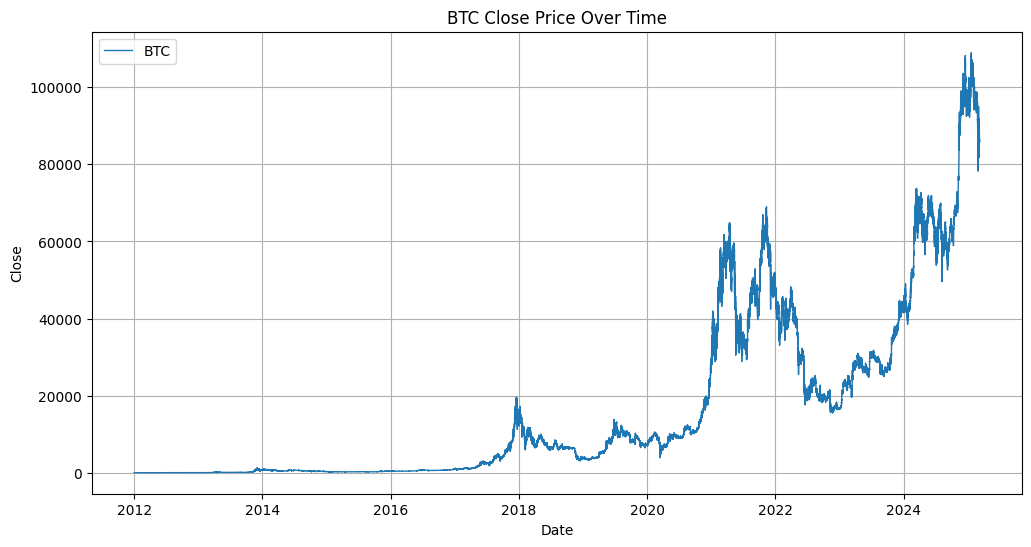

In [72]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_crypto_data(df, coin_name="Crypto", date_col="Date", price_col="Close"):
    """
    Plots the crypto price data over time.
    
    Parameters:
        df (pd.DataFrame): DataFrame with a date column and a price column.
        coin_name (str): The name of the crypto (used for the plot title and label).
        date_col (str): The column name in df that contains date information.
        price_col (str): The column name in df that contains the price data.
    """
    # Convert the date column to datetime, coerce errors, and drop invalid dates
    df["Date_dt"] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df = df.dropna(subset=["Date_dt"])
    
    plt.figure(figsize=(12, 6))
    plt.plot(df["Date_dt"], df[price_col], label=coin_name, linewidth=1)
    plt.xlabel("Date")
    plt.ylabel(price_col)
    plt.title(f"{coin_name} {price_col} Price Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with BTC data:
plot_crypto_data(btc_df, coin_name="BTC")


In [62]:
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
btc_df.to_csv(btc_processed_file, index=False, compression="gzip")

In [76]:
eth_file = os.path.join(FULL_DATA_DIR, "ETH_1min.csv")
eth_df = pd.read_csv(eth_file)
eth_df = eth_df[["Date", "Open", "High", "Low", "Close", "Volume"]]
eth_df.head()

,Date,Open,High,Low,Close,Volume
0,2020-04-16 00:00:00,152.94,152.94,151.33,151.33,112.724931
1,2020-04-15 23:59:00,152.94,152.94,152.94,152.94,0.000000
2,2020-04-15 23:58:00,153.17,153.17,152.94,152.94,0.013011
3,2020-04-15 23:57:00,152.96,153.20,152.96,153.17,466.782278
4,2020-04-15 23:56:00,153.14,153.14,152.96,152.96,167.930714


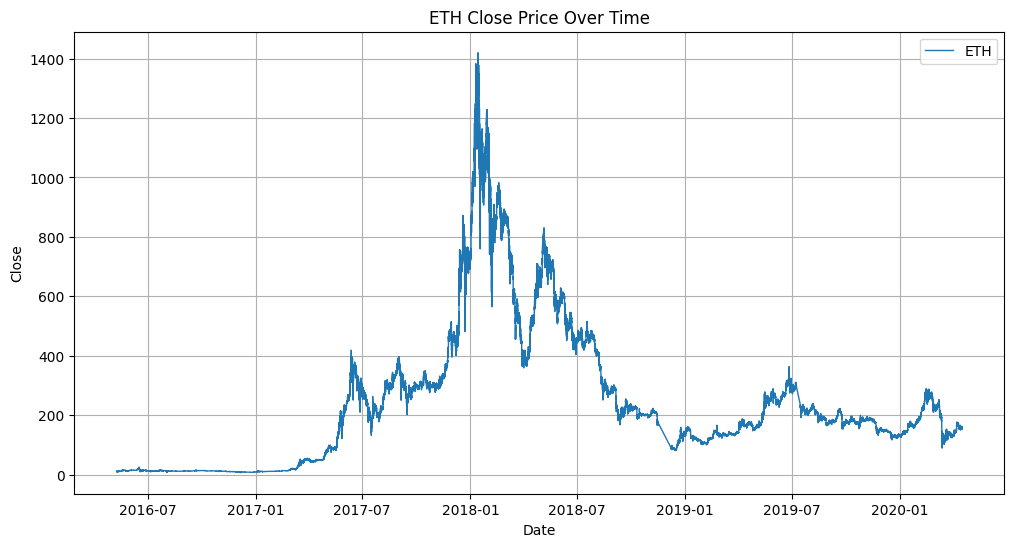

In [77]:
plot_crypto_data(eth_df, coin_name="ETH")

In [78]:
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
eth_df.to_csv(eth_processed_file, index=False, compression="gzip")

In [ ]:
# Combining coin data
crypto_df = pd.concat([btc_df, eth_df], ignore_index=True)

### Aligning News Dataset to Crypto Timeline

Only retain news articles within the range of the crypto dataset to ensure alignment during fusion in modeling.

In [85]:
# Converting "Date" column to datetime objects 
crypto_df["Date"] = pd.to_datetime(crypto_df["Date"], errors="coerce", utc=True)

# Computing the min & max dates
start_date = crypto_df["Date"].min()
end_date = crypto_df["Date"].max()
print(f"Combined crypto data range: {start_date} to {end_date}")


Combined crypto data range: 2012-01-01 10:01:00+00:00 to 2025-03-09 00:00:00+00:00


In [86]:
# Save the combined DataFrame as a compressed CSV
combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
crypto_df.to_csv(combined_file, index=False, compression="gzip")

In [87]:
# Convert the 'Date' column in df_agg to datetime objects with UTC timezone
df_agg["Date_dt"] = pd.to_datetime(df_agg["Date"], errors="coerce", utc=True)

# Filter the DataFrame to include only rows between start_date and end_date
df_filtered_news = df_agg[(df_agg["Date_dt"] >= start_date) & (df_agg["Date_dt"] <= end_date)]

print(f"Filtered news count: {len(df_filtered_news)}")

Filtered news count: 7210953


In [88]:
NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")
df_filtered_news.to_csv(NEWS_FILTERED_CSV, compression="gzip", index=False)

## `breakpoint`

### Final Output: Load-Ready DataFrames

Final CSVs for BTC, ETH, and news are stored in:
- `data/processed-data`

You can run this to import all of the files in. Make sure to download the data from hugging face.

In [89]:
import os
import pandas as pd

# Define the directory containing processed data files
PROCESSED_DATA = os.path.join("data", "processed-data")

# File paths for the processed data files
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# Read the processed CSV files using gzip compression
btc_df = pd.read_csv(btc_processed_file, compression="gzip")
eth_df = pd.read_csv(eth_processed_file, compression="gzip")
crypto_df = pd.read_csv(combined_file, compression="gzip")
df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")


# Exploratory Data Analysis (EDA): Cryptocurrency + News Dataset

This notebook explores both our market data (BTC, ETH) and our large-scale financial news dataset. Our goals:
- Understand patterns in the raw BTC and ETH price data.
- Investigate sentiment/news frequency and structure.
- Surface volatility trends and weekday/intraday behaviors.
- Highlight early stop signs of BTC/ETH movement.
This exploration sets the stage for future modeling of price change prediction, sentiment influence, and ultimately an ensemble quant model.

In [ ]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

In [1]:
# Please see 'downloading-data.ipynb' to download the files needed to run this cell
# Define the directory containing processed data files
PROCESSED_DATA = os.path.join("data", "processed-data")

# File paths for the processed data files
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# Read the processed CSV files using gzip compression
btc_df = pd.read_csv(btc_processed_file, compression="gzip")
eth_df = pd.read_csv(eth_processed_file, compression="gzip")
crypto_df = pd.read_csv(combined_file, compression="gzip")
df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")

/var/folders/69/x0d9sf3x4tn331kv5900b1h80000gn/T/ipykernel_68720/1714906350.py:16: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  crypto_df = pd.read_csv(combined_file, compression="gzip")


## News Dataset Overview

We load our filtered news dataset containing over 7 million rows with four columns:
- **Date**: Original timestamp of article
- **Article_title**: Raw title string
- **Stock_symbols**: Associated tickers, comma-separated
- **Date_dt**: Cleaned datetime format

We'll explore article frequency, length, and symbol mentions over time.

In [2]:
# Checking shape
print("Number of rows and columns in news dataset:", df_filtered_news.shape)

# Checking initial rows
df_filtered_news.head(5)

# Checking data types
df_filtered_news.info()

Number of rows and columns in news dataset: (7210953, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7210953 entries, 0 to 7210952
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Date           object
 1   Article_title  object
 2   Stock_symbols  object
 3   Date_dt        object
dtypes: object(4)
memory usage: 220.1+ MB


### Understanding Date Range & Missing Values

In [4]:
# Checking date range
min_date = df_filtered_news["Date_dt"].min()
max_date = df_filtered_news["Date_dt"].max()
print("Earliest date in news:", min_date)
print("Latest date in news:",  max_date)

# Checking missing values
missing_counts = df_filtered_news.isnull().sum()
print("Missing values:\n", missing_counts)

Earliest date in news: 2012-01-01 10:04:00+00:00
Latest date in news: 2024-01-09 00:00:00+00:00
Missing values:
 Date                   0
Article_title          0
Stock_symbols    4554201
Date_dt                0
dtype: int64


In [5]:
duplicates_count = df_filtered_news.duplicated().sum()
print("Number of fully duplicated rows:", duplicates_count)

Number of fully duplicated rows: 0


### Publication Trends

We plotted articles published per day, noticing a slight decrease over time starting in 2016. 

We also grouped by **weekday** which revealed that Thursdays had the **most articles published** on average, followed closely by Wednesdays and Tuesdays. This rhythm matches mid-week market coverage, while weekends see a sharp drop in volume as traditional markets are closed. 

Daily articles sample:
    date_only  Article_title
0  2012-01-01            146
1  2012-01-02            750
2  2012-01-03           4558
3  2012-01-04           4593
4  2012-01-05           4985


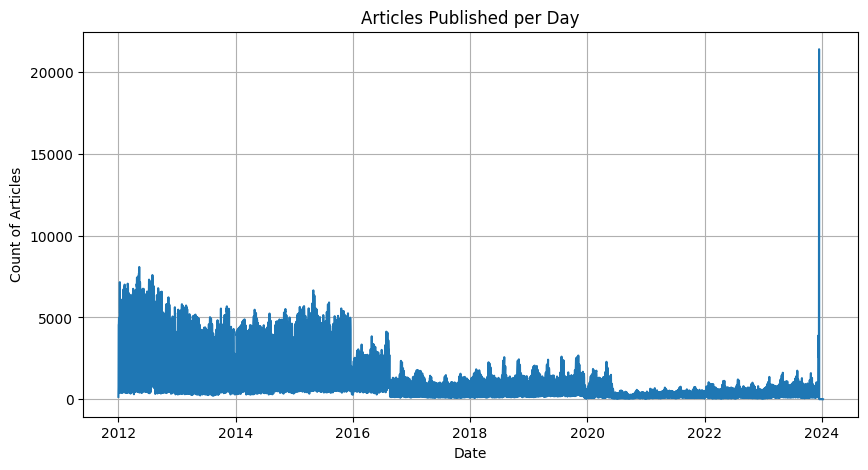

In [9]:
# Converting Date_dt to a daily period
df_filtered_news["Date_dt"] = pd.to_datetime(df_filtered_news["Date_dt"], errors="coerce")

df_filtered_news["date_only"] = df_filtered_news["Date_dt"].dt.date
articles_per_day = df_filtered_news.groupby("date_only")["Article_title"].count().reset_index()

print("Daily articles sample:")
print(articles_per_day.head())

# Plotting daily article counts
plt.figure(figsize=(10, 5))
plt.plot(articles_per_day["date_only"], articles_per_day["Article_title"])
plt.title("Articles Published per Day")
plt.xlabel("Date")
plt.ylabel("Count of Articles")
plt.grid(True)
plt.show()

Article counts by weekday:
      weekday  count_of_articles
1     Monday            1065292
5    Tuesday            1449230
6  Wednesday            1485717
4   Thursday            1506549
0     Friday            1194152
2   Saturday             337346
3     Sunday             172667

Weekday with the MOST articles: Thursday (1506549 articles)


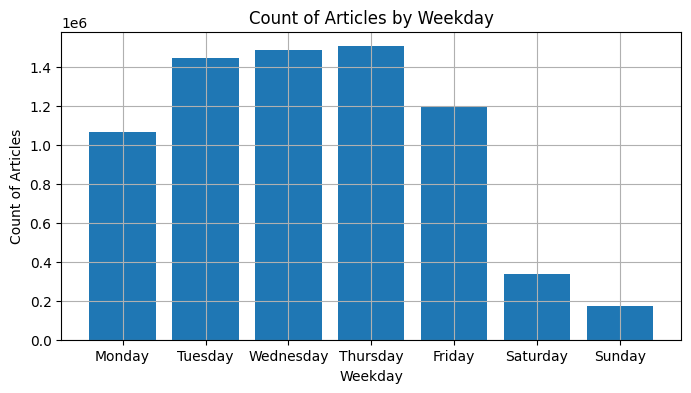

In [28]:
df_filtered_news["Date_dt"] = pd.to_datetime(df_filtered_news["Date_dt"], errors="coerce")

df_filtered_news["weekday"] = df_filtered_news["Date_dt"].dt.day_name()

articles_by_weekday = (
    df_filtered_news
    .groupby("weekday")["Article_title"]
    .count()
    .reset_index(name="count_of_articles")
)

weekday_order = list(calendar.day_name)
articles_by_weekday["weekday"] = pd.Categorical(
    articles_by_weekday["weekday"], 
    categories=weekday_order, 
    ordered=True
)
articles_by_weekday = articles_by_weekday.sort_values("weekday")

print("Article counts by weekday:\n", articles_by_weekday)

max_row = articles_by_weekday.loc[articles_by_weekday["count_of_articles"].idxmax()]
print(f"\nWeekday with the MOST articles: {max_row['weekday']} ({max_row['count_of_articles']} articles)")

plt.figure(figsize=(8, 4))
plt.bar(articles_by_weekday["weekday"], articles_by_weekday["count_of_articles"])
plt.title("Count of Articles by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Count of Articles")
plt.grid(True)
plt.show()

### Top Mentioned Stock Symbols

From millions of articles, we extracted and counted all stock symbols mentioned. Some of the symbols that appear most often are expected such as `AAPL` (Apple Inc), `TSLA` (Tesla), and `GOOG`(Google). However, some of the frequent mentions like `BROGW` (Brooge Energy) and `PMAY` (Innovator US Equity Power Buffer) may indicate unforseen circumstances such as high-frequency PR, naming collisions or spikes in reporting for specific reasons.

Top 20 stock symbols: [('GILD', 11663), ('BABA', 11489), ('NVDA', 11484), ('WFC', 11137), ('INTC', 10854), ('QQQ', 10428), ('BROGW', 10367), ('TSLA', 10294), ('MRK', 9990), ('BPYPO', 9889), ('GOOG', 9867), ('KO', 9670), ('BHFAL', 9521), ('DIS', 9518), ('T', 9309), ('MU', 9300), ('AAPL', 9141), ('AMD', 9126), ('PMAY', 8991), ('CLSN', 8964)]


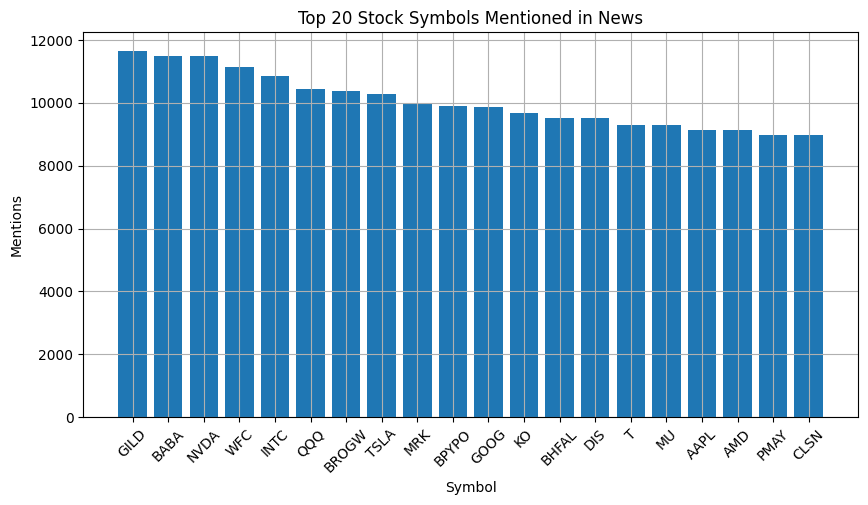

In [10]:
from collections import Counter

symbol_counter = Counter()

for row in df_filtered_news["Stock_symbols"].dropna():
    symbols = [s.strip() for s in row.split(",") if s.strip() != ""]
    symbol_counter.update(symbols)

# Show the top 20
top_symbols = symbol_counter.most_common(20)
print("Top 20 stock symbols:", top_symbols)

# Convert to DataFrame for plotting
symbols_df = pd.DataFrame(top_symbols, columns=["Symbol", "Count"])

plt.figure(figsize=(10, 5))
plt.bar(symbols_df["Symbol"], symbols_df["Count"])
plt.title("Top 20 Stock Symbols Mentioned in News")
plt.xlabel("Symbol")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Article Title Length Distribution

Most article titles hover around 50–70 characters. The distribution is right-skewed with outliers (max 512 characters). This informs preprocessing choices for future NLP models (e.g., input truncation).

count    7.210953e+06
mean     6.719732e+01
std      2.714175e+01
min      1.000000e+00
25%      5.100000e+01
50%      6.200000e+01
75%      7.700000e+01
max      5.120000e+02
Name: title_length, dtype: float64


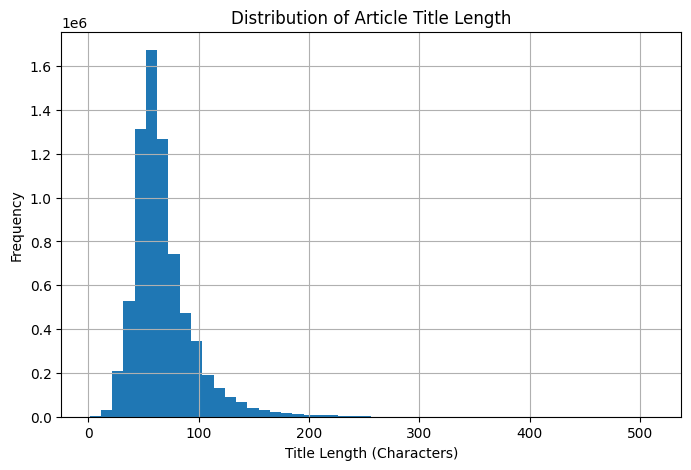

In [11]:
df_filtered_news["title_length"] = df_filtered_news["Article_title"].astype(str).apply(len)

# Basic stats on title length
print(df_filtered_news["title_length"].describe())

plt.figure(figsize=(8, 5))
plt.hist(df_filtered_news["title_length"], bins=50)
plt.title("Distribution of Article Title Length")
plt.xlabel("Title Length (Characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## BTC / ETH Dataset Overview

- **BTC**: 1-minute intervals from Jan 2012 to March 2025 (~6.8M rows)
- **ETH**: 1-minute intervals from May 2016 to April 2020 (~2M rows)

Each row includes `Open`, `High`, `Low`, `Close`, `Volume`.

We're particularly interested in minute-level returns, volatility patterns, and weekday behavior.

In [12]:
print("BTC data shape:", btc_df.shape)
print("ETH data shape:", eth_df.shape)
print("Combined crypto data shape:", crypto_df.shape)

btc_df.info()
eth_df.info()

crypto_df.head(5)

BTC data shape: (6779281, 6)
ETH data shape: (1984012, 7)
Combined crypto data shape: (8763293, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6779281 entries, 0 to 6779280
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  float64
dtypes: float64(5), object(1)
memory usage: 310.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984012 entries, 0 to 1984011
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Date     object 
 1   Open     float64
 2   High     float64
 3   Low      float64
 4   Close    float64
 5   Volume   float64
 6   Date_dt  object 
dtypes: float64(5), object(2)
memory usage: 106.0+ MB


,Date,Open,High,Low,Close,Volume,Date_dt
0,2012-01-01 10:01:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,2012-01-01 10:02:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,2012-01-01 10:03:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,2012-01-01 10:04:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,2012-01-01 10:05:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [13]:
print("BTC Summary:")
print(btc_df.describe())

print("\nETH Summary:")
print(eth_df.describe())


BTC Summary:
               Open          High           Low         Close        Volume
count  6.779281e+06  6.779281e+06  6.779281e+06  6.779281e+06  6.779281e+06
mean   1.507124e+04  1.507766e+04  1.506460e+04  1.507125e+04  5.439022e+00
std    2.068588e+04  2.069364e+04  2.067793e+04  2.068591e+04  2.287430e+01
min    3.800000e+00  3.800000e+00  3.800000e+00  3.800000e+00  0.000000e+00
25%    4.150200e+02  4.151500e+02  4.149700e+02  4.150100e+02  1.846336e-02
50%    6.325550e+03  6.327640e+03  6.323090e+03  6.325570e+03  4.972129e-01
75%    2.370003e+04  2.371100e+04  2.369000e+04  2.370022e+04  3.157064e+00
max    1.089460e+05  1.090300e+05  1.087760e+05  1.089600e+05  5.853852e+03

ETH Summary:
               Open          High           Low         Close        Volume
count  1.984012e+06  1.984012e+06  1.984012e+06  1.984012e+06  1.984012e+06
mean   2.418247e+02  2.419602e+02  2.416817e+02  2.418249e+02  2.612284e+01
std    2.415172e+02  2.417080e+02  2.413119e+02  2.415171e+02

### Understanding Date Range & Missing Values

In [14]:
# BTC date range
btc_df["Date"] = pd.to_datetime(btc_df["Date"], utc=True, errors="coerce")
print("BTC earliest date:", btc_df["Date"].min())
print("BTC latest date:",  btc_df["Date"].max())

# ETH date range
eth_df["Date"] = pd.to_datetime(eth_df["Date"], utc=True, errors="coerce")
print("ETH earliest date:", eth_df["Date"].min())
print("ETH latest date:",  eth_df["Date"].max())

# Check for missing
print("BTC missing values:\n", btc_df.isnull().sum())
print("ETH missing values:\n", eth_df.isnull().sum())

BTC earliest date: 2012-01-01 10:01:00+00:00
BTC latest date: 2025-03-09 00:00:00+00:00
ETH earliest date: 2016-05-09 13:32:00+00:00
ETH latest date: 2020-04-16 00:00:00+00:00
BTC missing values:
 Date      1
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
ETH missing values:
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
Date_dt    0
dtype: int64


### Price and Volume Over Time

Visualizing BTC and ETH price histories confirms:
- Bitcoin's long-term upward trend with high volatility.
- Ethereum's volatility profile is slightly more amplified.
- Volume trends spike near price action peaks—especially around late 2017 and late 2020.

These visuals support our use of **volatility technical indicators** in modeling.

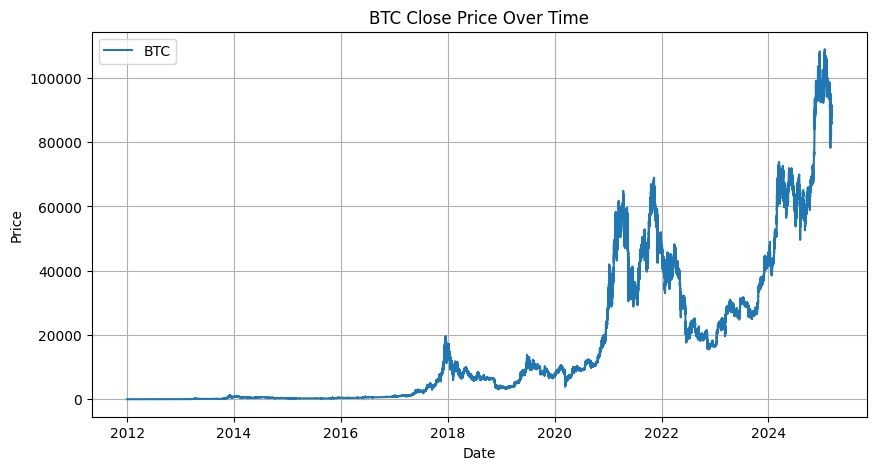

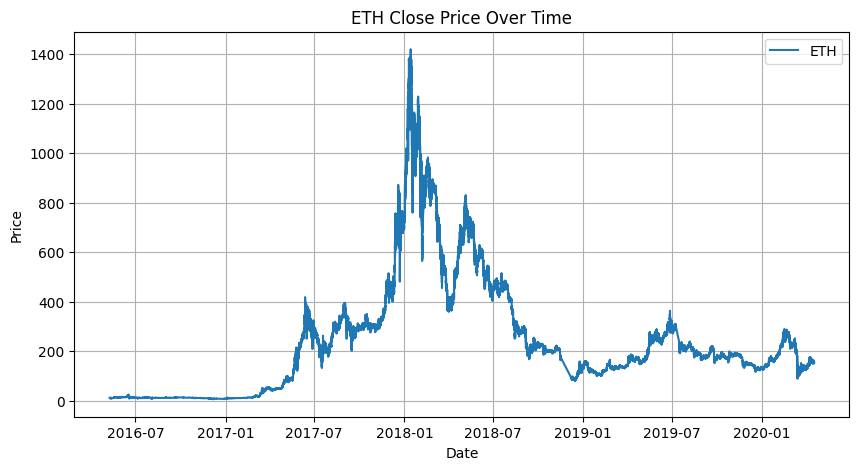

In [15]:
def plot_crypto_data(df, coin_name="Crypto", date_col="Date", price_col="Close"):
    # Convert date col to datetime just in case
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df = df.dropna(subset=[date_col, price_col])
    
    plt.figure(figsize=(10, 5))
    plt.plot(df[date_col], df[price_col], label=coin_name)
    plt.title(f"{coin_name} {price_col} Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_crypto_data(btc_df, coin_name="BTC", price_col="Close")
plot_crypto_data(eth_df, coin_name="ETH", price_col="Close")


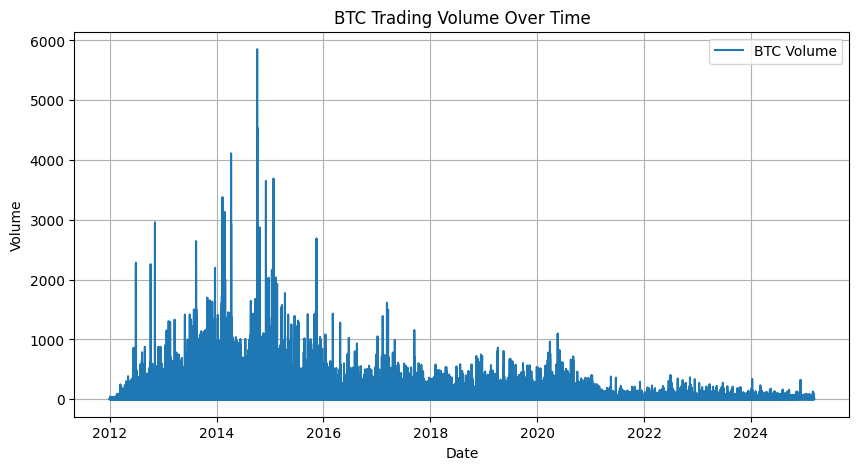

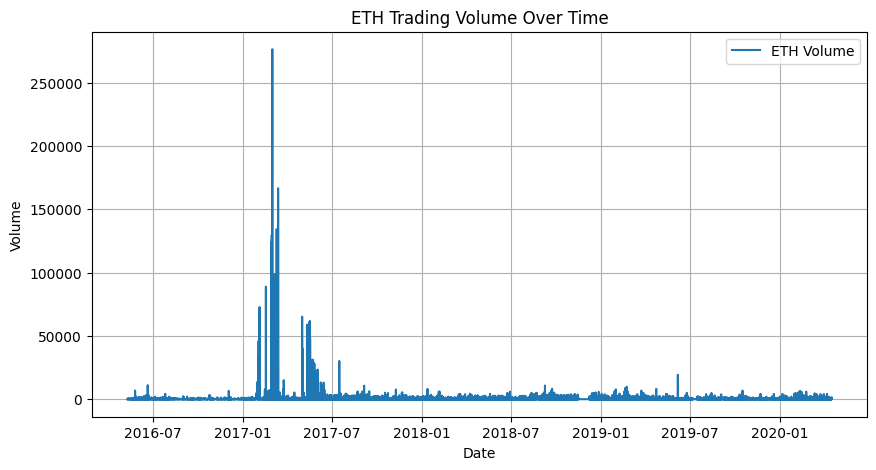

In [16]:
def plot_volume_over_time(df, coin_name="Crypto", date_col="Date", vol_col="Volume"):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df = df.dropna(subset=[date_col, vol_col])
    
    plt.figure(figsize=(10, 5))
    plt.plot(df[date_col], df[vol_col], label=f"{coin_name} Volume")
    plt.title(f"{coin_name} Trading Volume Over Time")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_volume_over_time(btc_df, coin_name="BTC")
plot_volume_over_time(eth_df, coin_name="ETH")

## Daily Returns Overview

- **BTC** daily returns:
  - Mean: ~0.29%
  - Std: ~4.2%
- **ETH** daily returns:
  - Mean: ~0.38%
  - Std: ~6.1%

ETH is higher-volatility overall. Both coins show heavy tails and occasional extreme events which is expected for crypto coins.

#### Daily Return Distribution

count    4816.000000
mean        0.002924
std         0.041635
min        -0.538385
25%        -0.012227
50%         0.001360
75%         0.018142
max         0.358107
Name: daily_return, dtype: float64
count    1438.000000
mean        0.003873
std         0.061343
min        -0.468599
25%        -0.022472
50%         0.000000
75%         0.025689
max         0.302857
Name: daily_return, dtype: float64


/var/folders/69/x0d9sf3x4tn331kv5900b1h80000gn/T/ipykernel_68720/2482960268.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  eth_daily["daily_return"] = eth_daily["Close"].pct_change()


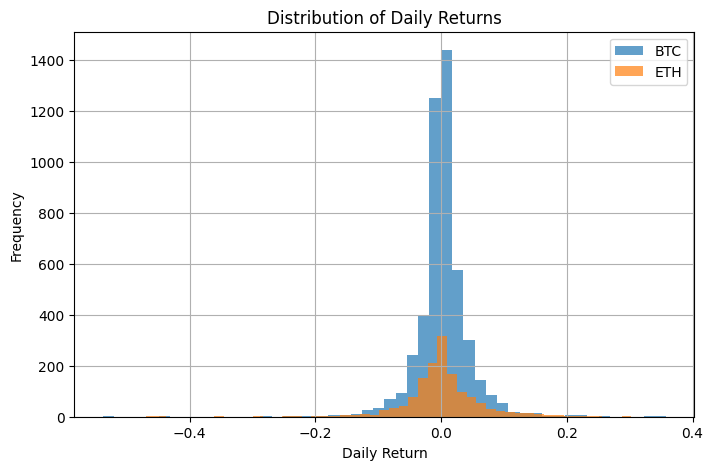

In [17]:
# Overlapping distribution
# Resample to daily close for BTC
btc_df["Date"] = pd.to_datetime(btc_df["Date"], utc=True, errors="coerce")
btc_daily = btc_df.set_index("Date").resample("D").agg({"Open": "first", 
                                                        "High": "max", 
                                                        "Low": "min", 
                                                        "Close": "last", 
                                                        "Volume": "sum"})
btc_daily["daily_return"] = btc_daily["Close"].pct_change()

# Resample to daily close for ETH
eth_df["Date"] = pd.to_datetime(eth_df["Date"], utc=True, errors="coerce")
eth_daily = eth_df.set_index("Date").resample("D").agg({"Open": "first", 
                                                        "High": "max", 
                                                        "Low": "min", 
                                                        "Close": "last", 
                                                        "Volume": "sum"})
eth_daily["daily_return"] = eth_daily["Close"].pct_change()

# Checking stats on daily returns
print(btc_daily["daily_return"].describe())
print(eth_daily["daily_return"].describe())

plt.figure(figsize=(8, 5))
plt.hist(btc_daily["daily_return"].dropna(), bins=50, alpha=0.7, label="BTC")
plt.hist(eth_daily["daily_return"].dropna(), bins=50, alpha=0.7, label="ETH")
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()


#### Daily Return Box Plot

/var/folders/69/x0d9sf3x4tn331kv5900b1h80000gn/T/ipykernel_68720/2497639128.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


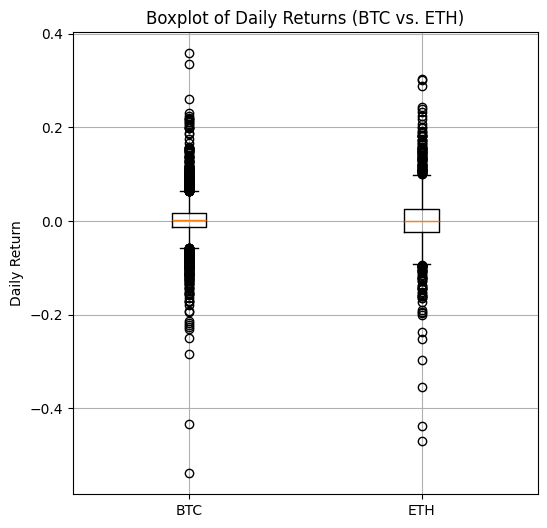

In [20]:
# Side by side boxplots
plt.figure(figsize=(6, 6))
plt.boxplot(
    [
        btc_daily["daily_return"].dropna(), 
        eth_daily["daily_return"].dropna()
    ],
    labels=["BTC", "ETH"]
)
plt.title("Boxplot of Daily Returns (BTC vs. ETH)")
plt.ylabel("Daily Return")
plt.grid(True)
plt.show()

#### Daily Return Time Series

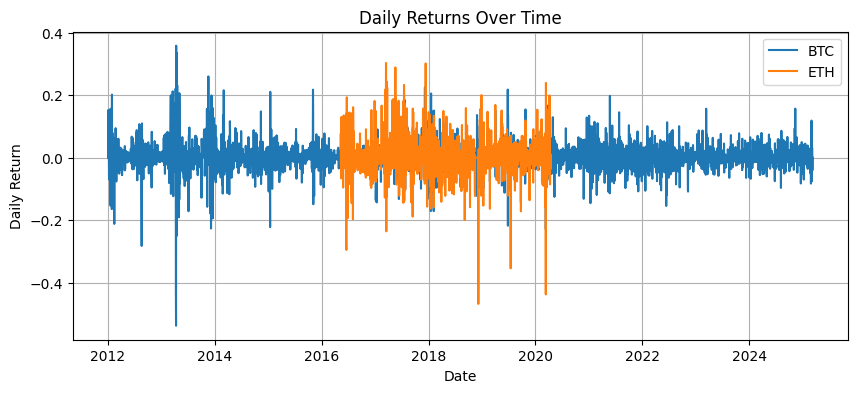

In [21]:
# Time series to understand volitility
plt.figure(figsize=(10, 4))
plt.plot(btc_daily.index, btc_daily["daily_return"], label="BTC")
plt.plot(eth_daily.index, eth_daily["daily_return"], label="ETH")
plt.title("Daily Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.show()

### Weekday Return Patterns

Interesting results emerge:

- **BTC** sees highest average returns on **Mondays and Tuesdays**
- **ETH** peaks on **Tuesdays**, with Friday and Sunday also notable

Volatility tends to spike mid-week and drop on weekends, likely due to global market overlaps and media cycles. Additionally, traditional traders who are familiar with typical weekend market closures may be less active on the weekends and more active mid week. This supports the additional and relaiance on temporal features in our future models.

In [22]:
btc_daily_reset = btc_daily.reset_index()
btc_daily_reset["weekday"] = btc_daily_reset["Date"].dt.day_name()  


eth_daily_reset = eth_daily.reset_index()
eth_daily_reset["weekday"] = eth_daily_reset["Date"].dt.day_name()

In [23]:
btc_weekday_stats = btc_daily_reset.groupby("weekday")["daily_return"].agg(
    mean_return=("mean"),
    median_return=("median"),
    count=("size"),
    max_return=("max"),
    min_return=("min"),
    std_dev=("std")
).reset_index()

eth_weekday_stats = eth_daily_reset.groupby("weekday")["daily_return"].agg(
    mean_return=("mean"),
    median_return=("median"),
    count=("size"),
    max_return=("max"),
    min_return=("min"),
    std_dev=("std")
).reset_index()

print("BTC weekday stats:\n", btc_weekday_stats)
print("\nETH weekday stats:\n", eth_weekday_stats)

BTC weekday stats:
      weekday  mean_return  median_return  count  max_return  min_return  \
0     Friday     0.001504       0.001159    688    0.358107   -0.226969   
1     Monday     0.006252       0.002947    688    0.259831   -0.171537   
2   Saturday     0.002117       0.001089    688    0.206092   -0.164966   
3     Sunday     0.000094       0.000383    689    0.201629   -0.282845   
4   Thursday     0.001485       0.000210    688    0.225064   -0.538385   
5    Tuesday     0.004860       0.002325    688    0.217376   -0.250575   
6  Wednesday     0.004159       0.002336    688    0.334816   -0.433551   

    std_dev  
0  0.041623  
1  0.042771  
2  0.032313  
3  0.034428  
4  0.048912  
5  0.041014  
6  0.047483  

ETH weekday stats:
      weekday  mean_return  median_return  count  max_return  min_return  \
0     Friday     0.005412       0.002145    205    0.288481   -0.468599   
1     Monday     0.006085       0.000000    206    0.232527   -0.159326   
2   Saturday     0.00

In [ ]:
weekday_order = list(calendar.day_name)  # ["Monday", "Tuesday", ..., "Sunday"]

btc_weekday_stats["weekday"] = pd.Categorical(
    btc_weekday_stats["weekday"],
    categories=weekday_order,
    ordered=True
)
btc_weekday_stats = btc_weekday_stats.sort_values("weekday")

In [25]:
print("BTC highest average daily return on:\n",
      btc_weekday_stats.loc[btc_weekday_stats["mean_return"].idxmax()])

print("\nETH highest average daily return on:\n",
      eth_weekday_stats.loc[eth_weekday_stats["mean_return"].idxmax()])

BTC highest average daily return on:
 weekday            Monday
mean_return      0.006252
median_return    0.002947
count                 688
max_return       0.259831
min_return      -0.171537
std_dev          0.042771
Name: 1, dtype: object

ETH highest average daily return on:
 weekday           Tuesday
mean_return      0.006649
median_return   -0.000303
count                 206
max_return       0.301401
min_return      -0.354649
std_dev          0.069647
Name: 5, dtype: object


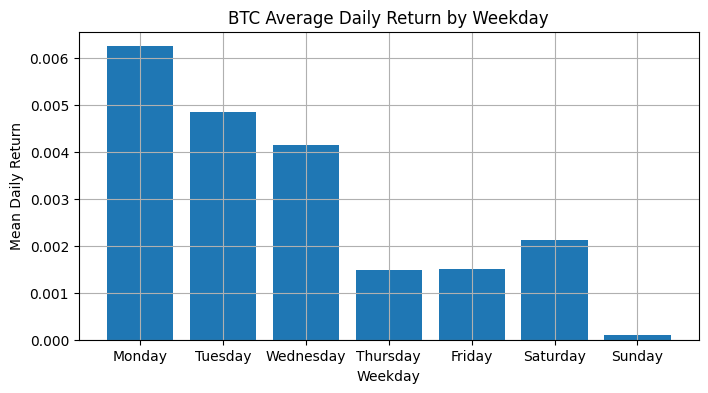

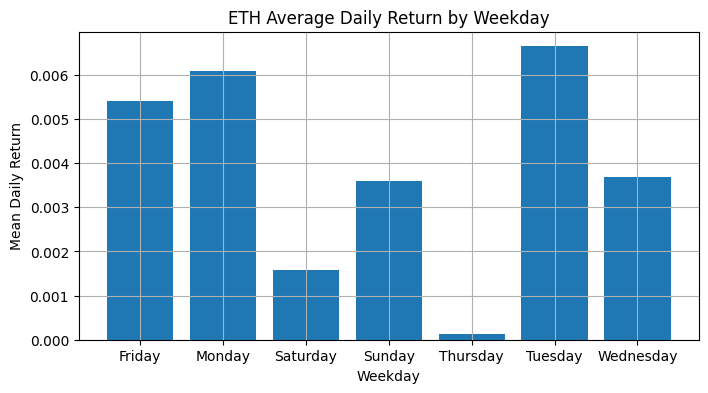

In [26]:
# BTC
plt.figure(figsize=(8, 4))
plt.bar(btc_weekday_stats["weekday"], btc_weekday_stats["mean_return"])
plt.title("BTC Average Daily Return by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Mean Daily Return")
plt.grid(True)
plt.show()

# ETH
plt.figure(figsize=(8, 4))
plt.bar(eth_weekday_stats["weekday"], eth_weekday_stats["mean_return"])
plt.title("ETH Average Daily Return by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Mean Daily Return")
plt.grid(True)
plt.show()

## BTC vs. ETH Return Correlation

- **Daily** correlation: ~0.47 (moderate)
- **Minute-level** correlation: ~0.00

These metrics indicate high-level trends are moderately aligned (0.47), but minute-by-minute price moves are mostly independent (0.0). It justifies training separate models or having fusion layers that handle BTC and ETH independently.

In [18]:
# Join daily returns for BTC and ETH on the date index
merged_daily = pd.DataFrame({
    "BTC_return": btc_daily["daily_return"],
    "ETH_return": eth_daily["daily_return"]
}).dropna()

# Daily return correlation
correlation = merged_daily.corr()
print("Correlation between BTC and ETH daily returns:\n", correlation)

Correlation between BTC and ETH daily returns:
             BTC_return  ETH_return
BTC_return     1.00000     0.46913
ETH_return     0.46913     1.00000


In [ ]:
# Minute return correlation
btc_df["Date"] = pd.to_datetime(btc_df["Date"], errors="coerce", utc=True)
eth_df["Date"] = pd.to_datetime(eth_df["Date"], errors="coerce", utc=True)

btc_df = btc_df.sort_values("Date").set_index("Date")
eth_df = eth_df.sort_values("Date").set_index("Date")

btc_df["minute_return"] = btc_df["Close"].pct_change()
eth_df["minute_return"] = eth_df["Close"].pct_change()

merged_minute = pd.merge(
    btc_df[["minute_return"]],
    eth_df[["minute_return"]],
    left_index=True,
    right_index=True,
    suffixes=("_BTC", "_ETH")
).dropna()

correlation_minute = merged_minute.corr()
print("Correlation between BTC and ETH minute-level returns:\n", correlation_minute)

Correlation between BTC and ETH minute-level returns:
                    minute_return_BTC  minute_return_ETH
minute_return_BTC           1.000000           0.000242
minute_return_ETH           0.000242           1.000000


## Intraday Volatility by Hour (UTC)

Both coins exhibit:
- Quietest hours: 2–5 AM UTC
- Midday dip (7–10 AM UTC)
- Peaks: 18–22 UTC

This suggests global market overlap boosts volatility. Including **hour-of-day features** could increase model precision for short-term predictions.

## Volatility by Hour & Weekday

Returns show stronger spikes on **Mondays**, likely due to weekend news. Sunday night also picks up in volatility, aligning with market reopenings for traditional stocks on Monday. 

This pattern held for both BTC and ETH, reinforcing the importance of **calendar effects** in crypto models.

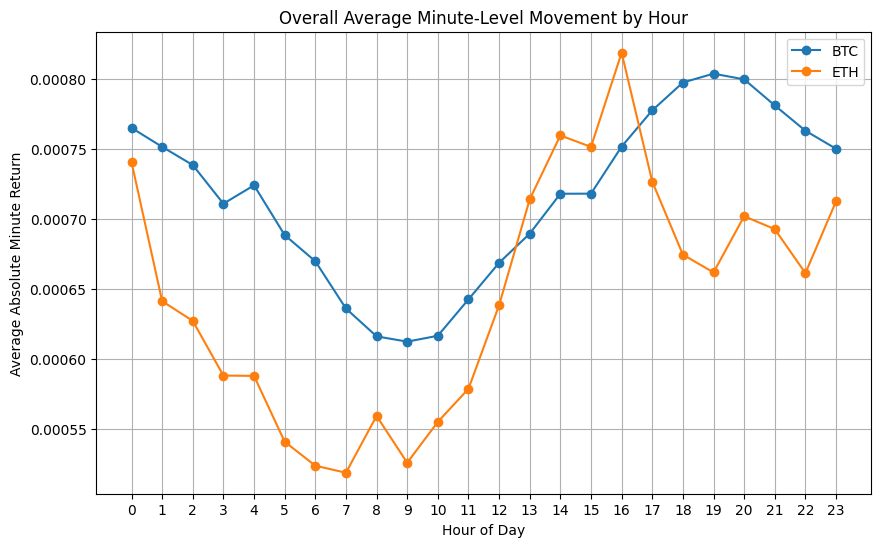

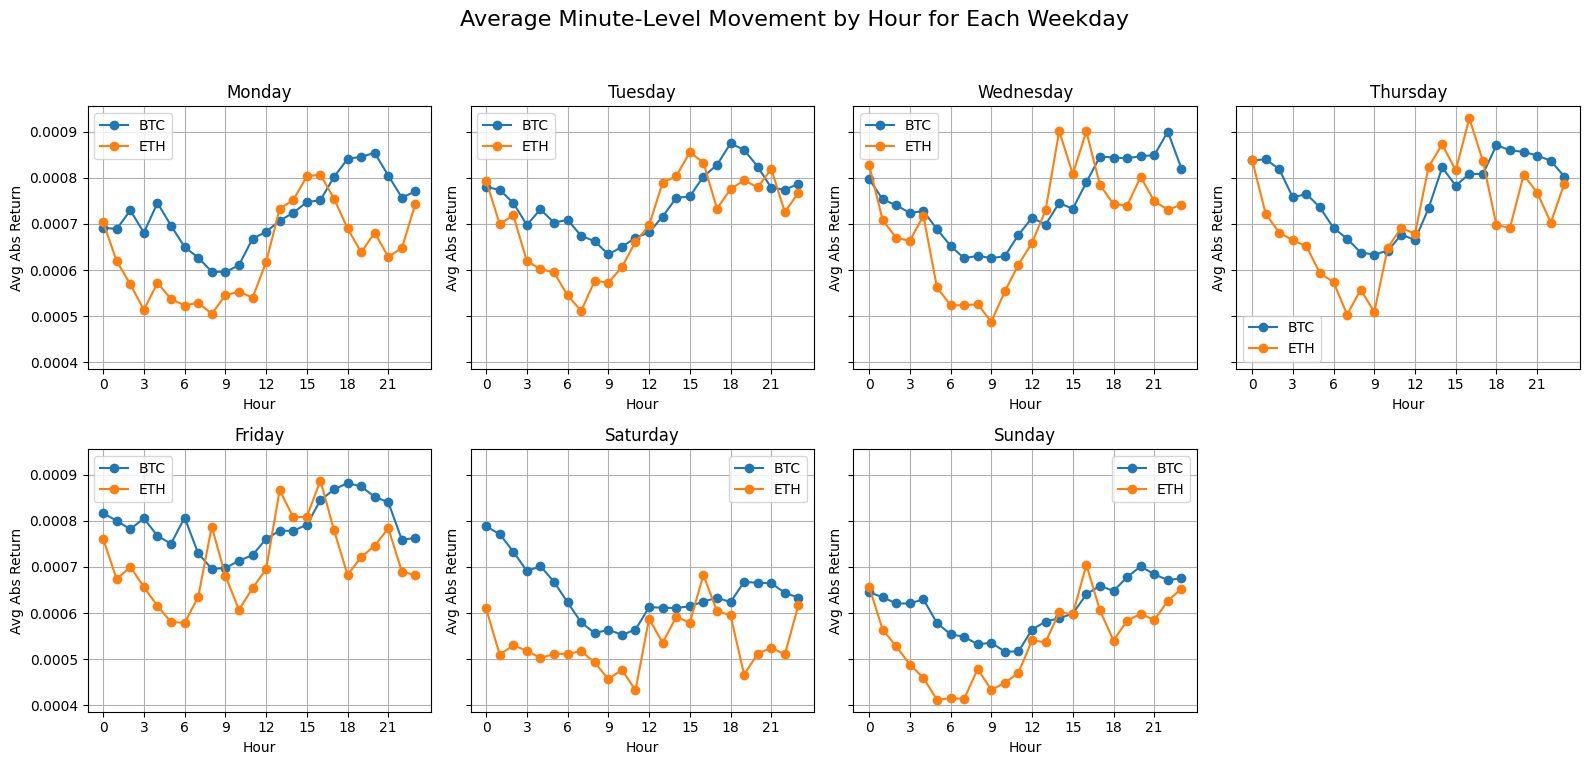

In [34]:
def prepare_df(df):
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=True)
        df = df.sort_values("Date").set_index("Date")
    else:
        df.index = pd.to_datetime(df.index, errors="coerce", utc=True)
        df = df.sort_index()
    return df

def calculate_minute_returns(df):
    df["minute_return"] = df["Close"].pct_change()
    df["abs_minute_return"] = df["minute_return"].abs()
    return df

def analyze_overall_hourly_movement(btc_df, eth_df):
    btc_df = prepare_df(btc_df)
    eth_df = prepare_df(eth_df)
    btc_df = calculate_minute_returns(btc_df)
    eth_df = calculate_minute_returns(eth_df)
    btc_df["hour"] = btc_df.index.hour
    eth_df["hour"] = eth_df.index.hour
    btc_hourly = btc_df.groupby("hour")["abs_minute_return"].mean().reset_index(name="btc_avg_movement")
    eth_hourly = eth_df.groupby("hour")["abs_minute_return"].mean().reset_index(name="eth_avg_movement")
    overall = pd.merge(btc_hourly, eth_hourly, on="hour")
    plt.figure(figsize=(10, 6))
    plt.plot(overall["hour"], overall["btc_avg_movement"], marker="o", label="BTC")
    plt.plot(overall["hour"], overall["eth_avg_movement"], marker="o", label="ETH")
    plt.title("Overall Average Minute-Level Movement by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Absolute Minute Return")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.legend()
    plt.show()
    return overall

def analyze_hourly_movement_by_weekday(btc_df, eth_df):
    btc_df = prepare_df(btc_df)
    eth_df = prepare_df(eth_df)
    btc_df = calculate_minute_returns(btc_df)
    eth_df = calculate_minute_returns(eth_df)
    btc_df["hour"] = btc_df.index.hour
    eth_df["hour"] = eth_df.index.hour
    btc_df["weekday"] = btc_df.index.day_name()
    eth_df["weekday"] = eth_df.index.day_name()
    weekdays = list(calendar.day_name)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)
    axes = axes.flatten()
    for i, day in enumerate(weekdays):
        btc_day = btc_df[btc_df["weekday"] == day]
        eth_day = eth_df[eth_df["weekday"] == day]
        btc_hourly = btc_day.groupby("hour")["abs_minute_return"].mean().reset_index(name="btc_avg_movement")
        eth_hourly = eth_day.groupby("hour")["abs_minute_return"].mean().reset_index(name="eth_avg_movement")
        ax = axes[i]
        ax.plot(btc_hourly["hour"], btc_hourly["btc_avg_movement"], marker="o", label="BTC")
        ax.plot(eth_hourly["hour"], eth_hourly["eth_avg_movement"], marker="o", label="ETH")
        ax.set_title(day)
        ax.set_xlabel("Hour")
        ax.set_ylabel("Avg Abs Return")
        ax.set_xticks(range(0, 24, 3))
        ax.grid(True)
        ax.legend()
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle("Average Minute-Level Movement by Hour for Each Weekday", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

overall = analyze_overall_hourly_movement(btc_df.copy(), eth_df.copy())
analyze_hourly_movement_by_weekday(btc_df.copy(), eth_df.copy())

## Key Takeaways

- News article volume typically increases mid-week, and titles are often short.
- BTC and ETH exhibit high volatility and weekday-specific patterns.
- BTC/ETH returns are only moderately correlated over daily intervals—but diverge at minute scale.
- Intraday volatility spikes in late UTC hours.
- Monday and Tuesday consistently produce higher average returns.

These insights shape our feature engineering and confirm that BTC and ETH deserve distinct treatment within the ensemble model.

# Feature Engineering: Cryptocurrency (BTC+ETH) & Sentiment Data

This notebook performs extensive feature engineering on Bitcoin (BTC), Ethereum (ETH), and financial news data in preparation for predictive modeling.

### Goals:
- Engineer informative and relavant features for BTC and ETH to feed into quant trading models.
- Understand technical indicators, lagged price metrics, candlestick patterns, and volume/volatility indicators.
- Process and aggregate sentiment from news headlines using FinBERT to capture market mood over time.

These engineered features will later be used in multiple deep learning architectures to predict % change in BTC prices.

In [2]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm import tqdm

# Defining paths
PROCESSED_DATA = os.path.join("data", "processed-data")

import warnings
warnings.filterwarnings('ignore')

## Load Processed Datasets

We begin by loading previously cleaned and compressed BTC, ETH, and aggregated news datasets.
These datasets already include minute-level pricing data and article headlines aligned by timestamp. Please see 'downloading-data.ipynb' for specific instructions on downloading the data. 

In [5]:
# File paths
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
combined_file      = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
NEWS_FILTERED_CSV  = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# Read the processed CSV files using gzip compression
btc_df = pd.read_csv(btc_processed_file, compression="gzip")
eth_df = pd.read_csv(eth_processed_file, compression="gzip")
crypto_df = pd.read_csv(combined_file, compression="gzip")
df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")

## Feature Engineering Functions

The follow cell defines all necessary functions to generate technical indicator features based on price, volume, volatility, and sentiment. Below is a summary of what’s generated and how:

#### Lagged Price-Based Returns
- **PctChange_1m, 5m, 1h, 1d, 1w, 1mo**: Percent changes from historical prices over various time intervals (1 minute to 1 month), calculated using backward joins (`merge_asof`) or shifts.
- Captures momentum and short-term reversals.

#### Moving Averages
- **SMA_20, 50, 200**: Simple moving averages across short-, medium-, and long-term windows.
- **EMA_20, 50, 200**: Exponential moving averages with higher weight on recent prices.
- Helps identify trends and smoothing volatility.

#### RSI (Relative Strength Index)
- **RSI_14**: Measures price momentum to determine overbought/oversold conditions over 14 periods.
- Values above 70 indicate overbought; below 30 indicate oversold.

#### MACD (Moving Average Convergence Divergence)
- **MACD, MACD_Signal, MACD_Hist**: Difference between fast and slow EMAs to show trend direction, strength, and momentum shifts.

#### Bollinger Bands
- **BB_Upper, BB_Middle, BB_Lower**: Band-style indicators based on a 20-period SMA ± 2 std devs.
- Detects price breakout/breakdown potential and volatility.

#### Volume Features
- **VolMA_short, VolMA_long, VolumeOscillator**: Compares short and long-term volume trends to detect unusual trading activity.
- **OBV (On-Balance Volume)**: Combines volume with direction to detect accumulation or distribution pressure.

#### Candlestick Features
- **candle_range**: High minus low (daily range).
- **body_size**: Absolute difference between open and close.
- **Doji**: Binary feature indicating indecision (small body, long wicks).

#### Volatility
- **ATR (Average True Range)**: Rolling measure of absolute volatility based on high/low/close.
- Tracks periods of high or low market uncertainty.

#### ADX (Average Directional Index)
- **+DI, -DI, ADX**: Directional indicators to measure trend strength (not direction).

#### Stochastic Oscillator
- **%K, %D**: Shows position of close relative to recent high/low range.
- Identifies momentum shifts and potential turning points.

#### Williams %R
- **Williams_%R**: Similar to Stochastic, but inverted; more sensitive to rapid changes.

These features collectively capture:
- Trend strength and direction  
- Momentum and reversals  
- Price volatility  
- Volume surges  
- Candlestick patterns that reflect trader behavior

They are applied identically to both BTC and ETH data to preserve consistency across models in our feature pipeline.

In [ ]:
# Converts datetime index into an integer ID
def convert_datetime_index_to_id(df, datetime_col):
    df.reset_index(inplace=True)  
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['id'] = df[datetime_col].dt.strftime('%Y%m%d%H%M').astype(int)
    df.drop(datetime_col, axis=1, inplace=True)
    df.set_index('id', inplace=True)
    return df

# Prepares df by parsing date, removing NaNs, sorting, and adding a readable minute-level ID
def prepare_df(df):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    df.set_index('Date', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df["minute_id"] = df.index.strftime("%Y%m%d%H%M").astype(int)
    return df

# Adds lagged prices and % changes using merge_asof to align irregular time data
def add_time_based_price_changes_merge_asof(df, offsets, price_col='Close'):
    df_reset = df.reset_index().rename(columns={'Date': 'time'})
    df_reset.sort_values('time', inplace=True)   
    earliest_time = df_reset["time"].min()
    for label, offset_str in offsets:
        offset_td = pd.Timedelta(offset_str)
        target_col = f"target_time_{label}"       
        df_reset[target_col] = df_reset["time"] - offset_td
        temp = df_reset[["time", price_col]].copy()
        merged = pd.merge_asof(
            df_reset,
            temp,
            left_on=target_col,
            right_on="time",
            direction="backward",
            suffixes=("", f"_{label}_ago")
        )     
        old_price_col = f"{price_col}_{label}_ago"
        df_reset[old_price_col] = merged[old_price_col]    
        df_reset.loc[df_reset[target_col] < earliest_time, old_price_col] = np.nan
        df_reset[f"PctChange_{label}"] = (
            (df_reset[price_col] - df_reset[old_price_col]) / df_reset[old_price_col]
        )
        df_reset.drop(columns=[target_col], inplace=True)
    df_final = df_reset.set_index("time")
    return df_final

# Adds lagged prices & percent changes using standard shift indexing
def add_time_based_price_changes_shift(df, offsets, price_col='Close'):
    for label, num_minutes in offsets:
        old_price_col = f"{price_col}_{label}_ago"
        df[old_price_col] = df[price_col].shift(num_minutes)
        df[f"PctChange_{label}"] = (
            (df[price_col] - df[old_price_col]) / df[old_price_col]
        )
    return df

# Adds simple & exponential moving averages to capture trend signals
def add_moving_averages(df, windows=[20, 50, 200], price_col='Close'):
    for w in windows:
        df[f'SMA_{w}'] = df[price_col].rolling(window=w).mean()
        df[f'EMA_{w}'] = df[price_col].ewm(span=w, adjust=False).mean()
    return df

# Adds Relative Strength Index (RSI) for understanding momentum and overbought/oversold signals
def add_rsi(df, period=14, price_col='Close', rsi_col='RSI'):
    delta = df[price_col].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()
    rs = avg_gain / avg_loss
    df[rsi_col] = 100 - (100 / (1 + rs))
    return df

# Adds MACD & signal line for trend following and momentum divergence
def add_macd(df, short=12, long=26, signal=9, price_col='Close'):
    ema_short = df[price_col].ewm(span=short, adjust=False).mean()
    ema_long = df[price_col].ewm(span=long, adjust=False).mean()
    df['MACD'] = ema_short - ema_long
    df['MACD_Signal'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    return df

# Adds Bollinger Bands to track price volatility relative to a moving average
def add_bollinger_bands(df, window=20, n_std=2, price_col='Close'):
    rolling_mean = df[price_col].rolling(window=window).mean()
    rolling_std = df[price_col].rolling(window=window).std()
    df['BB_Middle'] = rolling_mean
    df['BB_Upper'] = rolling_mean + (n_std * rolling_std)
    df['BB_Lower'] = rolling_mean - (n_std * rolling_std)
    return df

# Adds volume oscillator to detect increases or decreases in trading activity
def add_volume_oscillator(df, short=5, long=20, volume_col='Volume'):
    df['VolMA_short'] = df[volume_col].rolling(window=short).mean()
    df['VolMA_long'] = df[volume_col].rolling(window=long).mean()
    df['VolumeOscillator'] = (
        (df['VolMA_short'] - df['VolMA_long']) / df['VolMA_long']
    ) * 100
    return df

# Adds On-Balance Volume (OBV) to measure volume momentum
def add_obv(df, price_col='Close', volume_col='Volume'):
    """
    Vectorized On-Balance Volume calculation.
    sign() → +1 if close>prev_close, -1 if close<prev_close, 0 otherwise
    Then cumulative sum.
    """
    price_diff = df[price_col].diff()
    direction = np.sign(price_diff).fillna(0)
    df['OBV'] = (direction * df[volume_col]).fillna(0).cumsum()
    return df

# Adds basic candlestick pattern features like body size and Doji detection
def add_candlestick_patterns(df, open_col='Open', high_col='High', low_col='Low', close_col='Close'):
    df['candle_range'] = df[high_col] - df[low_col]
    df['body_size'] = (df[close_col] - df[open_col]).abs()
    df['Doji'] = (df['body_size'] <= 0.1 * df['candle_range']).astype(int)
    return df

# Adds Average True Range (ATR) to measure volatility based on price extremes
def add_atr(df, period=14, high_col='High', low_col='Low', close_col='Close'):
    df['prev_close'] = df[close_col].shift(1)
    df['tr1'] = df[high_col] - df[low_col]
    df['tr2'] = (df[high_col] - df['prev_close']).abs()
    df['tr3'] = (df[low_col] - df['prev_close']).abs()
    df['TR'] = df[['tr1','tr2','tr3']].max(axis=1)
    df['ATR'] = df['TR'].ewm(alpha=1/period, adjust=False).mean()  
    df.drop(columns=['prev_close','tr1','tr2','tr3','TR'], inplace=True)
    return df

# Adds ADX, +DI, and -DI to quantify trend strength & direction
def add_adx(df, period=14, high_col='High', low_col='Low', close_col='Close'):
    df['prev_high'] = df[high_col].shift(1)
    df['prev_low']  = df[low_col].shift(1)
    df['prev_close']= df[close_col].shift(1)
    df['tr1'] = df[high_col] - df[low_col]
    df['tr2'] = (df[high_col] - df['prev_close']).abs()
    df['tr3'] = (df[low_col] - df['prev_close']).abs()
    df['TR'] = df[['tr1','tr2','tr3']].max(axis=1)
    df['+DM'] = np.where(
        (df[high_col] - df['prev_high']) > (df['prev_low'] - df[low_col]),
        np.clip(df[high_col] - df['prev_high'], a_min=0, a_max=None),
        0
    )
    df['-DM'] = np.where(
        (df['prev_low'] - df[low_col]) > (df[high_col] - df['prev_high']),
        np.clip(df['prev_low'] - df[low_col], a_min=0, a_max=None),
        0
    )
    df['TR_ema'] = df['TR'].ewm(alpha=1/period, adjust=False).mean()
    df['+DM_ema'] = df['+DM'].ewm(alpha=1/period, adjust=False).mean()
    df['-DM_ema'] = df['-DM'].ewm(alpha=1/period, adjust=False).mean()
    df['+DI'] = 100 * (df['+DM_ema'] / df['TR_ema'])
    df['-DI'] = 100 * (df['-DM_ema'] / df['TR_ema'])
    df['DX'] = 100 * ( (df['+DI'] - df['-DI']).abs() / (df['+DI'] + df['-DI']) )
    df['ADX'] = df['DX'].ewm(alpha=1/period, adjust=False).mean()
    df.drop(columns=['prev_high','prev_low','prev_close','tr1','tr2','tr3','TR',
                     '+DM','-DM','TR_ema','+DM_ema','-DM_ema','DX'], inplace=True)
    return df

# Adds Stochastic Oscillator (%K and %D) to track momentum and price reversal signals
def add_stochastic(df, k_window=14, d_window=3, high_col='High', low_col='Low', close_col='Close'):
    df['roll_low']  = df[low_col].rolling(k_window).min()
    df['roll_high'] = df[high_col].rolling(k_window).max()
    df['%K'] = 100 * (df[close_col] - df['roll_low']) / (df['roll_high'] - df['roll_low'])
    df['%D'] = df['%K'].rolling(d_window).mean()
    df.drop(columns=['roll_low','roll_high'], inplace=True)
    return df

# Adds Williams %R indicator to measure overbought/oversold levels based on recent highs/lows
def add_williams_r(df, period=14, high_col='High', low_col='Low', close_col='Close'):
    df['roll_high'] = df[high_col].rolling(period).max()
    df['roll_low']  = df[low_col].rolling(period).min()
    df['Williams_%R'] = -100 * (df['roll_high'] - df[close_col]) / (df['roll_high'] - df['roll_low'])
    df.drop(columns=['roll_high','roll_low'], inplace=True)
    return df

# Runs all feature engineering steps on a single df
def add_all_features(df, use_asof=True):
    df = df.copy()

    offsets_asof = [
        ('1m','1min'), 
        ('5m','5min'), 
        ('1h','1h'), 
        ('1d','1d'), 
        ('1w','7d'), 
        ('1mo','30d')
    ]

    offsets_shift = [
        ('1m',1), 
        ('5m',5), 
        ('1h',60), 
        ('1d',1440),
        ('1w',10080),
        ('1mo',43200)
    ]
    
    if use_asof:
        df = add_time_based_price_changes_merge_asof(df, offsets_asof, price_col='Close')
    else:
        df = add_time_based_price_changes_shift(df, offsets_shift, price_col='Close')
    
    df = add_moving_averages(df, windows=[20, 50, 200], price_col='Close')
    df = add_rsi(df, period=14, price_col='Close', rsi_col='RSI_14')
    df = add_macd(df, short=12, long=26, signal=9, price_col='Close')
    df = add_bollinger_bands(df, window=20, n_std=2, price_col='Close')
    df = add_volume_oscillator(df, short=5, long=20, volume_col='Volume')
    df = add_obv(df, price_col='Close', volume_col='Volume')
    df = add_candlestick_patterns(df, open_col='Open', high_col='High', low_col='Low', close_col='Close')
    df = add_atr(df, period=14, high_col='High', low_col='Low', close_col='Close')
    df = add_adx(df, period=14, high_col='High', low_col='Low', close_col='Close')
    df = add_stochastic(df, k_window=14, d_window=3, high_col='High', low_col='Low', close_col='Close')
    df = add_williams_r(df, period=14, high_col='High', low_col='Low', close_col='Close')
    
    df.dropna(inplace=True)
    
    return df

#### BTC Feature Engineering

In [10]:
btc_df_prepared = prepare_df(btc_df)
btc_df_features = add_all_features(btc_df_prepared, use_asof=True)
btc_df_features = convert_datetime_index_to_id(btc_df_features, 'time')

In [9]:
PROCESSED_DATA = os.path.join("data", "processed-data")
btc_output_file = os.path.join(PROCESSED_DATA, "btc_1min_with_features.parquet")

btc_df_features.to_parquet(btc_output_file, index=True, compression="snappy")
btc_df_features = pd.read_parquet(btc_output_file)

#### ETH Feature Engineering

In [ ]:
eth_df = eth_df.reset_index()
eth_df_prepared = prepare_df(eth_df)
eth_df_features = add_all_features(eth_df_prepared, use_asof=True)
eth_df_features.drop(columns=["Date_dt"], inplace=True, errors="ignore") 
eth_df_features = convert_datetime_index_to_id(eth_df_features, 'time')

In [ ]:
eth_output_file = os.path.join(PROCESSED_DATA, "eth_1min_with_features.parquet")

eth_df_features.to_parquet(eth_output_file, index=True, compression="snappy") 
eth_df_features = pd.read_parquet(eth_output_file)

### News Sentiment Engineering

We now turn to financial news. We'll:

- Clean timestamped article data.
- Run FinBERT sentiment classification.
- Extract textual and temporal features.
- Compute rolling and daily sentiment aggregates.
- The goal is to align this data with market movement in future model fusion.

In [ ]:
news_file = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")
news_df = pd.read_csv(news_file, compression="gzip")

In [5]:
# Removing rows with a timestamp exactly "00:00:00"
# These articles likely do not have a timestamp and therefore reverted to "00:00:00"
news_df['Date_dt'] = pd.to_datetime(news_df['Date_dt'], utc=True)
news_df = news_df[news_df['Date_dt'].dt.strftime('%H:%M:%S') != '00:00:00'].copy()

In [6]:
# Load FinBERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

Device set to use cuda:0


In [ ]:
titles = news_df['Article_title'].tolist()

batch_size = 64
results = sentiment_pipeline(titles, batch_size=batch_size)

In [ ]:
# Building sentiment df & integrating sentiment results
sentiment_df = pd.DataFrame(results)
news_df['sentiment_score'] = sentiment_df['score']
label_map = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
news_df['sentiment_label'] = sentiment_df['label'].map(label_map)
news_df['sentiment_label_text'] = sentiment_df['label'].str.lower()

# Text features
news_df['char_count'] = news_df['Article_title'].str.len()
news_df['word_count'] = news_df['Article_title'].str.split().str.len()

# Time features
news_df['minute_floor'] = news_df['Date_dt'].dt.floor('min')
news_df['hour'] = news_df['Date_dt'].dt.hour
news_df['minute_of_hour'] = news_df['Date_dt'].dt.minute
news_df['weekday'] = news_df['Date_dt'].dt.weekday

# Rolling sentiment per day (window = 3)
news_df = news_df.sort_values('Date_dt')
news_df['rolling_sentiment'] = news_df.groupby(news_df['Date_dt'].dt.date)['sentiment_score']\
                                      .transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Minute aggregation
agg_df = news_df.groupby('minute_floor').agg(
    article_count = pd.NamedAgg(column='Article_title', aggfunc='count'),
    sentiment_score_mean = pd.NamedAgg(column='sentiment_score', aggfunc='mean'),
    sentiment_score_median = pd.NamedAgg(column='sentiment_score', aggfunc='median'),
    sentiment_label_sum = pd.NamedAgg(column='sentiment_label', aggfunc='sum'),
    sentiment_label_mode = pd.NamedAgg(column='sentiment_label_text', 
                                        aggfunc=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    char_count_mean = pd.NamedAgg(column='char_count', aggfunc='mean'),
    char_count_median = pd.NamedAgg(column='char_count', aggfunc='median'),
    word_count_mean = pd.NamedAgg(column='word_count', aggfunc='mean'),
    word_count_median = pd.NamedAgg(column='word_count', aggfunc='median'),
    rolling_sentiment_mean = pd.NamedAgg(column='rolling_sentiment', aggfunc='mean')
).reset_index()

agg_df['hour'] = pd.to_datetime(agg_df['minute_floor']).dt.hour
agg_df['minute_of_hour'] = pd.to_datetime(agg_df['minute_floor']).dt.minute
agg_df['weekday'] = pd.to_datetime(agg_df['minute_floor']).dt.weekday

# Daily aggregation
news_df['date'] = news_df['Date_dt'].dt.date
daily_agg = news_df.groupby('date').agg(
    daily_article_count = pd.NamedAgg(column='Article_title', aggfunc='count'),
    daily_sent_label_sum = pd.NamedAgg(column='sentiment_label', aggfunc='sum'),
    daily_sent_score_mean = pd.NamedAgg(column='sentiment_score', aggfunc='mean')
).reset_index()

agg_df['date'] = pd.to_datetime(agg_df['minute_floor']).dt.date
agg_df = agg_df.merge(daily_agg, on='date', how='left')

# Creating unique id, dropping unwanted columns, & reordering
agg_df['id'] = pd.to_datetime(agg_df['minute_floor']).dt.strftime('%Y%m%d%H%M')
final_df = agg_df.drop(columns=['minute_floor', 'date'])

final_columns = [
    'id', 'hour', 'minute_of_hour', 'weekday', 'article_count',
    'sentiment_score_mean', 'sentiment_score_median',
    'sentiment_label_sum', 'sentiment_label_mode',
    'char_count_mean', 'char_count_median',
    'word_count_mean', 'word_count_median',
    'rolling_sentiment_mean',
    'daily_article_count', 'daily_sent_label_sum', 'daily_sent_score_mean'
]
final_df = final_df[final_columns]

In [ ]:
sentiment_mode_map = {'neutral': 0, 'negative': 1, 'positive': 2}
final_df['sentiment_label_mode_num'] = final_df['sentiment_label_mode'].map(sentiment_mode_map)

### EDA on Aggregated News Features

Now we'll perform an EDA specifically on the engineered sentiment features to understand:

- Distribution of scores and article counts.
- Relationship between article volume and sentiment.
- Weekly and daily sentiment patterns.

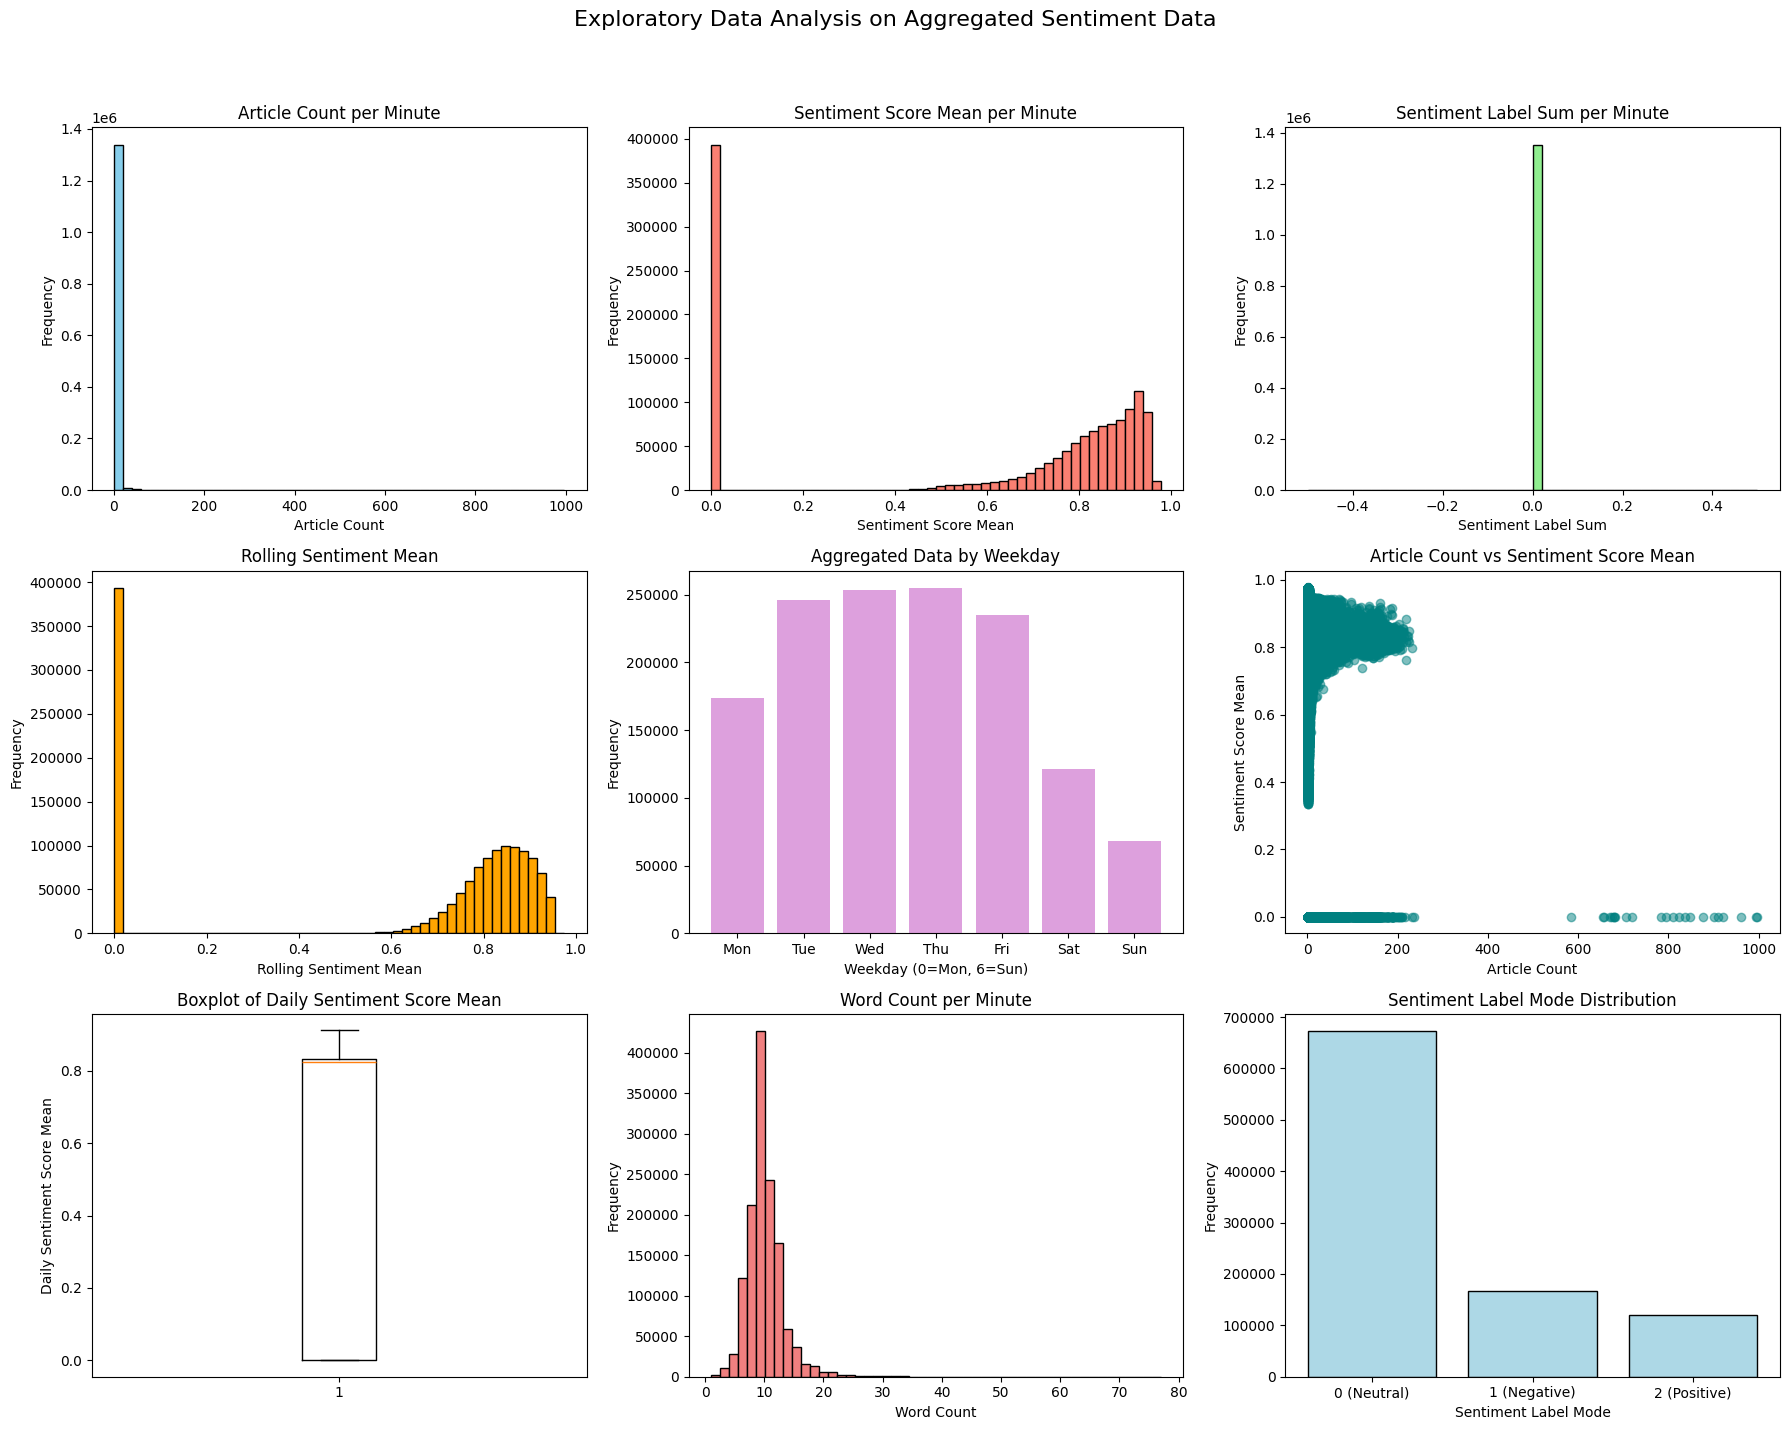

In [ ]:
def plot_final_df_distributions(final_df):
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Exploratory Data Analysis on Aggregated Sentiment Data', fontsize=16)

    # Plot 1: Distribution of article_count per minute
    axes[0, 0].hist(final_df['article_count'], bins=50, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Article Count per Minute')
    axes[0, 0].set_xlabel('Article Count')
    axes[0, 0].set_ylabel('Frequency')

    # Plot 2: Distribution of sentiment_score_mean per minute
    axes[0, 1].hist(final_df['sentiment_score_mean'], bins=50, color='salmon', edgecolor='black')
    axes[0, 1].set_title('Sentiment Score Mean per Minute')
    axes[0, 1].set_xlabel('Sentiment Score Mean')
    axes[0, 1].set_ylabel('Frequency')

    # Plot 3: Distribution of sentiment_label_sum per minute
    axes[0, 2].hist(final_df['sentiment_label_sum'], bins=50, color='lightgreen', edgecolor='black')
    axes[0, 2].set_title('Sentiment Label Sum per Minute')
    axes[0, 2].set_xlabel('Sentiment Label Sum')
    axes[0, 2].set_ylabel('Frequency')

    # Plot 4: Distribution of rolling_sentiment_mean
    axes[1, 0].hist(final_df['rolling_sentiment_mean'], bins=50, color='orange', edgecolor='black')
    axes[1, 0].set_title('Rolling Sentiment Mean')
    axes[1, 0].set_xlabel('Rolling Sentiment Mean')
    axes[1, 0].set_ylabel('Frequency')

    # Plot 5: Weekday distribution (bar chart)
    weekday_counts = final_df['weekday'].value_counts().sort_index()
    axes[1, 1].bar(weekday_counts.index, weekday_counts.values, color='plum')
    axes[1, 1].set_title('Aggregated Data by Weekday')
    axes[1, 1].set_xlabel('Weekday (0=Mon, 6=Sun)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_xticks(ticks=range(7))
    axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Plot 6: Scatter - Article Count vs Sentiment Score Mean
    axes[1, 2].scatter(final_df['article_count'], final_df['sentiment_score_mean'], alpha=0.5, color='teal')
    axes[1, 2].set_title('Article Count vs Sentiment Score Mean')
    axes[1, 2].set_xlabel('Article Count')
    axes[1, 2].set_ylabel('Sentiment Score Mean')

    # Plot 7: Boxplot of daily_sent_score_mean
    axes[2, 0].boxplot(final_df['daily_sent_score_mean'], vert=True)
    axes[2, 0].set_title('Boxplot of Daily Sentiment Score Mean')
    axes[2, 0].set_ylabel('Daily Sentiment Score Mean')

    # Remove unused axes
    axes[2, 1].hist(final_df['word_count_mean'], bins=50, color='lightcoral', edgecolor='black')
    axes[2, 1].set_title('Word Count per Minute')
    axes[2, 1].set_xlabel('Word Count')
    axes[2, 1].set_ylabel('Frequency')

    # Sentiment Label Mode Distribution (numeric x-axis)
    mode_counts = final_df['sentiment_label_mode_num'].value_counts().sort_index()
    axes[2, 2].bar(mode_counts.index, mode_counts.values, color='lightblue', edgecolor='black')
    axes[2, 2].set_title('Sentiment Label Mode Distribution')
    axes[2, 2].set_xlabel('Sentiment Label Mode')
    axes[2, 2].set_ylabel('Frequency')
    axes[2, 2].set_xticks(list(sentiment_mode_map.values()))
    axes[2, 2].set_xticklabels([f"{v} ({k.capitalize()})" for k, v in sentiment_mode_map.items()])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_final_df_distributions(final_df)

### EDA Insights on Aggregated Sentiment Data

##### Article Count per Minute
- **Description:** Frequency distribution of how many articles were published per minute.
- **Insight:** Most minutes have very few articles (typically fewer than 5), with a sharp drop-off after that. A few extreme outliers (e.g., 600–1000) may correspond to high-news-volume market events.

##### Sentiment Score Mean per Minute
- **Description:** Displays how the average FinBERT sentiment score varies by minute.
- **Insight:** Most values cluster around 0.8–0.9, indicating overall positive sentiment. The long tail toward lower values reveals occasional drops in sentiment during negative market events or bearish news cycles.

##### Sentiment Label Sum per Minute
- **Description:** Sum of sentiment labels across articles per minute.
- **Insight:** Majority of entries are close to zero, suggesting sparse or neutral sentiment. Spikes can indicate moments of strongly biased reporting (many positive/negative headlines close together in time).

##### Rolling Sentiment Mean
- **Description:** Rolling average sentiment score across a defined time window.
- **Insight:** Smooths out noise from minute-to-minute changes and helps identify overall sentiment trends. The bimodal distribution suggests there are distinct positive and neutral/bearish categories. 

##### Aggregated Data by Weekday
- **Description:** Bar plot showing article volume per weekday. 
- **Insight:** Most news volume occurs Monday to Friday, peaking midweek. Lower counts on weekends match expectations due to reduced trading and reporting.

##### Article Count vs. Sentiment Score Mean
- **Description:** Scatterplot showing how article volume relates to average sentiment.
- **Insight:** High article counts often cluster around neutral sentiment. Outliers with high sentiment and article count may point to strong market-moving events or bullish announcements.

##### Boxplot of Daily Sentiment Score Mean
- **Description:** Summarizes the distribution of sentiment per day.
- **Insight:** The median is quite high (close to 1), with a tight IQR. This suggests positive sentiment dominates the dataset, but there are some lower outliers that may indicate bearish trends.

##### Word Count per Minute
- **Description:** How many words were published across articles each minute.
- **Insight:** Most minutes have low word counts, but the long tail shows rare high-activity periods—potentially big news drops or high-frequency tweet surges.

##### Sentiment Label Mode Distribution
- **Description:** Count of the most common sentiment label (neutral, negative, or positive) per minute.
- **Insight:** Most minutes are dominated by neutral sentiment. Positive and negative sentiment clusters appear with less frequency, indicating sentiment spikes are less common but possibly more meaningful.

### Outlier Detection

Visualizing & checking for outliers in major sentiment metrics using boxplots and the IQR method (Interquartile Range). While we considered removing these, they appear to reflect natural market-driven variation and are therefore retained during modeling.

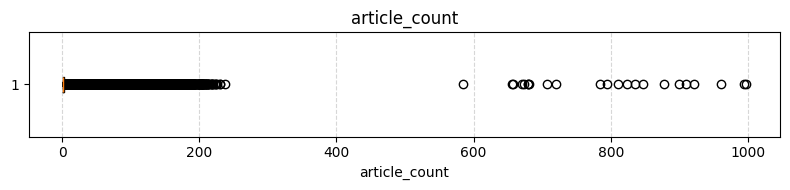

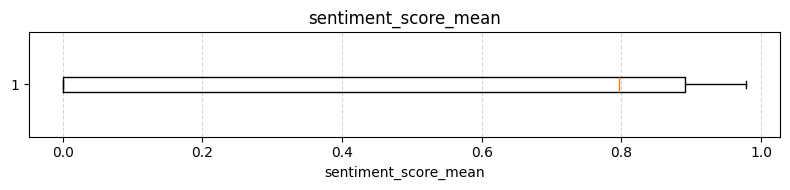

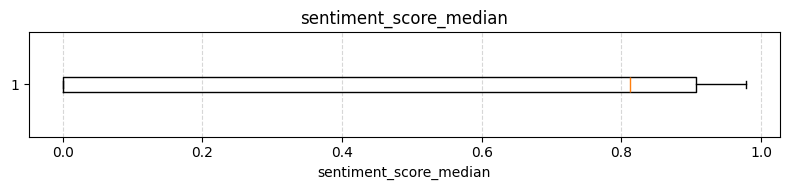

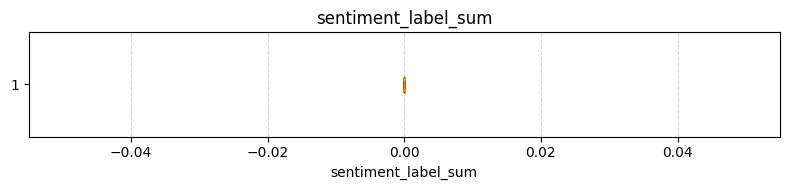

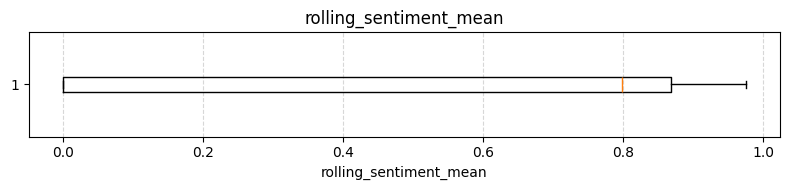

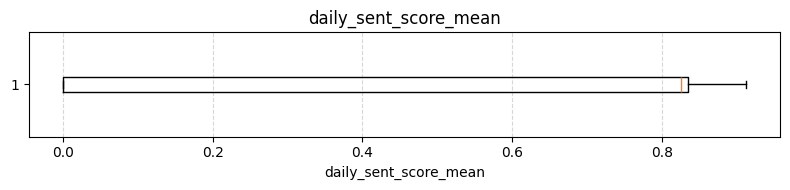

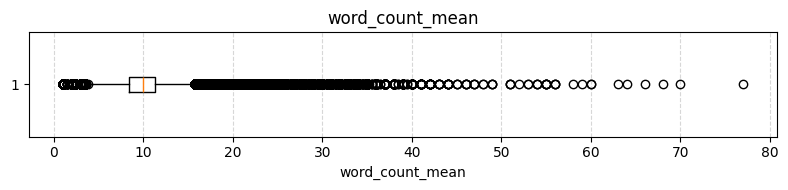

In [83]:
def detect_outliers(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

cols_to_check = [
    'article_count', 
    'sentiment_score_mean', 
    'sentiment_score_median', 
    'sentiment_label_sum', 
    'rolling_sentiment_mean',
    'daily_sent_score_mean',
    'word_count_mean'
]

def plot_boxplots(df, cols, figsize=(8, 2)):
    for col in cols:
        plt.figure(figsize=figsize)
        plt.boxplot(df[col], vert=False)
        plt.title(f'{col}')
        plt.xlabel(col)
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

plot_boxplots(final_df, cols_to_check)


### Saving & Reloading Engineered News Features

Once the final news df (`final_df`) has been fully processed and indexed by ID, we serialize it to a Parquet file for efficient storage and future reuse. Parquet is a highly optimized format for large datasets and is ideal for iterative machine learning workflows.

After saving, we reload the data to validate the structure, re-parse the datetime index, and reassign a proper `datetime` index for use in time-series modeling. This ensures that the data is chronologically ordered and ready for merging with price-based features during the model training phase.


In [ ]:
final_df = final_df.set_index('id')

In [ ]:
agg_news_features_df = final_df

agg_news_parquet_path = os.path.join(PROCESSED_DATA, "aggregated_news_with_features.parquet")

agg_news_features_df.to_parquet(agg_news_parquet_path, index=True, compression="snappy")

In [4]:
agg_news_features_df = pd.read_parquet(agg_news_parquet_path)

agg_news_features_df.index = pd.to_datetime(
    agg_news_features_df.index, format="%Y%m%d%H%M", errors='coerce'
)

agg_news_features_df['datetime'] = pd.to_datetime(agg_news_features_df['id'], format="%Y%m%d%H%M", errors='coerce')
agg_news_features_df = agg_news_features_df.set_index('datetime')

agg_news_features_df = agg_news_features_df.sort_index()

## Monthly Sentiment Distribution Analysis

In this section, we look at how sentiment has evolved over time by aggregating sentiment labels (`-1.0` = Negative, `0.0` = Neutral, `1.0` = Positive) at a **monthly** time frame.

### Full Monthly Sentiment Distribution
The first chart shows the full monthly sentiment distribution across all available data. Each color represents a sentiment class, with the height of the bars showing the count of news articles for that sentiment in each month.

**Key Observations:**
- Neutral sentiment (yellow) overwhelmingly dominates the dataset, especially in later months.
- Positive sentiment (green) appears more frequently in the early years, while negative sentiment (red) spikes in some earlier months.
- Data availability seems to drop off significantly after 2015. The reason for this cutoff isn't fully known, but it may relate to limitations in the original news dataset.

### Filtered Distribution (Valid Sentiment Period)
To ensure high-quality input for our models, we filter the data to retain only months where **all three sentiment classes were represented**. This helps us avoid class imbalance issues and ensures sentiment diversity over time.

**Filtering Criteria:**
- Each month must include at least one article labeled negative, neutral, and positive.
- The final dataset spans from the earliest available month through one month before the last complete sentiment month, based on this criteria.

**Why it matters:**
- This refined distribution gives a clearer and more balanced view of sentiment trends over time.
- It’s crucial for training our sentiment regression models to avoid bias toward a single class.

> While this filtering improves quality, it reduces time factor to consider when aligning sentiment signals with price data.

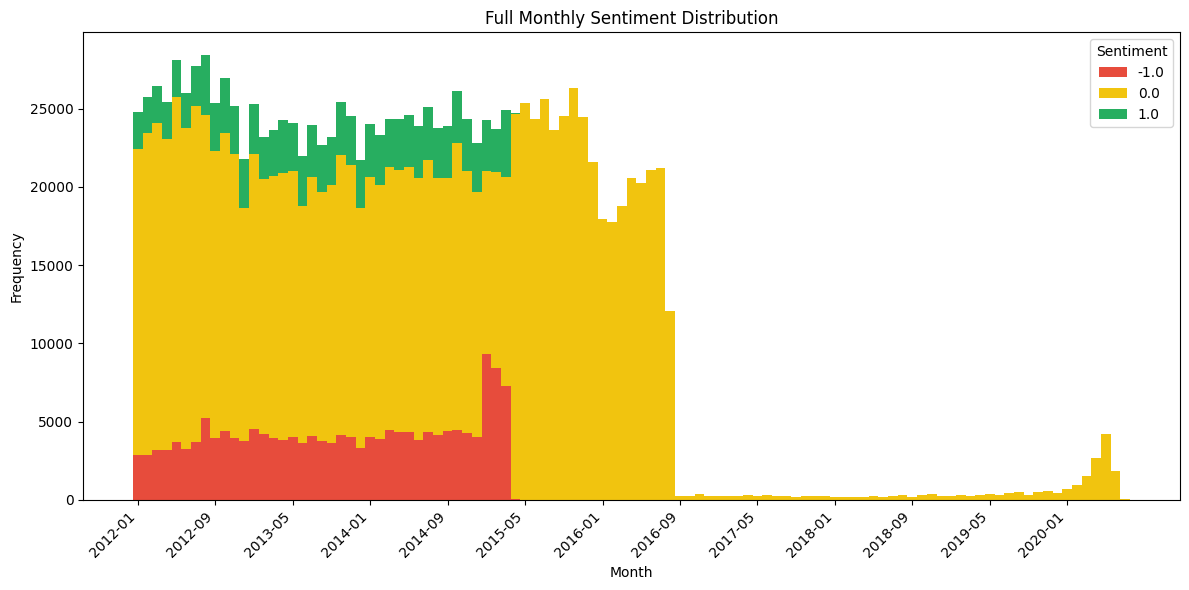

In [17]:
# Monthly sentiment
monthly_counts = agg_news_features_df.resample("M")["sentiment_label_mode_num"] \
    .value_counts() \
    .unstack(fill_value=0)

def plot_monthly_sentiment_distribution(monthly_df, title="Monthly Sentiment Distribution"):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(monthly_df.index))
    bottom = np.zeros(len(x))
    colors = ['#e74c3c', '#f1c40f', '#27ae60'] 

    for i, col in enumerate(monthly_df.columns):
        vals = monthly_df[col].values
        ax.bar(x, vals, bottom=bottom, color=colors[i % len(colors)], width=1.0, label=str(col))
        bottom += vals

    xtick_spacing = max(1, len(x) // 12) 
    xticks = x[::xtick_spacing]
    xtick_labels = [ts.strftime('%Y-%m') for ts in monthly_df.index[::xtick_spacing]]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Frequency")
    ax.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

# Plot for the full dataset
plot_monthly_sentiment_distribution(monthly_counts, title="Full Monthly Sentiment Distribution")

Lower bound: 2012-01-31 00:00:00
Upper bound: 2015-03-31 00:00:00


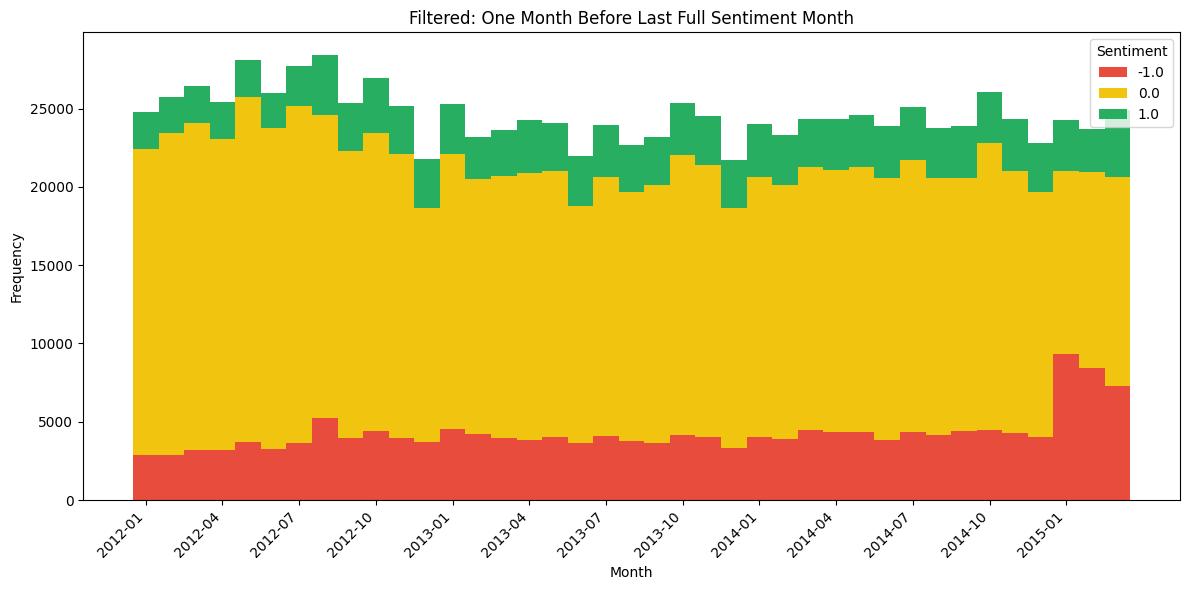

In [18]:
required_labels = [-1.0, 0.0, 1.0]
has_all_three = (monthly_counts[required_labels] > 0).all(axis=1)
last_valid_month = monthly_counts[has_all_three].index[-2]
monthly_counts_filtered = monthly_counts.loc[:last_valid_month]

lower_bound = monthly_counts_filtered.index[0]
upper_bound = monthly_counts_filtered.index[-1]

print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

plot_monthly_sentiment_distribution(
    monthly_counts_filtered,
    title="Filtered: One Month Before Last Full Sentiment Month"
)

In [19]:
agg_news_filtered = agg_news_features_df.loc[lower_bound:upper_bound]

# Step 4: Save the filtered news data
realistic_parquet_path = os.path.join(PROCESSED_DATA, "aggregated_realistic_news_with_features_filtered.parquet")
agg_news_filtered.to_parquet(realistic_parquet_path, index=True, compression="snappy")

print(f"Saved filtered news data to: {realistic_parquet_path}")

Saved filtered news data to: data\processed-data\aggregated_realistic_news_with_features_filtered.parquet


In [1]:
import os


# Environment configuration for a clean Jupyter environment with minimal logs and GPU setup.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "3"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_TRT_ALLOW_ENGINE_NATIVE_SEGMENT_EXECUTION"] = "false"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GRPC_CPP_LOG_LEVEL"] = "ERROR"

# Set visible GPU devices before importing TensorFlow
USE_ONLY_GPU_INDEX = 0
from tensorflow.python.framework import config as tf_config

physical_devices = tf_config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf_config.set_visible_devices(physical_devices[USE_ONLY_GPU_INDEX], 'GPU')
        tf_config.set_memory_growth(physical_devices[USE_ONLY_GPU_INDEX], True)
    except RuntimeError as e:
        print("GPU config error:", e)
else:
    raise RuntimeError("No GPU found!")

# Import TensorFlow and silence warnings
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

print("GPUs available:", tf.config.list_logical_devices('GPU'))

GPUs available: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [396]:
import os
import time
import io
import re
from pathlib import Path
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load, dump
from backtesting import Backtest, Strategy
from bokeh.io import show, output_notebook, save, reset_output
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, MultiHeadAttention, Dropout, LayerNormalization, GlobalAveragePooling1D, Dense, Conv1D, MaxPooling1D, Flatten, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from datetime import datetime
import markdown
from IPython.utils import io

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')




from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

import glob



In [3]:
PROCESSED_DATA = os.path.join("data", "processed-data")
RESULT_DATA_DIR = os.path.join("model-result-data")

In [4]:
# File paths for saving results
os.makedirs(RESULT_DATA_DIR, exist_ok=True)

## Data

In [5]:
def create_target_df(features_df, asset_label):
    target_df = pd.DataFrame(index=features_df.index)
    target_df[f'{asset_label}_Close_1m_later'] = features_df['Close'].shift(-1)
    target_df.dropna(inplace=True)
    return target_df


In [6]:
def extract_target_df(features_df, label = "target"):
    if label not in features_df.columns:
        raise ValueError(f"Label column '{label}' not found in DataFrame. Available columns: {list(features_df.columns)}")
    target_df = features_df[[label]].copy()
    features_df = features_df.drop(columns=[label])
    return features_df, target_df

In [7]:

def _clean(df, tz="UTC"):
    for c in ("minute_id", "Date_dt", "datetime", "timestamp"):
        if c in df.columns:
            df = df.rename(columns={c: "date"})
            break
    if pd.api.types.is_integer_dtype(df["date"]):
        df["date"] = pd.to_datetime(
            df["date"].astype(str), format="%Y%m%d%H%M", utc=True, errors="coerce"
        )
    else:
        df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")
    df = df.set_index("date").sort_index()
    return df.tz_convert(tz) if tz else df

In [8]:
def crypto_data_io(
    asset,
    action="load",
    fmt="auto",
    root=PROCESSED_DATA,
    tz="UTC",
    engine="pyarrow",
):
    asset = asset.lower()
    csv_file = os.path.join(root, f"{asset}_1min_with_features.csv.gz")
    pq_file = os.path.join(root, f"{asset}_1min_with_features.parquet")

    if fmt == "auto":
        fmt = "parquet" if os.path.exists(pq_file) else "csv"

    if action == "load":
        if fmt == "parquet":
            df = pd.read_parquet(pq_file, engine=engine)
        elif fmt == "csv":
            df = pd.read_csv(csv_file, compression="gzip")
        else:
            raise ValueError
        df = _clean(df, tz=tz)

    elif action == "save":
        df = _clean(pd.read_csv(csv_file, compression="gzip"), tz=tz)
        if fmt == "parquet":
            df.to_parquet(pq_file, index=True, compression="snappy", engine=engine)
        elif fmt == "csv":
            clean_csv = os.path.splitext(csv_file)[0] + ".clean.csv.gz"
            df.to_csv(clean_csv, compression="gzip")
        else:
            raise ValueError
    else:
        raise ValueError

    return df, create_target_df(df, asset)

In [9]:
btc_df_features, btc_targets = crypto_data_io("btc", action="load")

In [10]:
eth_df_features, eth_targets = crypto_data_io("eth", action="load")


## Constants & Functions

In [11]:

def setup_directories():
    os.makedirs("plots", exist_ok=True)
    os.makedirs("models", exist_ok=True)
    os.makedirs("logs", exist_ok=True)
    return "Done"

In [12]:
def get_data_subset(features_df, targets_df, target_col, data_percent=0.01):
    # Intersect indices from features_df and targets_df, sorted
    common_index = features_df.index.intersection(targets_df.index).sort_values()
    
    subset_size = int(len(common_index) * data_percent)
    subset_dates = common_index[:subset_size]

    print("Total data values in intersection:", len(common_index))
    print("Number of data points to use:", subset_size)

    X = features_df.loc[subset_dates].copy()
    y = targets_df.loc[subset_dates, target_col].copy()

    # Create a combined subset dataframe
    subset = X.copy()
    subset[target_col] = y

    # Convert string index in the form YYYYMMDDHHMM to datetime
    date_series = pd.to_datetime(subset.index, format='%Y%m%d%H%M')

    subset.index = date_series
    X.index = date_series

    # Print diagnostic info
    print("Start of subset:", date_series[0] if not date_series.empty else "N/A")
    print("End of subset:", date_series[-1] if not date_series.empty else "N/A")

    return X, y, subset, date_series

In [13]:
def scale_features(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler


In [14]:

def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    indices = []  # will store i+time_steps for labeling
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
        indices.append(i + time_steps)
    return np.array(Xs), np.array(ys), np.array(indices)


In [37]:
def train_test_split_sequences(X_seq, y_seq, indices, train_ratio=0.8):
    train_size = int(len(X_seq) * train_ratio)

    X_train = X_seq[:train_size]
    y_train = y_seq[:train_size]
    idx_train = indices[:train_size]

    X_test  = X_seq[train_size:]
    y_test  = y_seq[train_size:]
    idx_test = indices[train_size:]

    return X_train, y_train, X_test, y_test, idx_train, idx_test

def format_percent_string(p):
    return f"{p * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")

In [16]:
def train_model(model, X_train, y_train, X_val, y_val, data_percent=0.01, epochs=20, model_name="model", asset="btc"):
    
    percent_display = format_percent_string(data_percent)
    model_prefix = f"{model_name}_{asset.lower()}"
    
    model_filename = f"{model_prefix}_model_{percent_display}pct.h5"
    log_filename = f"{model_prefix}_log_{percent_display}pct.csv"

    checkpoint = ModelCheckpoint(os.path.join("models", model_filename), monitor="val_loss", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    csv_logger = CSVLogger(os.path.join("logs", log_filename))

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, early_stop, csv_logger],
        verbose=1
    )
    return history

In [17]:
def print_metrics(y_test, y_pred, *, data_percent=0.01,
                  model_name="model", dataset_name="asset"):
    import os, pandas as pd, numpy as np
    from sklearn.metrics import (accuracy_score, precision_score,
                                 recall_score, f1_score,
                                 mean_squared_error, mean_absolute_error)

    test_sig = np.sign(np.diff(y_test.ravel()))
    pred_sig = np.sign(np.diff(y_pred.ravel()))

    acc  = accuracy_score(test_sig, pred_sig)
    prec = precision_score(test_sig, pred_sig, average='macro')
    rec  = recall_score(test_sig, pred_sig, average='macro')
    f1   = f1_score(test_sig, pred_sig, average='macro')
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)

    print(f"{data_percent*100:.1f}% | acc {acc:.4f}  prec {prec:.4f}  "
          f"rec {rec:.4f}  f1 {f1:.4f}  mse {mse:.4f}  rmse {rmse:.4f}  mae {mae:.4f}")

    os.makedirs(RESULT_DATA_DIR, exist_ok=True)
    fname = f"{dataset_name}_{model_name}_{format_percent_string(data_percent)}pct_metrics.csv"
    pd.DataFrame([dict(dataset=dataset_name, model=model_name,
                       data_pct=data_percent, accuracy=acc, precision=prec,
                       recall=rec, f1=f1, mse=mse, rmse=rmse, mae=mae)]
                ).to_csv(os.path.join(RESULT_DATA_DIR, fname), index=False)

In [18]:
def plot_loss(history, plots_dir="plots", data_percent=0.01, model_name="gru", dataset_name="btc"):
    # Ensure the directory exists
    os.makedirs(plots_dir, exist_ok=True)

    # Format percent strings
    percent_display_filename = format_percent_string(data_percent) 
    percent_display_title = f"{data_percent * 100:.2f}"

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Loss Curve | Model: {model_name.upper()} | Dataset: {dataset_name.upper()} | Data: {percent_display_title}%")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.legend()
    plt.grid(True)

    # Save plot
    filename = f"loss_curve_{model_name}_{dataset_name}_{percent_display_filename}pct.png"
    loss_curve_path = os.path.join(plots_dir, filename)
    plt.savefig(loss_curve_path)
    plt.show()

    print(f"Loss curve saved to: {loss_curve_path}")


In [19]:
def plot_predictions(y_test, y_pred, date_series=None, plots_dir="plots", data_percent=0.01,
                     model_name="gru", dataset_name="btc", last_n=200):

    # Ensure directories exist
    os.makedirs(plots_dir, exist_ok=True)
    os.makedirs(RESULT_DATA_DIR, exist_ok=True)

    # Fallback for date series
    if date_series is None:
        date_series = pd.RangeIndex(start=0, stop=len(y_test))

    # Format percent display
    percent_display_filename = format_percent_string(data_percent)
    percent_display_title = f"{data_percent * 100:.2f}"

    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        "Date": date_series,
        "Actual": y_test,
        "Predicted": y_pred.flatten()
    })

    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(comparison_df["Date"].iloc[-last_n:], comparison_df["Actual"].iloc[-last_n:], label="Actual")
    plt.plot(comparison_df["Date"].iloc[-last_n:], comparison_df["Predicted"].iloc[-last_n:], label="Predicted", linestyle="--")
    plt.title(f"{dataset_name.upper()} Prediction | Model: {model_name.upper()} | Data: {percent_display_title}% | Last {last_n} Samples")
    plt.xlabel("Date" if date_series is not None else "Index")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)

    # Save plot
    filename = f"prediction_plot_{model_name}_{dataset_name}_{percent_display_filename}pct.png"
    plot_path = os.path.join(plots_dir, filename)
    plt.savefig(plot_path)
    plt.show()
    print(f"Prediction plot saved to: {plot_path}")

    # Save comparison CSV
    result_file = os.path.join(RESULT_DATA_DIR, f"{model_name}_{dataset_name}_{percent_display_filename}pct_comparison.csv")
    comparison_df.to_csv(result_file, index=False)
    print(f"Comparison CSV saved to: {result_file}")

    return comparison_df


In [20]:
def save_model_and_scaler(model, scaler, model_name: str, dataset_name: str, data_percent: float, model_ext: str = "h5"):
    os.makedirs("models", exist_ok=True)
    percent_str = f"{data_percent * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")
    model_filename = f"{model_name}_{dataset_name}_model_{percent_str}pct.{model_ext}"
    scaler_filename = f"{model_name}_{dataset_name}_scaler_{percent_str}pct.pkl"

    model_path = Path("models") / model_filename
    scaler_path = Path("models") / scaler_filename

    if model_ext in ['h5', 'keras']:
        save_model(model, str(model_path))
    else:
        dump(model, model_path)

    dump(scaler, scaler_path)

    print("Model saved to:", model_path.resolve().relative_to(Path.cwd()))
    print("Scaler saved to:", scaler_path.resolve().relative_to(Path.cwd()))


In [21]:
def load_model_and_scaler(model_name: str, dataset_name: str, data_percent: float, model_ext: str = "h5"):
    percent_str = f"{data_percent * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")

    model_filename = f"{model_name}_{dataset_name}_model_{percent_str}pct.{model_ext}"
    scaler_filename = f"{model_name}_{dataset_name}_scaler_{percent_str}pct.pkl"

    model_path = Path("models") / model_filename
    scaler_path = Path("models") / scaler_filename

    if model_ext in ['h5', 'keras']:
        model = load_model(model_path)
    else:
        model = load(model_path)

    scaler = load(scaler_path)

    print("Model loaded from:", model_path.resolve().relative_to(Path.cwd()))
    print("Scaler loaded from:", scaler_path.resolve().relative_to(Path.cwd()))

    return model, scaler

In [22]:
class MLStrategy(Strategy):
    stop_loss_pct = 0.0
    def init(self):
        self.signal = self.data.Signal
        num_pos_signals = int((self.signal == 1).sum())
        num_neg_signals = int((self.signal == -1).sum())
        print(f"Found {num_pos_signals} +1 signals and {num_neg_signals} -1 signals in the data.")
        self.opened_first_time = False

    def next(self):
        # Get the current bar's index and use it to fetch the full data (OHLC and Signal) from the original DataFrame.
        current_idx = self.data.index[-1]
        current_close = self.data.df.loc[current_idx, 'Close']
        current_signal = self.data.df.loc[current_idx, 'Signal']
        current_profit = 0.0
        if self.position and hasattr(self, 'my_entry_price'):
            if self.position.is_long:
                current_profit = current_close - self.my_entry_price
            elif self.position.is_short:
                current_profit = self.my_entry_price - current_close
    
        # 1) For the first trade: only enter when the signal is +1.
        if not self.opened_first_time:
            if current_signal == 1:
                self.opened_first_time = True
                if self.stop_loss_pct > 0:
                    stop_loss_price = current_close * (1 - self.stop_loss_pct)
                    self.buy(sl=stop_loss_price)
                else:
                    self.buy()
                # Record our entry price for subsequent profit calculations.
                self.my_entry_price = current_close
            return  # Exit early until first trade is taken.
    
        # 2) For subsequent bars, adjust positions based on the signal.
        if current_signal == 1:
            # If not currently long, flip to long (close any short and go long).
            if not self.position.is_long:
                self.position.close()
                if self.stop_loss_pct > 0:
                    stop_loss_price = current_close * (1 - self.stop_loss_pct)
                    self.buy(sl=stop_loss_price)
                else:
                    self.buy()
                # Update the entry price after the trade is executed.
                self.my_entry_price = current_close
    
        elif current_signal == -1:
            # Only reverse to short if there's an open long position that is already in profit.
            if self.position and self.position.is_long and current_profit > 0:
                self.position.close()
                if self.stop_loss_pct > 0:
                    stop_loss_price = current_close * (1 + self.stop_loss_pct)
                    self.sell(sl=stop_loss_price)
                else:
                    self.sell()
                # Update the entry price for the new short position.
                self.my_entry_price = current_close

    def stop(self):
        # Force-close any open position at the end of the backtest
        self.position.close()


In [23]:
# def save_interactive_chart(bt_ ,html_filename):
#     with io.capture_output():
#         plot_obj = bt_.plot()
#     save(plot_obj, filename=html_filename)
#     print("Interactive chart saved to:", html_filename)

from IPython.utils import io as ipy_io

def save_interactive_chart(bt_, html_filename):
    with ipy_io.capture_output() as captured:
        plot_obj = bt_.plot()
    save(plot_obj, filename=html_filename)


In [24]:
def run_backtest(
    df_bt,
    initial_cash=10_000,
    model_name="gru",
    dataset_name="btc",
    data_percent=0.01,
    stop_loss_pct=0.0
):
    print("Setting up Backtest object...")
    bt = Backtest(
        df_bt,
        MLStrategy,
        cash=initial_cash,
        commission=0.0,
        exclusive_orders=True
    )
    
    print("Running backtest engine...")
    stats = bt.run(stop_loss_pct=stop_loss_pct)
    print(stats)
    
    trades_df = getattr(stats, 'trades', None) or getattr(stats, '_trades', None)
    if trades_df is not None:
        n_trades = len(trades_df)
        n_closed_trades = trades_df['ExitPrice'].notna().sum()
        n_open_trades = trades_df['ExitPrice'].isna().sum()
        
        print("\nTrade Details:")
        print(f"Number of trades:       {n_trades}")
        print(f"Number of closed trades:{n_closed_trades}")
        print(f"Number of open trades:  {n_open_trades}")
    
    print("Saving backtest plot to HTML...")
    from bokeh.io import save
    import os
    
    # Format stop loss as percentage string for filenames
    stop_str = format_percent_string(stop_loss_pct)  # e.g. 0.025 becomes 'sl0025'
    result_dir = os.path.join(
        "results",
        f"{model_name}_{dataset_name}_{format_percent_string(data_percent)}pct_{stop_str}stloss"
    )
    os.makedirs(result_dir, exist_ok=True)
    #have to save this outside, as this was making the notebook crash
    html_filename = os.path.join(result_dir, "backtest_plot.html")
    save_interactive_chart(bt, html_filename)
    csv_filename = os.path.join(result_dir, "backtest_stats.csv")
    stats.to_csv(csv_filename)
    print("Backtest stats saved to:", csv_filename)
    return stats

## Initial Testing - Model Pipeline

Some of the functions differ from the initial testing, as they were updated.

In [17]:
# Variables for initial testing

DATA_PERCENT = 0.001
TIME_STEPS = 30
TARGET_COL = "btc_Close_1m_later"


In [18]:
setup_directories()

'Done'

In [33]:
X_raw, y_raw, btc_subset, date_series = get_data_subset(btc_df_features, btc_targets, TARGET_COL, DATA_PERCENT)


Total data values in intersection: 6283462
Number of data points to use: 6283
Start of subset: 2012-01-31 10:45:00+00:00
End of subset: 2012-03-27 18:37:00+00:00


In [34]:
X_scaled, scaler = scale_features(X_raw)


In [36]:
X_seq, y_seq, seq_indices = create_sequences(X_scaled, y_raw.values, TIME_STEPS)

In [40]:
X_train, y_train, X_test, y_test, idx_train, idx_test = train_test_split_sequences(X_seq, y_seq, seq_indices)

In [41]:
model = build_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))

In [42]:
history = train_model(model, X_train, y_train, X_test, y_test, DATA_PERCENT)

Epoch 1/20
149/157 [===========================>..] - ETA: 0s - loss: 1.4194
Epoch 1: val_loss improved from inf to 0.00846, saving model to models\model_btc_model_0_1pct.h5
157/157 [==============================] - 19s 11ms/step - loss: 1.3627 - val_loss: 0.0085
Epoch 2/20
155/157 [============================>.] - ETA: 0s - loss: 0.1745
Epoch 2: val_loss improved from 0.00846 to 0.00725, saving model to models\model_btc_model_0_1pct.h5
157/157 [==============================] - 1s 6ms/step - loss: 0.1748 - val_loss: 0.0072
Epoch 3/20
155/157 [============================>.] - ETA: 0s - loss: 0.1398
Epoch 3: val_loss did not improve from 0.00725
157/157 [==============================] - 1s 6ms/step - loss: 0.1396 - val_loss: 0.0107
Epoch 4/20
148/157 [===========================>..] - ETA: 0s - loss: 0.1309
Epoch 4: val_loss did not improve from 0.00725
157/157 [==============================] - 1s 5ms/step - loss: 0.1311 - val_loss: 0.0123
Epoch 5/20
150/157 [======================

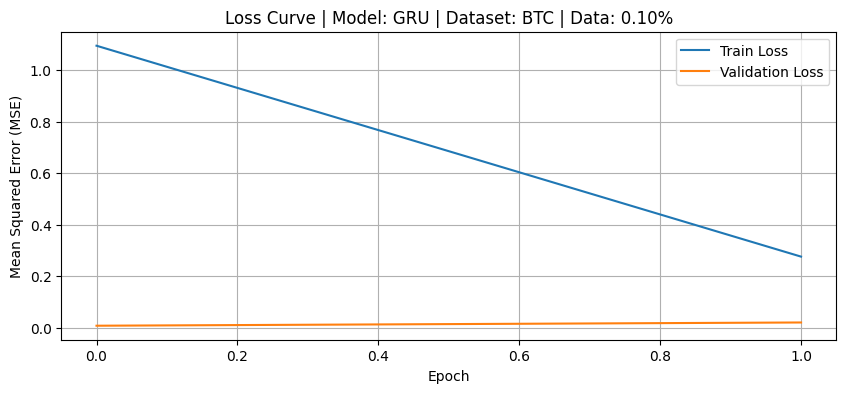

Loss curve saved to: plots\loss_curve_gru_btc_0_1pct.png


In [124]:
plot_loss(history, data_percent=DATA_PERCENT, model_name="gru", dataset_name="btc")

In [44]:
y_pred = model.predict(X_test)

40/40 [==============================] - 0s 5ms/step


In [78]:
len(y_test)

1251

In [77]:
len(date_series)

6283

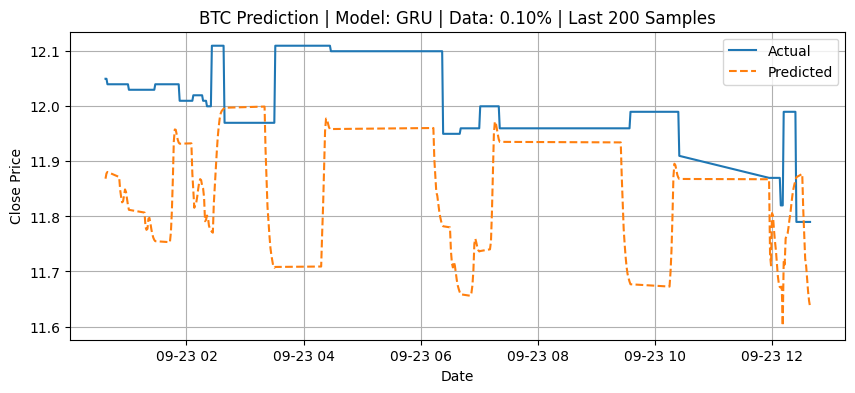

Prediction plot saved to: plots\prediction_plot_gru_btc_0_1pct.png
Comparison CSV saved to: model-result-data\gru_btc_comparison_0_1pct.csv


In [126]:
comparison_df = plot_predictions(
    y_test, 
    y_pred, 
    date_series=date_series[idx_test], 
    data_percent=DATA_PERCENT, 
    model_name="gru", 
    dataset_name="btc"
)


In [83]:
print_metrics(y_test, y_pred, data_percent = DATA_PERCENT, model_name="gru", dataset_name="btc")

0.1% | acc 0.0504  prec 0.0344  rec 0.3315  f1 0.0621  mse 0.0065  rmse 0.0808  mae 0.0679


In [84]:
save_model_and_scaler(model, scaler, model_name="gru", dataset_name="btc", data_percent=DATA_PERCENT)

Model saved to: models\gru_btc_model_0_1pct.h5
Scaler saved to: models\gru_btc_scaler_0_1pct.pkl


In [85]:
model, scaler = load_model_and_scaler(model_name="gru", dataset_name="btc", data_percent=DATA_PERCENT)

Model loaded from: models\gru_btc_model_0_1pct.h5
Scaler loaded from: models\gru_btc_scaler_0_1pct.pkl


In [88]:
signals = np.sign(np.diff(y_pred.flatten(), prepend=y_pred.flatten()[0]))
signals[signals == 0] = 1

# Construct df_bt
df_bt = pd.DataFrame({
    'Open': y_test.flatten(),
    'High': y_test.flatten(),
    'Low': y_test.flatten(),
    'Close': y_test.flatten(),
    'Signal': signals,
}, index=date_series[idx_test])


In [91]:

# Call backtest properly
stats = run_backtest(
    df_bt,
    initial_cash=100_000,
    model_name="gru",
    dataset_name="btc",
    data_percent=DATA_PERCENT
)


Setting up Backtest object...
Running backtest engine...
Found 701 +1 signals and 550 -1 signals in the data.


Start                     2012-03-16 00:59...
End                       2012-03-27 18:37...
Duration                     11 days 17:38:00
Exposure Time [%]                    12.78977
Equity Final [$]                     88661.93
Equity Peak [$]                     100743.48
Return [%]                          -11.33807
Buy & Hold Return [%]               -11.33829
Return (Ann.) [%]                   -97.70214
Volatility (Ann.) [%]                 1.22636
CAGR [%]                            -97.63188
Sharpe Ratio                        -79.66822
Sortino Ratio                        -2.03444
Calmar Ratio                         -6.01768
Alpha [%]                            -0.00002
Beta                                  0.99998
Max. Drawdown [%]                   -16.23585
Avg. Drawdown [%]                    -4.61601
Max. Drawdown Duration        9 days 03:33:00
Avg. Drawdown Duration        2 days 05:05:00
# Trades                                    8
Win Rate [%]                      

## Testing - Putting it all together

In [93]:
asset="btc" 
model_function=build_gru_model
model_name="gru"
data_percent= 0.01
initial_cash=100_000 
epochs=2
time_steps = 30
targets_df = btc_targets
features_df= btc_df_features

Loading data for asset: btc
Total data values in intersection: 6283462
Number of data points to use: 62834
Start of subset: 2012-01-31 10:45:00+00:00
End of subset: 2012-09-23 12:39:00+00:00
Data subset shape: (62834, 44), (62834,)
Extracting OHLC columns...
Normalizing features...
Creating sequences...
Total sequences created: 62804
Splitting data into training and testing sets...
Train size: (50243, 30, 40), Test size: (12561, 30, 40)
Building model...
Training model...
Epoch 1/2
1570/1571 [============================>.] - ETA: 0s - loss: 1.0944
Epoch 1: val_loss improved from inf to 0.00843, saving model to models\gru_btc_model_1pct.h5
1571/1571 [==============================] - 10s 6ms/step - loss: 1.0943 - val_loss: 0.0084
Epoch 2/2
1565/1571 [============================>.] - ETA: 0s - loss: 0.2762
Epoch 2: val_loss did not improve from 0.00843
1571/1571 [==============================] - 8s 5ms/step - loss: 0.2764 - val_loss: 0.0210
Plotting training loss...


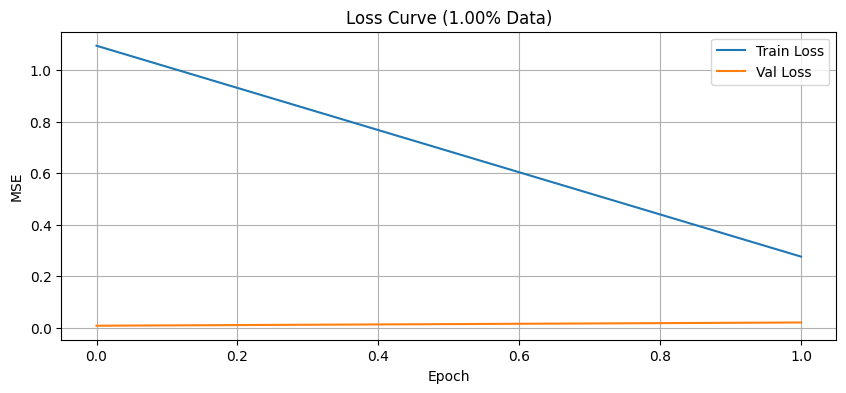

Loss curve saved to: plots\loss_curve_gru_btc_1pct.png
Generating predictions...
393/393 [==============================] - 1s 2ms/step
Predictions shape: (12561, 1)
Plotting predictions and saving comparison CSV...
Prediction plot saved to: plots\prediction_plot_gru_btc_1pct.png


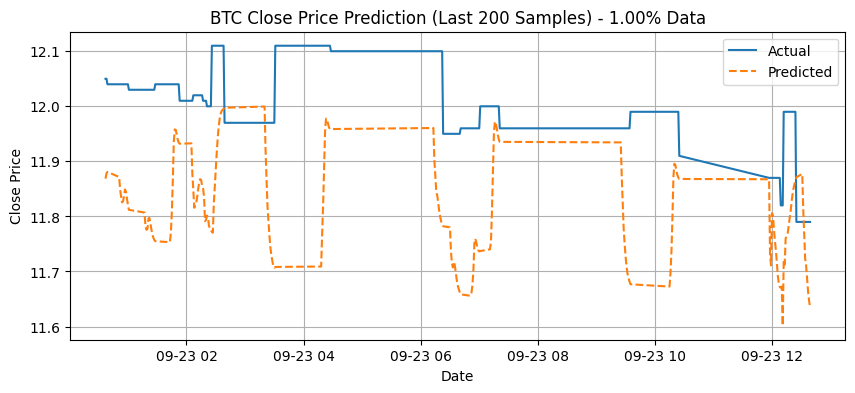

Comparison CSV saved to: model-result-data\gru_btc_comparison_1pct.csv
Printing evaluation metrics...
1.0% | acc 0.0575  prec 0.3708  rec 0.3044  f1 0.0666  mse 0.0210  rmse 0.1449  mae 0.1225
Saving model and scaler...
Model saved to: models\gru_btc_model_1pct.h5
Scaler saved to: models\gru_btc_scaler_1pct.pkl
Running backtest...
Setting up Backtest object...
Running backtest engine...
Found 5208 +1 signals and 7353 -1 signals in the data.


Start                     2012-08-28 02:48...
End                       2012-09-23 12:39...
Duration                     26 days 09:51:00
Exposure Time [%]                    89.10915
Equity Final [$]                    107747.09
Equity Peak [$]                     115247.46
Return [%]                            7.74709
Buy & Hold Return [%]                  9.3692
Return (Ann.) [%]                    64.19386
Volatility (Ann.) [%]                82.08911
CAGR [%]                            180.44943
Sharpe Ratio                            0.782
Sortino Ratio                          1.9067
Calmar Ratio                          4.18397
Alpha [%]                            -1.45957
Beta                                  0.98265
Max. Drawdown [%]                   -15.34281
Avg. Drawdown [%]                     -1.7583
Max. Drawdown Duration       15 days 05:34:00
Avg. Drawdown Duration        0 days 16:34:00
# Trades                                   80
Win Rate [%]                      

In [108]:
setup_directories()

# Constants
asset = "btc"
target_col = f"{asset}_Close_1m_later"

print(f"Loading data for asset: {asset}")

X_raw, y_raw, merged_subset, date_series = get_data_subset(
    features_df, targets_df, target_col, data_percent
)

print(f"Data subset shape: {X_raw.shape}, {y_raw.shape}")

# Extract real OHLC before scaling
print("Extracting OHLC columns...")
df_ohlc = merged_subset[["Open", "High", "Low", "Close"]].copy()

# Drop OHLC columns from X_raw if they shouldn't be scaled
X_no_ohlc = X_raw.drop(columns=["Open", "High", "Low", "Close"], errors='ignore')

print("Normalizing features...")
X_scaled, scaler = scale_features(X_no_ohlc)

print("Creating sequences...")
X_seq, y_seq, seq_indices = create_sequences(X_scaled, y_raw.values, time_steps)
print(f"Total sequences created: {len(X_seq)}")

print("Splitting data into training and testing sets...")
X_train, y_train, X_test, y_test, idx_train, idx_test = train_test_split_sequences(X_seq, y_seq, seq_indices)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

print("Building model...")
model = model_function(input_shape=(X_train.shape[1], X_train.shape[2]))

print("Training model...")
history = train_model(model, X_train, y_train, X_test, y_test, data_percent, epochs, model_name=model_name, asset=asset)

print("Plotting training loss...")
plot_loss(history, data_percent=data_percent, model_name=model_name, dataset_name=asset)

print("Generating predictions...")
y_pred = model.predict(X_test)
print(f"Predictions shape: {y_pred.shape}")

print("Plotting predictions and saving comparison CSV...")
comparison_df = plot_predictions(
    y_test,
    y_pred,
    date_series=date_series[idx_test],
    data_percent=data_percent,
    model_name=model_name,
    dataset_name=asset
)

print("Printing evaluation metrics...")
print_metrics(y_test, y_pred, data_percent=data_percent, model_name=model_name, dataset_name=asset)

print("Saving model and scaler...")
save_model_and_scaler(model, scaler, model_name=model_name, dataset_name=asset, data_percent=data_percent)

# Backtesting Preparation
signals = np.sign(np.diff(y_pred.flatten(), prepend=y_pred.flatten()[0]))
signals[signals == 0] = 1

# Prepare dataframe for backtesting
df_bt = pd.DataFrame({
    'Open': df_ohlc.iloc[idx_test]['Open'],
    'High': df_ohlc.iloc[idx_test]['High'],
    'Low': df_ohlc.iloc[idx_test]['Low'],
    'Close': df_ohlc.iloc[idx_test]['Close'],
    'Signal': signals
}, index=date_series[idx_test])

print("Running backtest...")
stats = run_backtest(
    df_bt,
    initial_cash=initial_cash,
    model_name=model_name,
    dataset_name=asset,
    data_percent=data_percent
)

print("Pipeline completed successfully.")


In [99]:
df_ohlc_test = df_ohlc.iloc[idx_test].copy()

temp_df = df_ohlc_test[['Close']].copy()
temp_df['y_pred'] = y_pred.flatten()
temp_df['diff'] = temp_df['y_pred'] - temp_df['Close']
temp_df['Signal'] = np.where(temp_df['y_pred'] > temp_df['Close'], 1, -1)

print(temp_df[temp_df['Signal'].isin([1, -1])].sample(n=20))


                           Close     y_pred      diff  Signal
date                                                         
2012-09-15 11:09:00+00:00  11.59  11.634052  0.044052       1
2012-08-31 19:51:00+00:00  10.28  10.356412  0.076412       1
2012-09-13 15:48:00+00:00  11.35  11.362631  0.012631       1
2012-09-10 04:18:00+00:00  10.95  11.044332  0.094332       1
2012-08-31 13:11:00+00:00  10.40  10.464032  0.064032       1
2012-09-06 08:26:00+00:00  10.70  10.778274  0.078274       1
2012-09-17 00:46:00+00:00  11.56  11.623814  0.063814       1
2012-09-07 21:14:00+00:00  11.09  10.912265 -0.177735      -1
2012-09-13 14:17:00+00:00  11.35  11.420604  0.070604       1
2012-09-20 07:53:00+00:00  12.33  12.226871 -0.103129      -1
2012-09-14 08:07:00+00:00  11.32  11.274605 -0.045395      -1
2012-09-23 07:18:00+00:00  12.00  12.016202  0.016202       1
2012-09-07 17:30:00+00:00  10.94  11.013576  0.073576       1
2012-08-30 22:15:00+00:00  10.66  10.741309  0.081309       1
2012-08-

In [102]:
y_pred_s = pd.Series(y_pred.flatten(), index=df_ohlc_test.index)

y_pred_shifted = y_pred_s.shift(1)

df_ohlc_test["Signal"] = np.where(
    y_pred_shifted > df_ohlc_test["Close"],
    1,
    -1
)

print("Signal distribution:")
print(df_ohlc_test["Signal"].value_counts())

stats = run_backtest(
    df_bt=df_ohlc_test,
    initial_cash=initial_cash,
    model_name=model_name,
    dataset_name=asset,
    data_percent=data_percent,
    stop_loss_pct=0.01 # this stop loss helped in cleaning some of the noice. This ensures if the model is wrong somewhere, the money is pulled back. 

)


Signal distribution:
Signal
 1    9096
-1    3465
Name: count, dtype: int64
Setting up Backtest object...
Running backtest engine...
Found 9096 +1 signals and 3465 -1 signals in the data.


Start                     2012-08-28 02:48...
End                       2012-09-23 12:39...
Duration                     26 days 09:51:00
Exposure Time [%]                    98.47146
Equity Final [$]                  332960.2247
Equity Peak [$]                   332960.2247
Return [%]                          232.96022
Buy & Hold Return [%]                  9.3692
Return (Ann.) [%]            1213175021.74987
Volatility (Ann.) [%]        2327631129.27178
CAGR [%]                     1658140761.42102
Sharpe Ratio                          0.52121
Sortino Ratio                  59943306.13632
Calmar Ratio                   201740093.0184
Alpha [%]                           226.80691
Beta                                  0.65676
Max. Drawdown [%]                    -6.01355
Avg. Drawdown [%]                    -1.48319
Max. Drawdown Duration        3 days 23:15:00
Avg. Drawdown Duration        0 days 05:52:00
# Trades                                  758
Win Rate [%]                      

## Optomized Funtions

In [25]:
def train_and_predict(asset, model_function, data_percent, model_name=None, epochs=20, time_steps=30, other_df=None):
    print(f"Loading data for asset: {asset}")
    if asset.lower() == "btc":
        features_df = btc_df_features
        targets_df = btc_targets
        target_col = "btc_Close_1m_later"
    elif asset.lower() == "eth":
        features_df = eth_df_features
        targets_df = eth_targets
        target_col = "eth_Close_1m_later"
    elif other_df is not None and not other_df.empty:
        features_df, targets_df = extract_target_df(other_df, 'target')
        target_col = "target"
    else:
        raise ValueError("Asset must be either 'btc' or 'eth' or a df should be given.")
    
    print("Subsetting data...")
    X_raw, y_raw, merged_subset, date_series = get_data_subset(features_df, targets_df, target_col, data_percent)
    print(f"Data subset shape: {X_raw.shape}, {y_raw.shape}")
    df_ohlc = merged_subset[["Open", "High", "Low", "Close"]].copy()
    X_no_ohlc = X_raw.drop(columns=["Open", "High", "Low", "Close"], errors='ignore')
    
    print("Normalizing features...")
    X_scaled, scaler = scale_features(X_no_ohlc)
    
    print("Creating sequences...")
    X_seq, y_seq, all_indices = create_sequences(X_scaled, y_raw.values, time_steps)
    print(f"Total sequences: {len(X_seq)}")
    
    print("Splitting data into training and testing sets...")
    X_train, y_train, X_test, y_test, idx_train, idx_test = train_test_split_sequences(X_seq, y_seq, all_indices)
    print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
    
    print("Building model...")
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = model_function(input_shape)
    
    if not model_name:
        model_name = model_function.__name__ if hasattr(model_function, '__name__') else "custom_model"
    
    print("Training model...")
    history = train_model(model, X_train, y_train, X_test, y_test, data_percent, epochs, model_name=model_name, asset=asset)
    
    print("Plotting training loss...")
    plot_loss(history, data_percent=data_percent, model_name=model_name, dataset_name=asset)
    
    print("Generating predictions on test set...")
    y_pred = model.predict(X_test)
    print(f"Predictions shape: {y_pred.shape}")
    
    print("Plotting predictions and saving comparison CSV...")
    test_dates = date_series[idx_test]
    
    plot_predictions(y_test, y_pred, date_series=test_dates, data_percent=data_percent, model_name=model_name, dataset_name=asset)
    
    print("Printing evaluation metrics...")
    print_metrics(y_test, y_pred, data_percent=data_percent, model_name=model_name, dataset_name=asset)
    
    print("Saving model and scaler...")
    save_model_and_scaler(model, scaler, model_name=model_name, dataset_name=asset, data_percent=data_percent)
    
    print("Training and prediction complete.")
    
    return {
        "model": model,
        "scaler": scaler,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "df_ohlc": df_ohlc,
        "idx_test": idx_test,
        "date_series": date_series,      # In the initial implementation and runs, we did not include date_series; this was done later, and we ran the CNN BTC for this to test.
        "model_name": model_name,
        "asset_name": asset
    }

In [26]:
def run_backtest_pipeline(
    df_ohlc, 
    y_pred, 
    idx_test,
    initial_cash=100_000, 
    model_name="gru", 
    dataset_name="btc", 
    data_percent=0.02, 
    stop_loss_pct=0.0
):
    df_ohlc_test = df_ohlc.iloc[idx_test].copy()
    df_ohlc_test.reset_index(drop=True, inplace=True)
    # Create a simple long/short signal based on whether we think next price is above current close:
    df_ohlc_test["Signal"] = np.where(
        y_pred.flatten() > df_ohlc_test["Close"].values,
        1,
        -1
    )
    
    print("Signal distribution:")
    print(df_ohlc_test["Signal"].value_counts())
    
    stats= run_backtest(
        df_bt=df_ohlc_test,
        initial_cash=initial_cash,
        model_name=model_name,
        dataset_name=dataset_name,
        data_percent=data_percent,
        stop_loss_pct=stop_loss_pct
    )
    
    return stats

In [27]:
def run_full_pipeline(
    asset, 
    model_function, 
    data_percent, 
    model_name=None, 
    epochs=20, 
    time_steps=30, 
    initial_cash=100_000, 
    stop_loss_pct=0.0,
    other_df=None
):
    
    training_outputs = train_and_predict(
        asset=asset,
        model_function=model_function,
        data_percent=data_percent,
        model_name=model_name,
        epochs=epochs,
        time_steps=time_steps,
        other_df = other_df
    )
    
    df_ohlc = training_outputs["df_ohlc"]
    y_pred = training_outputs["y_pred"]
    idx_test = training_outputs["idx_test"]
    
    stats = run_backtest_pipeline(
        df_ohlc=df_ohlc,
        y_pred=y_pred,
        idx_test=idx_test,
        initial_cash=initial_cash,
        model_name=training_outputs["model_name"],
        dataset_name=training_outputs["asset_name"],
        data_percent=data_percent,
        stop_loss_pct=stop_loss_pct
    )

    print("Full pipeline complete.")
    return stats

## Models

In [28]:
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(64, activation='tanh', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model


def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_transformer_model(input_shape):
    print("Building Transformer model with input shape:", input_shape)
    input_layer = Input(shape=input_shape)
    attention = MultiHeadAttention(num_heads=2, key_dim=input_shape[-1])(input_layer, input_layer)
    attention = Dropout(0.2)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + input_layer)
    pooled = GlobalAveragePooling1D()(attention)
    dense = Dense(64, activation='relu')(pooled)
    output = Dense(1, activation='linear')(dense)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_rnn_model(input_shape):
    print("Building RNN model with input shape:", input_shape)
    model = Sequential()
    model.add(SimpleRNN(64, activation='tanh', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model


-----------------

## Specific model

### GRU

### Run

So we weren't able to run the model on full data. The perentages listed are the maximum amount of data being used. 

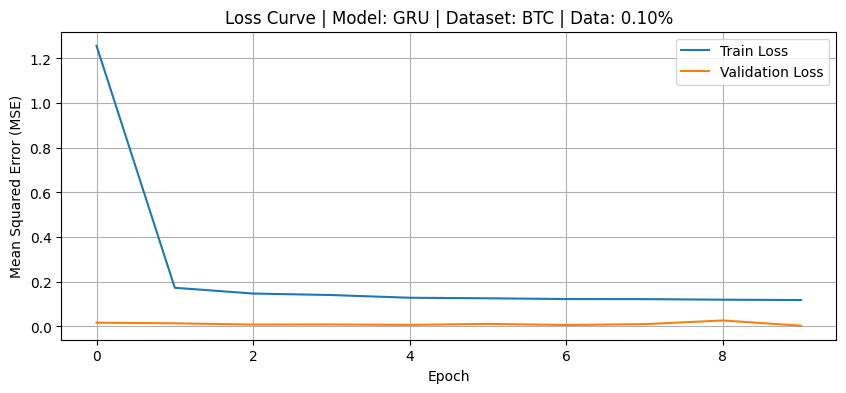

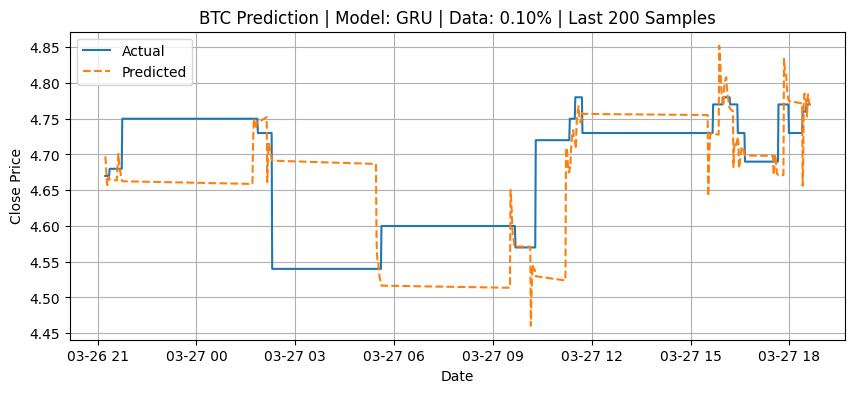

In [135]:
stats_btc_gru = run_full_pipeline(
    asset="btc", 
    model_name = "gru",
    epochs=EPOCHS,
    model_function=build_gru_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

In [27]:
testing_etc = eth_df_features.copy()

In [ ]:
testing_etc['target'] = testing_etc['Close'].shift(-1)

In [55]:
testing_etc.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Close_1m_ago',
       'PctChange_1m', 'Close_5m_ago', 'PctChange_5m', 'Close_1h_ago',
       'PctChange_1h', 'Close_1d_ago', 'PctChange_1d', 'Close_1w_ago',
       'PctChange_1w', 'Close_1mo_ago', 'PctChange_1mo', 'SMA_20', 'EMA_20',
       'SMA_50', 'EMA_50', 'SMA_200', 'EMA_200', 'RSI_14', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower',
       'VolMA_short', 'VolMA_long', 'VolumeOscillator', 'OBV', 'candle_range',
       'body_size', 'Doji', 'ATR', '+DI', '-DI', 'ADX', '%K', '%D',
       'Williams_%R', 'target'],
      dtype='object')

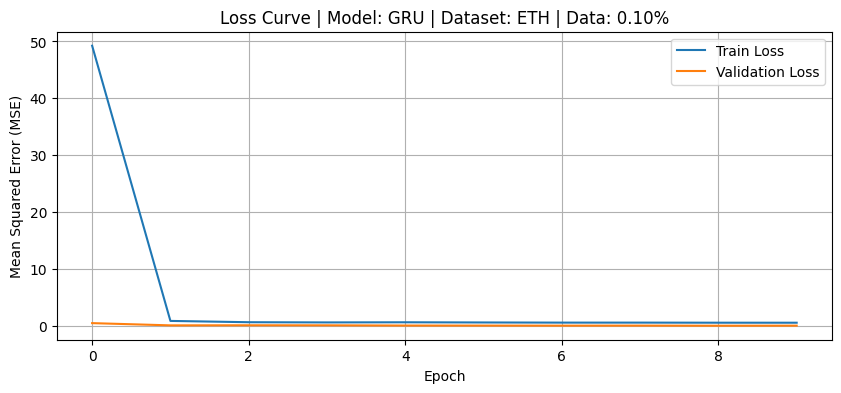

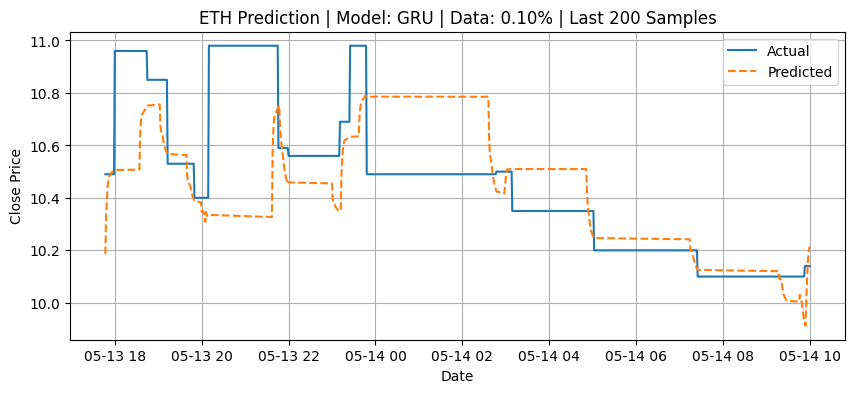

In [136]:
stats_eth_gru = run_full_pipeline(
    asset="eth", 
    model_name = "gru",
    epochs=EPOCHS,
    model_function=build_gru_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

### CNN

> Note: In the initial implementation and runs, we did not include date_series; this was done later, and we ran the CNN BTC for this to test.


In [ ]:
stats_btc_cnn = run_full_pipeline(
    asset="btc", 
    model_name = "cnn",
    epochs=EPOCHS,
    model_function=build_cnn_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

In [ ]:
stats_eth_cnn = run_full_pipeline(
    asset="eth", 
    model_name = "cnn",
    epochs=EPOCHS,
    model_function=build_cnn_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

### Transformer

In [ ]:
stats_btc_transformer = run_full_pipeline(
    asset="btc", 
    model_name = "transformer",
    epochs=EPOCHS,
    model_function=build_transformer_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

In [ ]:
stats_btc_transformer = run_full_pipeline(
    asset="eth", 
    model_name = "transformer",
    epochs=EPOCHS,
    model_function=build_transformer_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

### RNN

The initial files for this got saved into `<function build_rnn_model at 0x7f462719b910>` funtion name. This was later updated to "rnn". Just a mistake but was fixed manually. 


In [ ]:
stats_btc_rnn = run_full_pipeline(
    asset="btc", 
    model_name = "rnn",
    epochs=EPOCHS,
    model_function=build_rnn_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

In [ ]:
stats_eth_rnn = run_full_pipeline(
    asset="eth", 
    model_name = "rnn",
    epochs=EPOCHS,
    model_function=build_rnn_model, 
    data_percent=DATA_PERCENTAGES[0],
    stop_loss_pct= STOP_LOSS
)

We ran into some variable name issues. They have been fixed in the code now, but the names were not consistent. So we ended up renaming the. Here is the code for it:


In [ ]:
import os

def get_new_name(name):
    if name.startswith("<function build_rnn_model"):
        if ">" in name:
            return "rnn" + name.split(">", 1)[-1]
        return "rnn"
    if name.startswith("build_rnn_model"):
        return "rnn" + name[len("build_rnn_model"):]
    return name


def create_mapping(path):
    mapping = {}
    for root, dirs, files in os.walk(path, topdown=False):
        for n in files + dirs:
            new = get_new_name(n)
            if new != n:
                old_path = os.path.join(root, n)
                new_path = os.path.join(root, new)
                mapping[old_path] = new_path
    return mapping

base_path = "./" 
mapping = create_mapping(base_path)

In [ ]:
for old in sorted(mapping, key=len, reverse=True):
    os.rename(old, mapping[old])

---


## Full run

In [29]:
import os
import time
import io
import re
import contextlib
import pandas as pd

def execute_experiment_for_percentage(asset, model_name, model_function, data_pct, epochs, stop_loss, md_base):
    lines = []  
    start = time.time()
    percent_str = format_percent_string(data_pct)
    
    # Capture stdout during run_full_pipeline (and any nested prints)
    stdout_buffer = io.StringIO()
    with contextlib.redirect_stdout(stdout_buffer):
        stats = run_full_pipeline(
            asset=asset,
            model_name=model_name,
            epochs=epochs,
            model_function=model_function,
            data_percent=data_pct,
            stop_loss_pct=stop_loss
        )
    captured_output = stdout_buffer.getvalue()
    # Remove backspace control characters while preserving newlines and normal characters.
    captured_output = re.sub(r'\x08+', '', captured_output)
    duration = time.time() - start

    # Compute artifact file paths.
    training_image_path = os.path.join("plots", f"loss_curve_{model_name}_{asset}_{percent_str}pct.png")
    prediction_plot_path = os.path.join("plots", f"prediction_plot_{model_name}_{asset}_{percent_str}pct.png")
    
    # Use prediction CSV (comparison) instead of the old epoch CSV.
    prediction_csv_path = os.path.join("model-result-data", f"{model_name.lower()}_{asset.lower()}_comparison_{percent_str}pct.csv")
    # Compute the metrics CSV path (as generated in print_metrics).
    metrics_csv_path = os.path.join("model-result-data", f"{asset.lower()}_{model_name.lower()}_{percent_str}pct_metrics.csv")
    stop_str = format_percent_string(stop_loss)
    result_folder = os.path.join(
        "results",
        f"{model_name}_{asset}_{format_percent_string(data_pct)}pct_{stop_str}stloss"
        )
    backtest_html_path = os.path.join(result_folder, "backtest_plot.html")
    backtest_csv_path = os.path.join(result_folder, "backtest_stats.csv")
    model_file = os.path.join("models", f"{model_name}_{asset}_model_{percent_str}pct.h5")
    scaler_file = os.path.join("models", f"{model_name}_{asset}_scaler_{percent_str}pct.pkl")
    
    # Utility: Compute relative paths (using forward slashes).
    def rel_path(p):
        return os.path.relpath(p, start=md_base).replace(os.path.sep, '/')

    # Begin constructing the Markdown snippet.
    lines.append(f"#### Experiment: Data Used: {data_pct:.3%}, Epochs: {epochs}")
    lines.append(f"**Stop Loss:** {stop_loss:.3%}\n")
    lines.append(f"**Duration:** {duration:.2f} seconds\n")
    
    # Console output as a subheading.
    if captured_output.strip():
        lines.append("##### Console Output:")
        lines.append("```\n" + captured_output + "\n```")
    
    # Training Loss Plot as a subheading.
    if os.path.exists(training_image_path):
        lines.append("##### Training Loss Plot:")
        lines.append(f"![Training Loss Plot]({rel_path(training_image_path)})\n")
    
    # Prediction Plot as a subheading.
    if os.path.exists(prediction_plot_path):
        lines.append("##### Prediction Plot:")
        lines.append(f"![Prediction Plot]({rel_path(prediction_plot_path)})\n")
    
    # Comparison CSV link as a subheading.
    if os.path.exists(prediction_csv_path):
        lines.append("##### Comparison Data:")
        lines.append(f"[View CSV]({rel_path(prediction_csv_path)})\n")
    
    # Metrics CSV link as a subheading.
    if os.path.exists(metrics_csv_path):
        lines.append("##### Metrics CSV:")
        lines.append(f"[View CSV]({rel_path(metrics_csv_path)})\n")
    
    # Backtest Interactive Chart as a subheading.
    lines.append("##### Backtest Interactive Chart:")
    if os.path.exists(backtest_html_path):
        # Embed the HTML as an iframe.
        iframe_html = f'<iframe src="{rel_path(backtest_html_path)}" width="100%" height="600px" frameborder="0"></iframe>'
        lines.append(iframe_html)
        lines.append(f"If the iframe does not display, please [click here to view the HTML]({rel_path(backtest_html_path)}).\n")
    else:
        lines.append(f"Backtest interactive chart HTML file not found at {backtest_html_path}\n")
    
    # Backtest Stats as a subheading.
    if os.path.exists(backtest_csv_path):
        lines.append("##### Backtest Stats:")
        try:
            df_csv = pd.read_csv(backtest_csv_path)
            csv_md = df_csv.to_markdown(index=False)
            lines.append(csv_md + "\n")
        except Exception:
            lines.append(f"[View CSV]({rel_path(backtest_csv_path)})\n")
    
    # Saved Model and Scaler as a subheading.
    if os.path.exists(model_file) and os.path.exists(scaler_file):
        lines.append("##### Saved Model and Scaler:")
        lines.append(f"- **Model:** [View Model]({rel_path(model_file)})")
        lines.append(f"- **Scaler:** [View Scaler]({rel_path(scaler_file)})\n")
    
    # Combine all lines into the final markdown snippet.
    markdown_snippet = "\n".join(lines) + "\n\n---\n\n"
    
    # Save the markdown (including the captured output) into a dedicated text file.
    text_log_dir = os.path.join("logs", "experiment_text")
    os.makedirs(text_log_dir, exist_ok=True)
    text_log_file = os.path.join(text_log_dir, f"experiment_{asset}_{model_name}_{percent_str}pct.txt")
    with open(text_log_file, "w") as log_file:
        log_file.write(markdown_snippet)
    
    # Return useful information along with the generated markdown snippet.
    return {
        "stats": stats,
        "markdown": markdown_snippet,
        "comparison_csv": prediction_csv_path,
        "metrics_csv": metrics_csv_path,
        "text_log": text_log_file
    }


In [30]:
def execute_model_runs(models_dict, assets, data_percentages, epochs=10, stop_loss=0.003, display_report=True):
    results = {}
    csv_paths = []
    report_filenames = []
    report_dir = os.path.join("logs", "reports")
    os.makedirs(report_dir, exist_ok=True)
    
    # Loop over each data percentage to create individual reports
    for data_pct in data_percentages:
        report_md_lines = []
        pct_str = format_percent_string(data_pct)
        start_time = time.time()
        
        # Build report header using a more descriptive title.
        report_md_lines.append(f"# Full Analysis Report for Data Percentage: {data_pct * 100:.2f}%\n")
        report_md_lines.append("This report summarizes all experiments conducted for this specific data percentage.\n")
        report_md_lines.append(f"**Assets Tested:** {', '.join(assets)}\n")
        report_md_lines.append(f"**Epochs per Experiment:** {epochs}\n")
        report_md_lines.append(f"**Stop Loss Setting:** {stop_loss}\n")
        report_md_lines.append("---\n")
        
        for asset in assets:
            # Initialize results for the asset if not already present
            if asset not in results:
                results[asset] = {}
            report_md_lines.append(f"\n## Asset: {asset.upper()}\n")
            
            for model_name, model_fn_list in models_dict.items():
                if model_name not in results[asset]:
                    results[asset][model_name] = {}
                report_md_lines.append(f"\n### Model: {model_name.upper()}\n")
                
                for model_fn in model_fn_list:
                    # Execute the experiment for current asset/model/data percentage.
                    exp_result = execute_experiment_for_percentage(
                        asset=asset,
                        model_name=model_name,
                        model_function=model_fn,
                        data_pct=data_pct,
                        epochs=epochs,
                        stop_loss=stop_loss,
                        md_base=report_dir
                    )
                    
                    # Remove unwanted experiment run heading from the returned markdown snippet.
                    exp_markdown_lines = [
                        line for line in exp_result["markdown"].splitlines()
                        if not line.startswith("#### Experiment: Data Used:")
                    ]
                    cleaned_markdown = "\n".join(exp_markdown_lines)
                    
                    # Store the stats in the results dictionary.
                    results[asset][model_name][data_pct] = exp_result["stats"]
                    
                    # Add the cleaned experiment markdown to the report content.
                    report_md_lines.append(cleaned_markdown)
                    
                    # Collect the comparison and metrics CSV paths.
                    csv_paths.append({
                        "asset": asset,
                        "model": model_name,
                        "data_pct": data_pct,
                        "comparison_csv": exp_result["comparison_csv"],
                        "metrics_csv": exp_result["metrics_csv"]
                    })
        
        total_duration = time.time() - start_time
        report_md_lines.append(f"\n---\n**Total Duration for Data Percentage {data_pct * 100:.2f}%:** {total_duration:.2f} seconds\n")
        full_md_content = "\n".join(report_md_lines)
        
        # Create report filename using the formatted percentage.
        report_filename = f"experiment_report_{pct_str}pct.md"
        md_filename = os.path.join(report_dir, report_filename)
        report_filenames.append(md_filename)
        
        with open(md_filename, "w") as f:
            f.write(full_md_content)
        
        if display_report:
            print(full_md_content)
            print(f"\nMarkdown report saved to: {md_filename}\n")
            try:
                display(Markdown(full_md_content))
            except Exception:
                pass

    return results, report_filenames, csv_paths


In [31]:
def conv_md_toc(report_path):
    html_file = os.path.splitext(report_path)[0] + '.html'
    with open(report_path, 'r', encoding='utf-8') as f:
        md_content = f.read()
    lines = md_content.splitlines()
    spaced = []
    for i, line in enumerate(lines):
        spaced.append(line)
        if i < len(lines) - 1 and lines[i].strip() and lines[i+1].strip():
            spaced.append("")
    toc = ("<div style='text-align: center; font-weight: bold; font-size: 1.5em; "
           "font-family: Georgia, serif;'>Table of Content</div>\n\n[TOC]\n\n")
    new_lines = []
    toc_inserted = False
    for line in spaced:
        if not toc_inserted and line.strip() == '---':
            new_lines.append(toc.strip())
            new_lines.append("")
            toc_inserted = True
        new_lines.append(line)
    md_with_toc = "\n".join(new_lines) if toc_inserted else toc + "\n".join(spaced)
    html_body = markdown.markdown(
        md_with_toc,
        extensions=['toc', 'fenced_code', 'tables'],
        extension_configs={'toc': {'permalink': True, 'toc_depth': '2-6', 'title': ''}}
    )
    html_template = f"""<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>Report</title>
    <style>
        body {{
            font-family: Georgia, 'Times New Roman', serif;
            font-size: 16px;
            line-height: 1.6;
            padding: 40px;
            max-width: 800px;
            margin: auto;
        }}
        h1, h2, h3, h4, h5 {{ font-weight: bold; }}
        ul {{ margin-left: 1.5em; }}
        code, pre {{
            font-family: Consolas, monospace;
            background: #f4f4f4;
            padding: 4px;
            border-radius: 4px;
        }}
        .toc ul {{ list-style-type: decimal; padding-left: 20px; }}
    </style>
</head>
<body>
{html_body}
</body>
</html>"""
    with open(html_file, 'w', encoding='utf-8') as f:
        f.write(html_template)
    return html_file

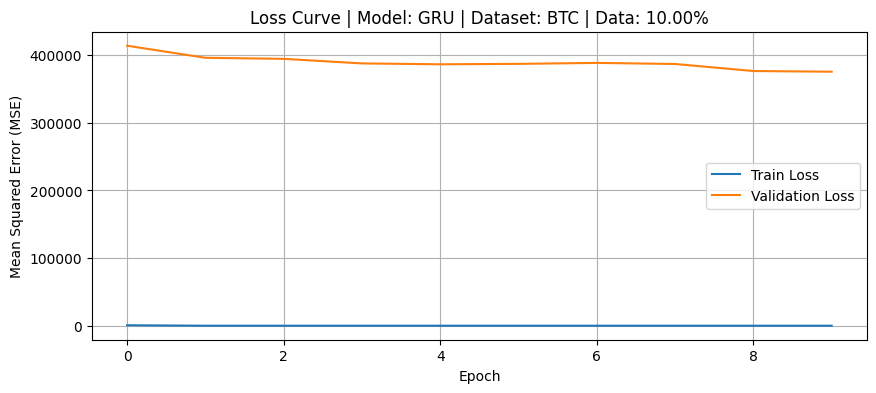

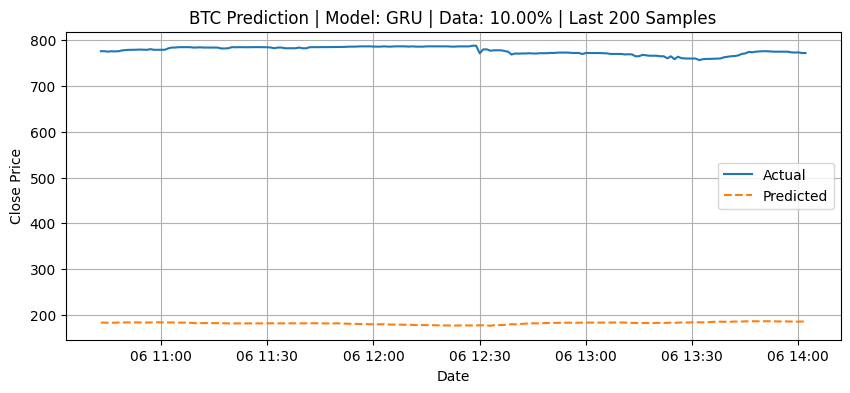

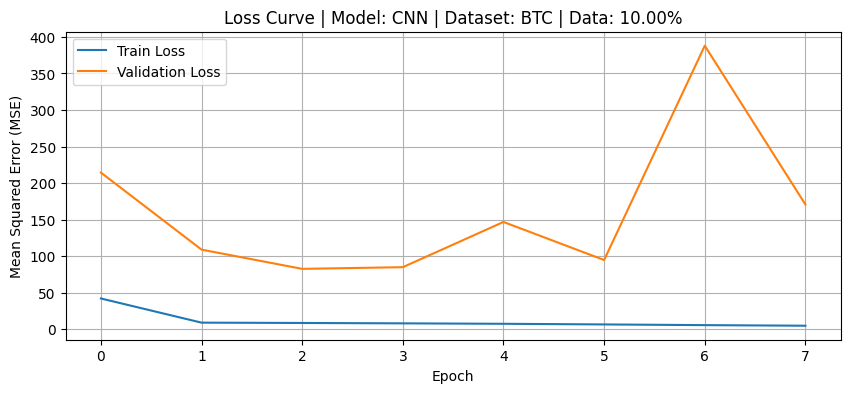

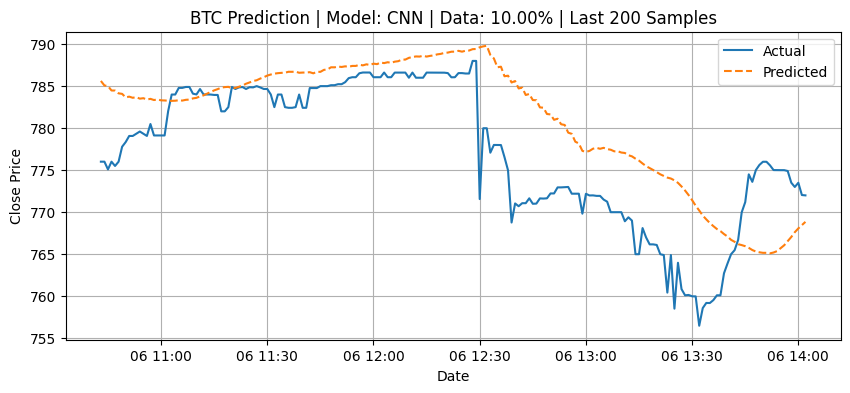

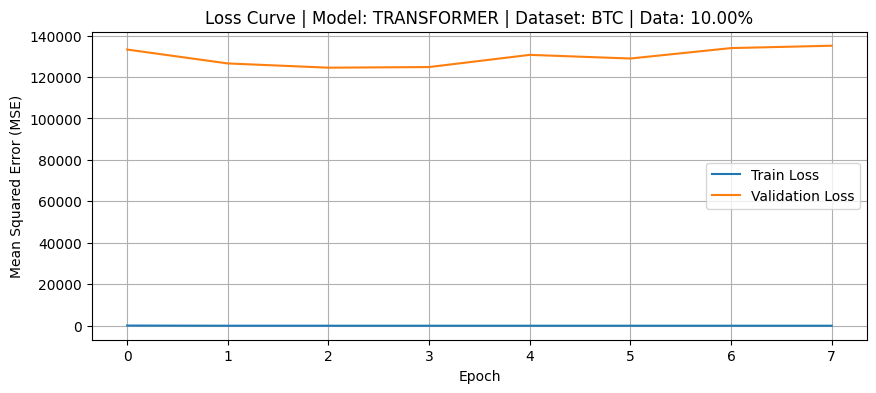

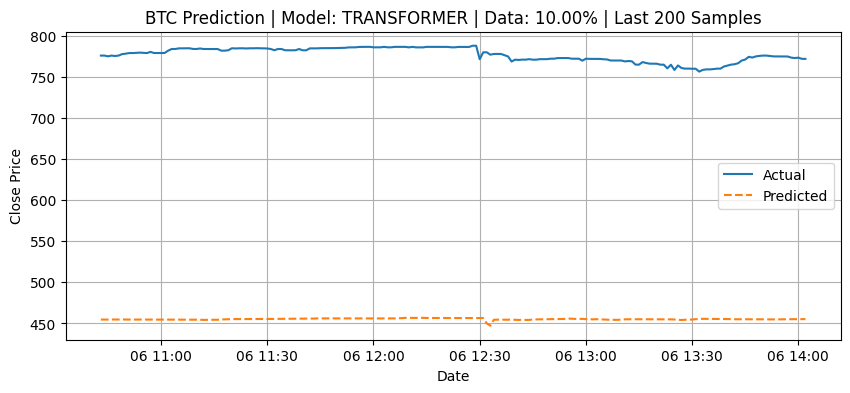

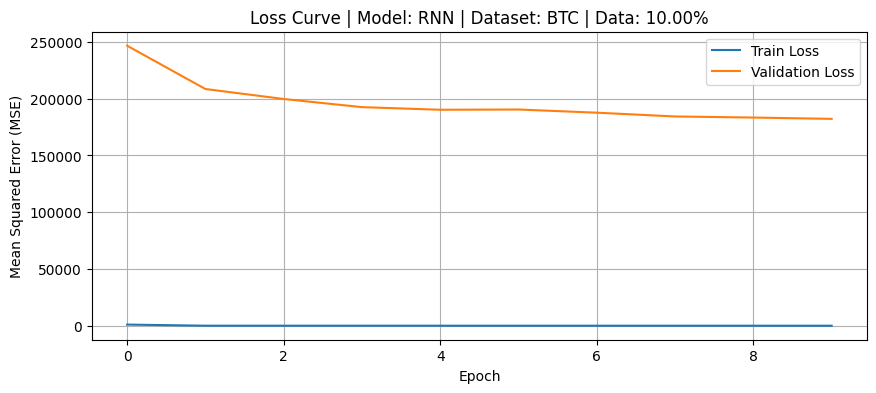

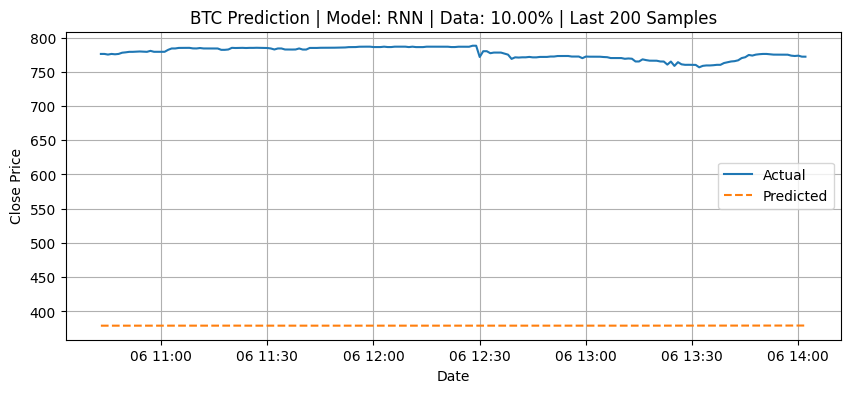

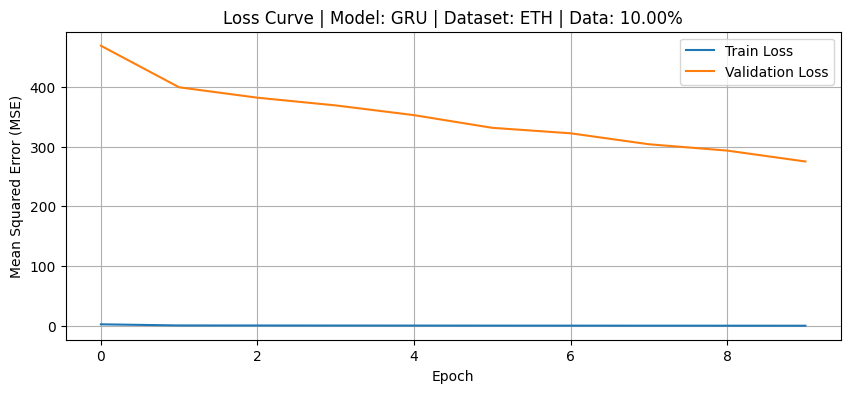

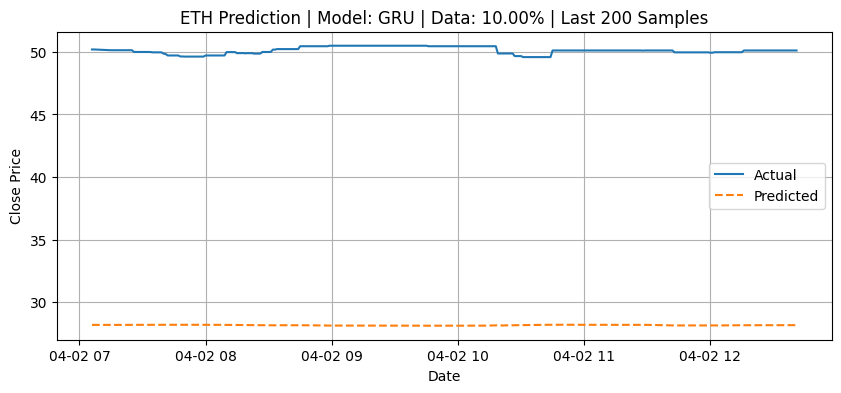

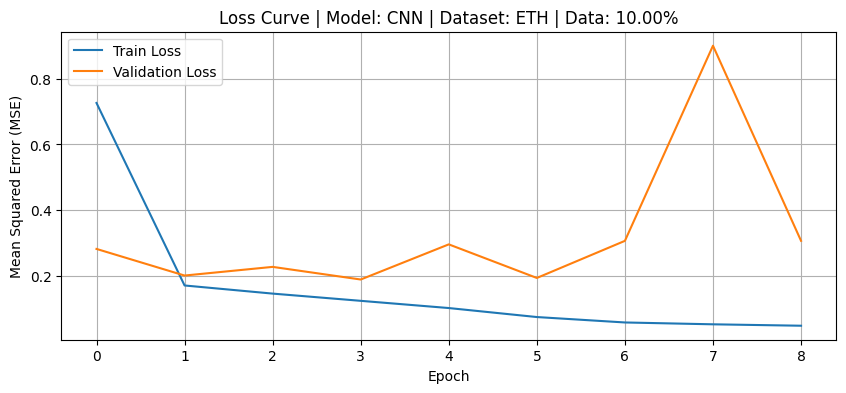

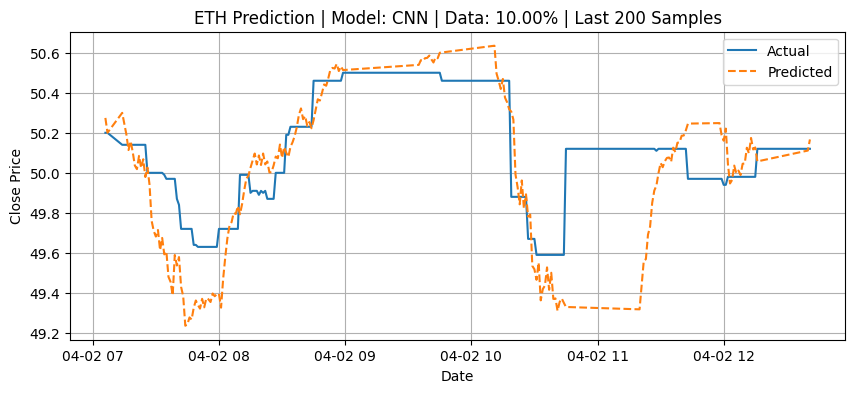

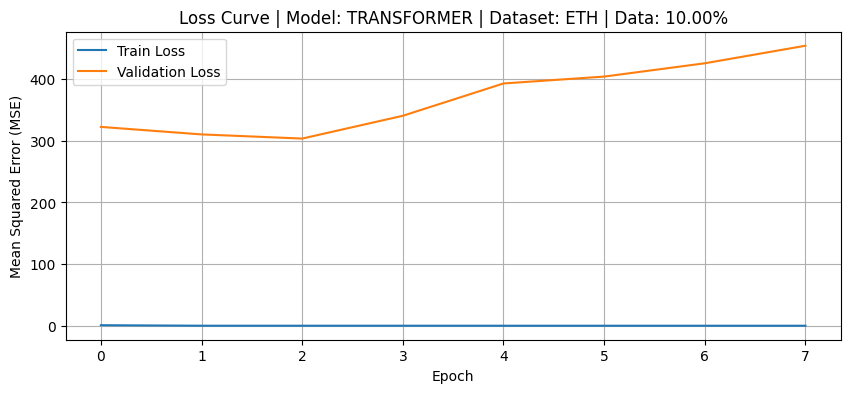

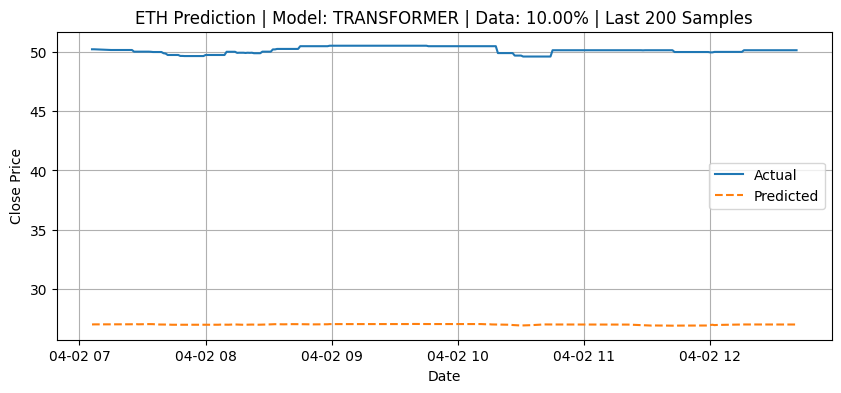

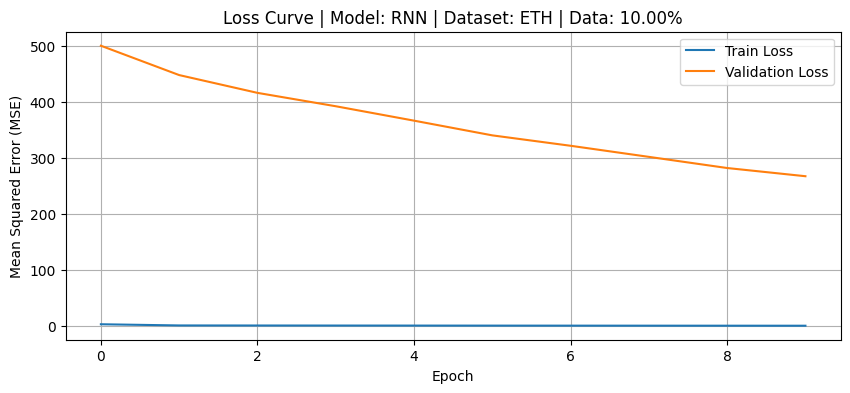

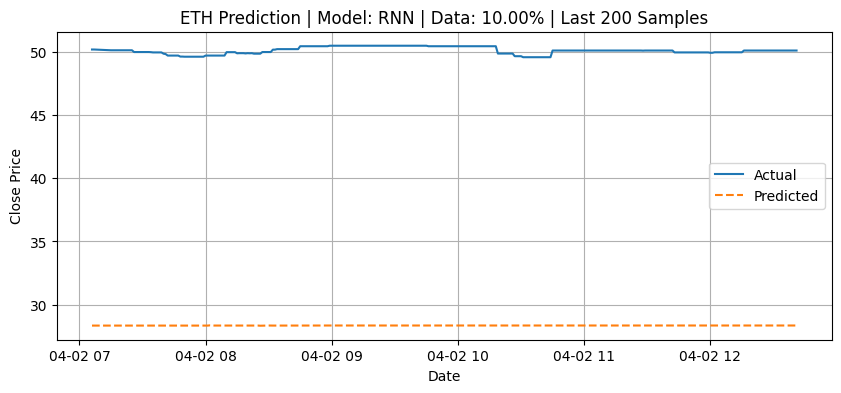

In [32]:
models = {
    "gru": [build_gru_model],
    "cnn": [build_cnn_model],
    "transformer": [build_transformer_model],
    "rnn": [build_rnn_model],
}

ASSETS = ["btc", "eth"]
DATA_PERCENTAGES = [0.1]
EPOCHS = 10
STOP_LOSS = 0.003
results, report_filenames, csv_paths = execute_model_runs(
    models_dict=models,
    assets=ASSETS,
    data_percentages=DATA_PERCENTAGES,
    epochs=EPOCHS,
    stop_loss=STOP_LOSS,
    display_report=False
)

In [33]:
print("Final Experiment Report Generated.\n")
print("Your comprehensive experiment report (with summaries, logs, and artifact links) has been created.\n")
print("Report Links:")
for i, path in enumerate(report_filenames, start=1):
    print(f"  {i}. {path}")


Final Experiment Report Generated.

Your comprehensive experiment report (with summaries, logs, and artifact links) has been created.

Report Links:
  1. logs\reports\experiment_report_10pct.md


In [34]:
def conv_all(report_paths):
    html_files = []
    for rpt in report_paths:
        hf = conv_md_toc(rpt)
        print(f"Converted {rpt} -> {hf}")
        html_files.append(hf)
    return html_files

In [35]:
converted_html = conv_all(report_filenames)
print("Converted HTML files:")
for html_file in converted_html:
    print(html_file)

Converted logs\reports\experiment_report_10pct.md -> logs\reports\experiment_report_10pct.html
Converted HTML files:
logs\reports\experiment_report_10pct.html


In [40]:
def load_logs(log_dir="logs"):
    log_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.endswith(".csv")]
    summary_data = []
    all_logs = []

    for path in log_files:
        df = pd.read_csv(path)
        filename = os.path.basename(path).lower()

        model_match = re.match(r'(.*?)_(btc|eth)_log_(\d+_\d+|\d+)pct\.csv', filename)
        if not model_match:
            continue

        model_type = model_match.group(1).upper()
        crypto = model_match.group(2).upper()
        data_pct_str = model_match.group(3)
        data_pct = float(data_pct_str.replace("_", "."))

        min_val_loss = df['val_loss'].min()
        min_val_epoch = df['val_loss'].idxmin()
        final_val_loss = df['val_loss'].iloc[-1]
        epochs_run = len(df)

        summary_data.append({
            "Type": model_type,
            "Crypto": crypto,
            "Data %": data_pct,
            "Min Val Loss": min_val_loss,
            "Epoch (Min Val Loss)": min_val_epoch,
            "Final Val Loss": final_val_loss,
            "Epochs Run": epochs_run,
            "File": filename
        })

        df['Model'] = model_type
        df['Crypto'] = crypto
        df['Data %'] = data_pct
        df['File'] = filename
        all_logs.append(df)

    if all_logs:
        logs_df = pd.concat(all_logs, ignore_index=True)
    else:
        logs_df = pd.DataFrame()

    summary_df = pd.DataFrame(summary_data).sort_values(by=["Type", "Crypto", "Data %"])
    
    available_pcts = sorted(summary_df["Data %"].unique())
    print("Available Data Percentages:", available_pcts)

    # Save compiled CSVs in log_dir
    summary_path = os.path.join(log_dir, "compiled_summary.csv")
    logs_path = os.path.join(log_dir, "compiled_logs.csv")
    
    summary_df.to_csv(summary_path, index=False)
    logs_df.to_csv(logs_path, index=False)
    
    print(f"Saved summary to {summary_path}")
    print(f"Saved logs to {logs_path}")

    return summary_df, logs_df, available_pcts


In [41]:
summary_df, logs_df, available_pcts = load_logs("logs")
summary_df


Available Data Percentages: [0.1, 1.0, 10.0]
Saved summary to logs\compiled_summary.csv
Saved logs to logs\compiled_logs.csv


,Type,Crypto,Data %,Min Val Loss,Epoch (Min Val Loss),Final Val Loss,Epochs Run,File
0,CNN,BTC,0.1,0.008470,9,0.008470,10,cnn_btc_log_0_1pct.csv
2,CNN,BTC,1.0,0.011694,2,0.020843,8,cnn_btc_log_1pct.csv
1,CNN,BTC,10.0,82.672707,2,170.746277,8,cnn_btc_log_10pct.csv
3,CNN,ETH,0.1,0.071316,7,0.143302,10,cnn_eth_log_0_1pct.csv
5,CNN,ETH,1.0,0.040002,7,0.059378,10,cnn_eth_log_1pct.csv
4,CNN,ETH,10.0,0.189123,3,0.306747,9,cnn_eth_log_10pct.csv
6,GRU,BTC,0.1,0.003348,9,0.003348,10,gru_btc_log_0_1pct.csv
8,GRU,BTC,1.0,0.003891,8,0.009421,10,gru_btc_log_1pct.csv
7,GRU,BTC,10.0,375655.937500,9,375655.937500,10,gru_btc_log_10pct.csv
9,GRU,ETH,0.1,0.045228,7,0.065841,10,gru_eth_log_0_1pct.csv


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_loss_val_loss(logs_df, available_pcts, selected_pct='all', save_dir="logs"):
    if logs_df.empty:
        raise ValueError("logs_df is empty. Nothing to plot.")

    # Determine which percentages to plot
    if selected_pct == 'all':
        pcts_to_plot = available_pcts
    elif selected_pct in available_pcts:
        pcts_to_plot = [selected_pct]
    else:
        raise ValueError(f"Selected data percentage {selected_pct}% not found in logs. Available options: {available_pcts}")

    palette = sns.color_palette("tab10")
    model_types = logs_df['Model'].unique()
    color_map = {model: palette[i % len(palette)] for i, model in enumerate(model_types)}

    for pct in pcts_to_plot:
        grouped = logs_df[logs_df["Data %"] == pct].groupby(['Crypto'])

        for (crypto,), group in grouped:
            fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

            # LOSS subplot
            ax = axes[0]
            for model in model_types:
                model_data = group[group['Model'] == model].sort_values('epoch')
                if not model_data.empty:
                    ax.plot(model_data['epoch'], model_data['loss'], label=model, color=color_map[model], linewidth=2)
            ax.set_title(f"Training Loss - {crypto} - {pct}% Data")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.grid(True)
            ax.legend()

            # VAL_LOSS subplot
            ax = axes[1]
            for model in model_types:
                model_data = group[group['Model'] == model].sort_values('epoch')
                if not model_data.empty:
                    ax.plot(model_data['epoch'], model_data['val_loss'], label=model, color=color_map[model], linewidth=2, linestyle='--')
            ax.set_title(f"Validation Loss - {crypto} - {pct}% Data")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Val Loss")
            ax.grid(True)
            ax.legend()

            plt.tight_layout()

            # Save figure
            formatted_pct = format_percent_string(pct/100)
            filename = f"loss_curve_all_{crypto.lower()}_{formatted_pct}pct.png"
            save_path = os.path.join(save_dir, filename)
            plt.savefig(save_path)
            print(f"Saved plot to: {save_path}")
            plt.show(fig)


Saved plot to: logs\loss_curve_all_btc_0_1pct.png


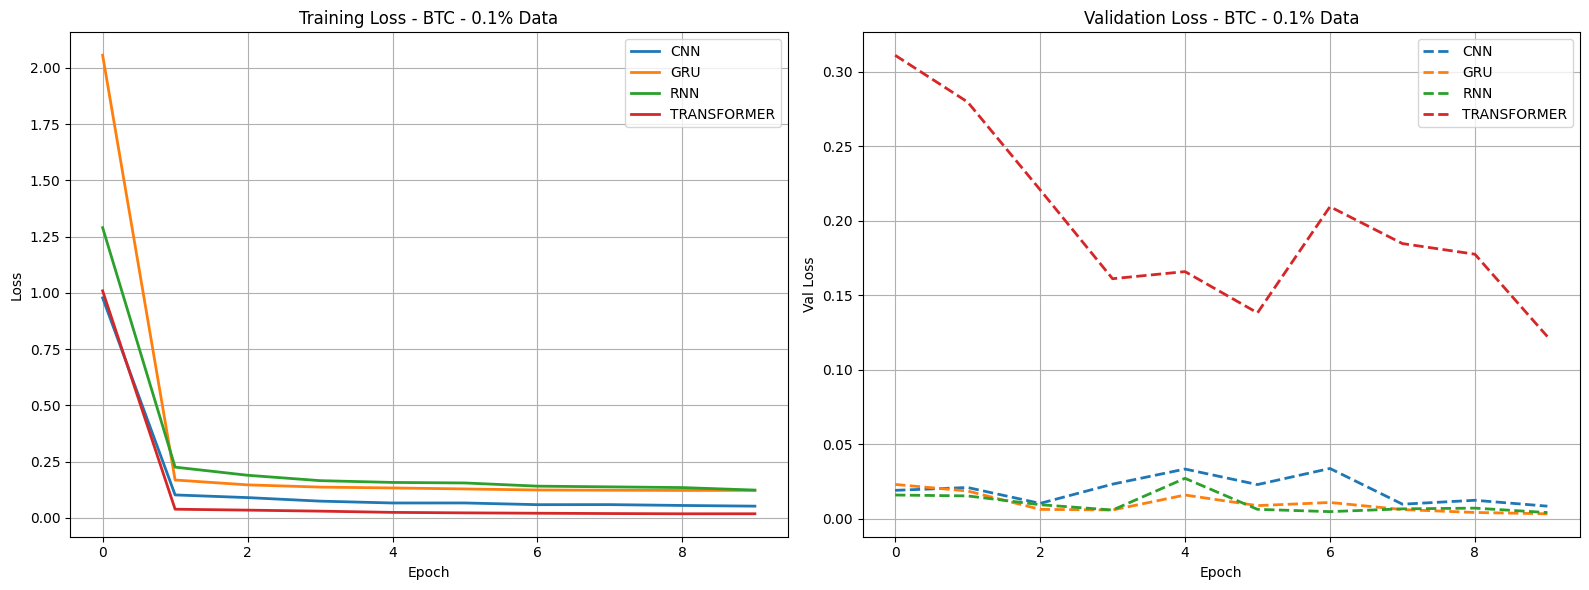

Saved plot to: logs\loss_curve_all_eth_0_1pct.png


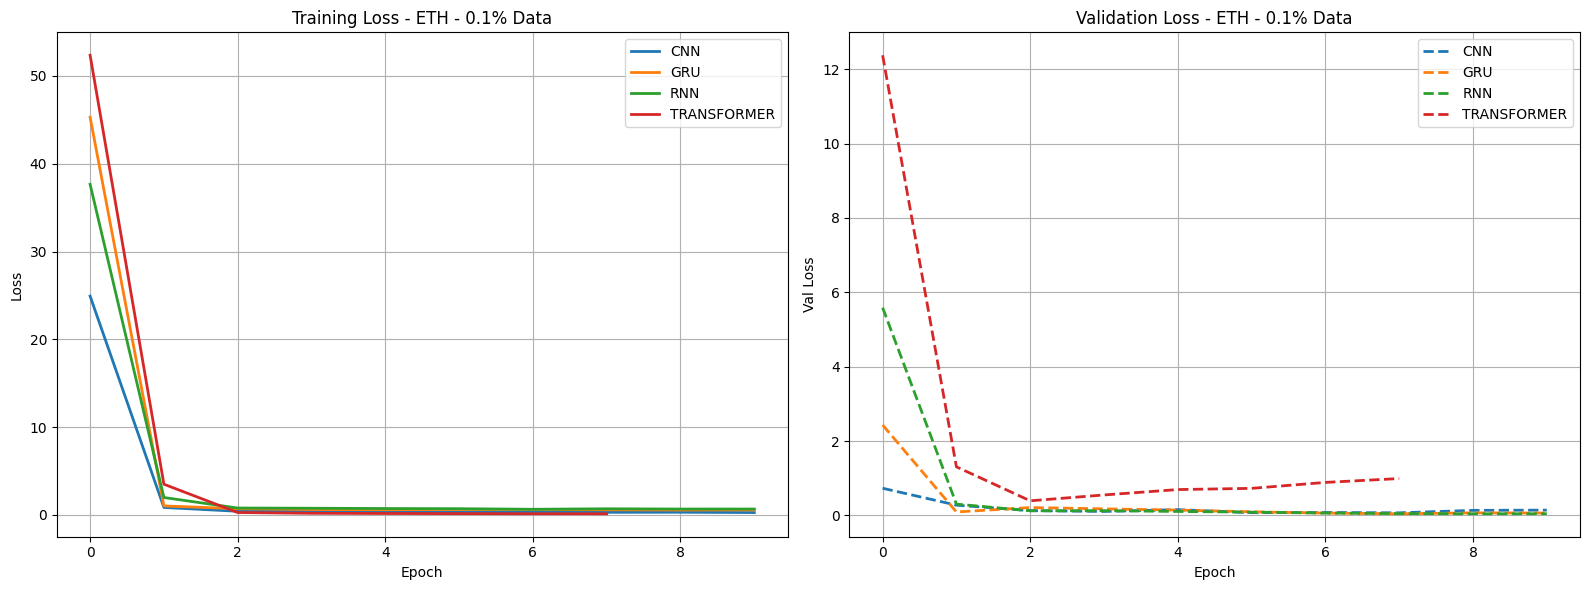

Saved plot to: logs\loss_curve_all_btc_1pct.png


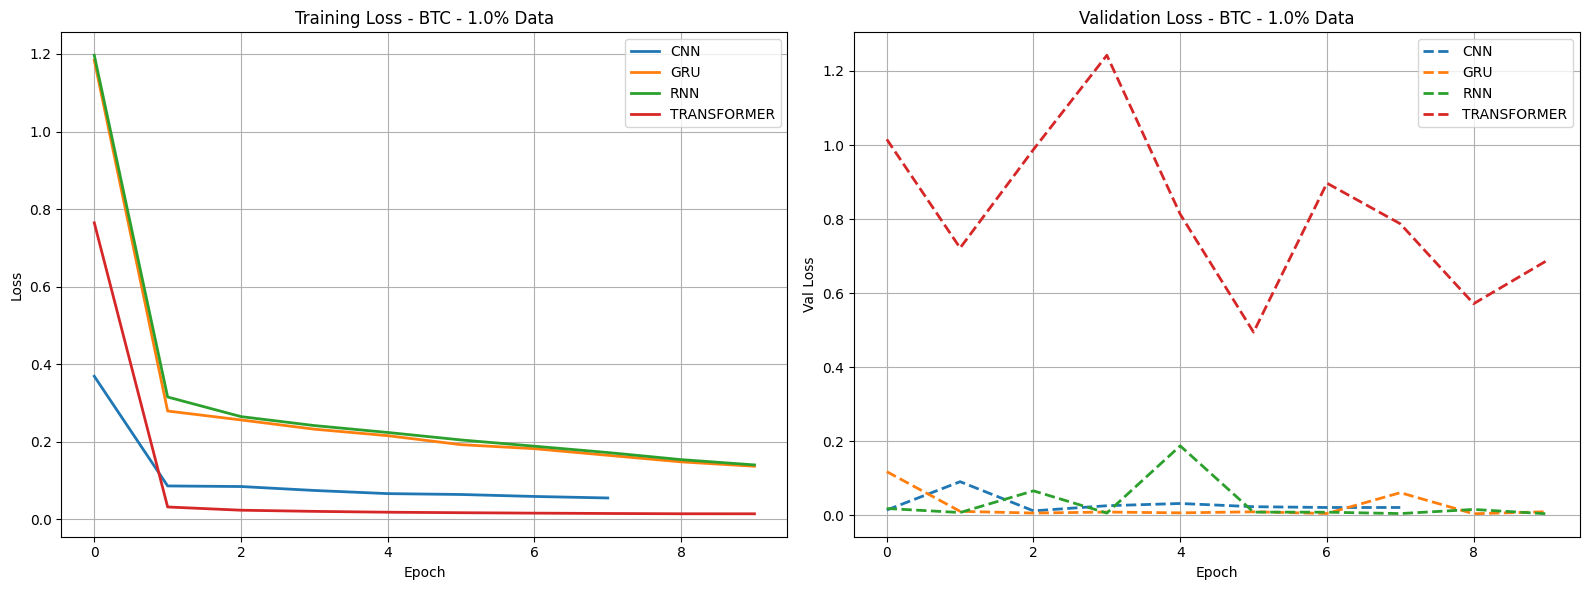

Saved plot to: logs\loss_curve_all_eth_1pct.png


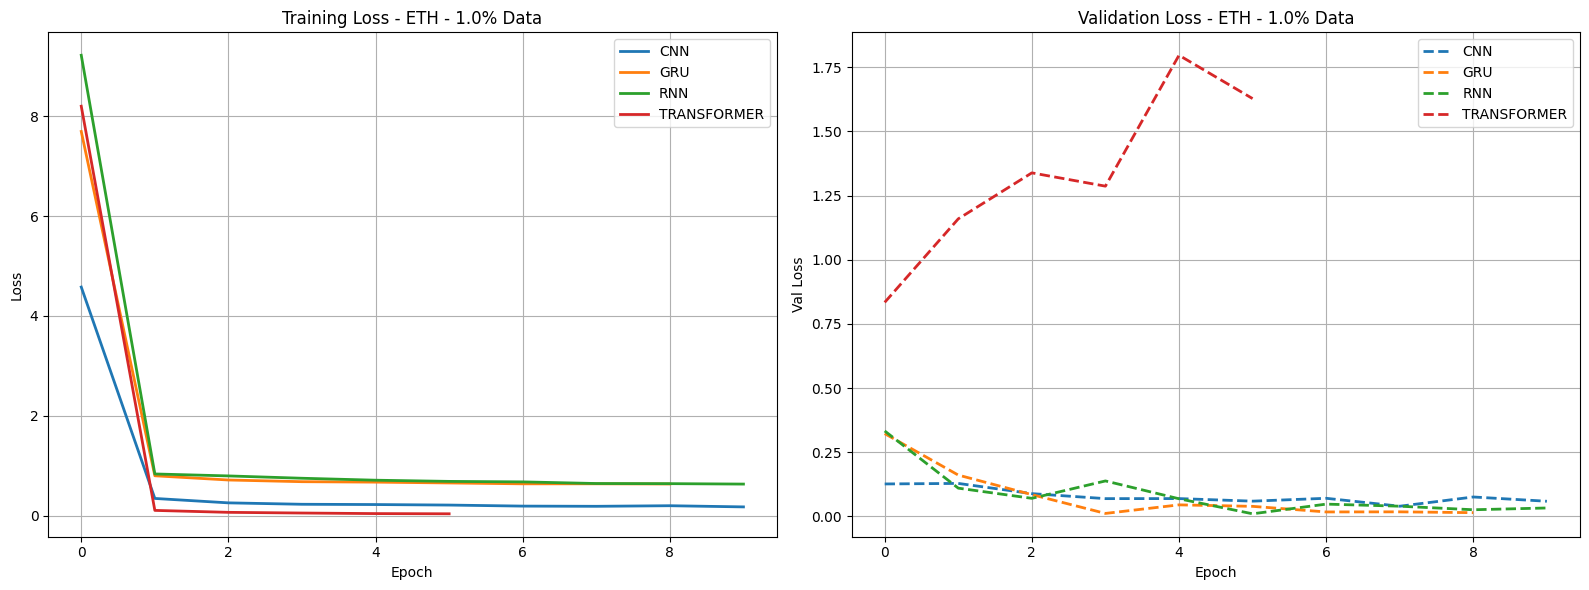

Saved plot to: logs\loss_curve_all_btc_10pct.png


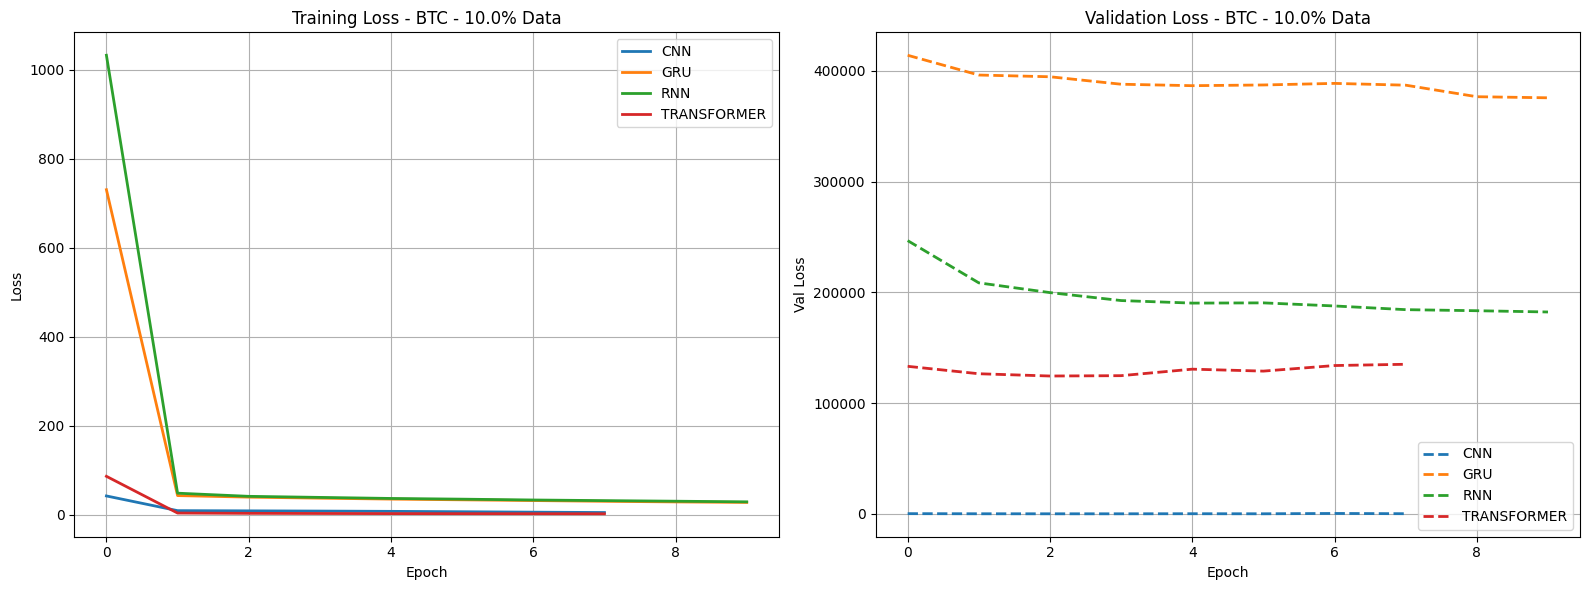

Saved plot to: logs\loss_curve_all_eth_10pct.png


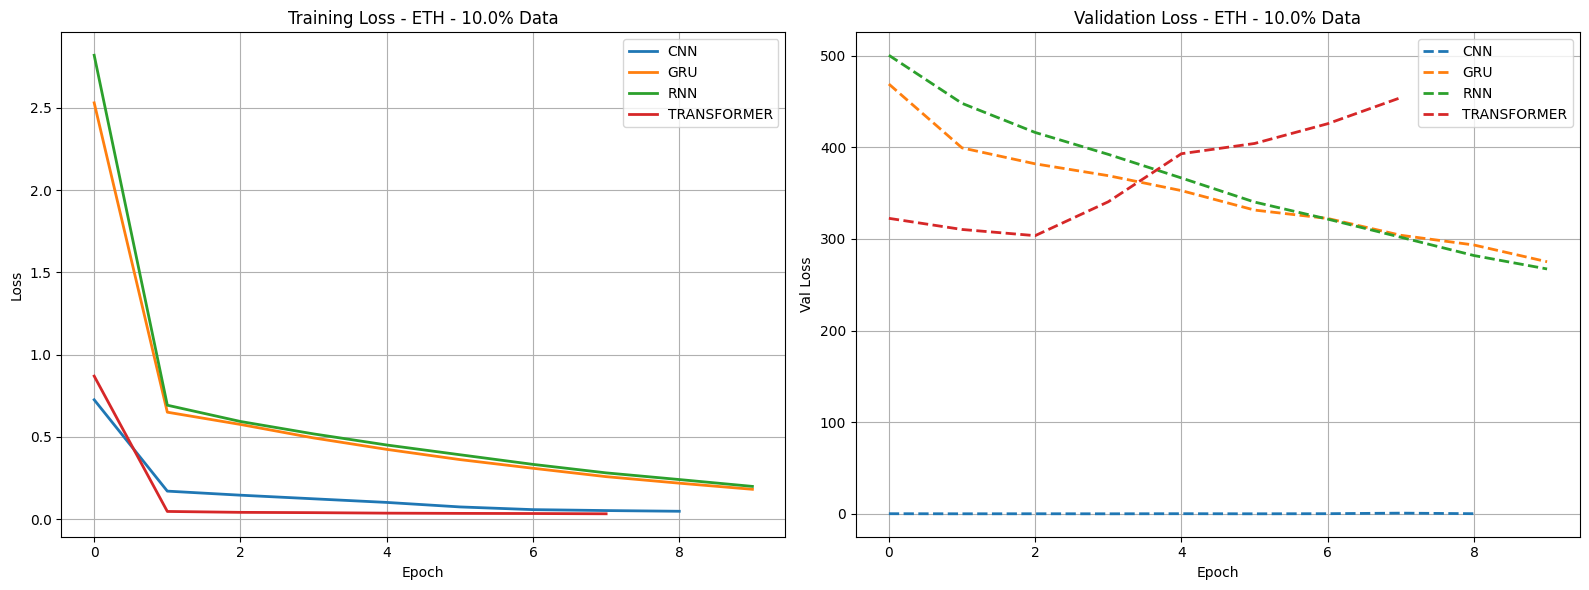

In [43]:
plot_loss_val_loss(logs_df, available_pcts, selected_pct='all')


In [418]:
PLOT_OUTPUT_DIR = "./plots"

def load_metrics(result_data_dir=RESULT_DATA_DIR):
    files = glob.glob(os.path.join(result_data_dir, "*_metrics.csv"))
    dfs = []
    for f in files:
        if "random_forest" in os.path.basename(f).lower():
            continue
        df_temp = pd.read_csv(f)
        df_temp["source_file"] = os.path.basename(f)
        dfs.append(df_temp)
    df = pd.concat(dfs, ignore_index=True)
    df["data_pct"] = pd.to_numeric(df["data_pct"], errors="coerce")
    df["model"] = df["model"].str.strip().str.lower()
    df["dataset"] = df["dataset"].str.strip().str.lower()
    return df

In [419]:
metrics_files_df = load_metrics()

In [464]:
metrics_files_df

,dataset,model,data_pct,accuracy,precision,recall,f1,mse,rmse,mae,source_file
0,btc,cnn,0.001,0.057600,0.037995,0.367836,0.068850,0.008470,0.092031,0.071209,btc_cnn_0_1pct_metrics.csv
1,btc,cnn,0.100,0.349721,0.415137,0.339030,0.276131,82.672601,9.092447,5.324477,btc_cnn_10pct_metrics.csv
2,btc,cnn,0.010,0.064968,0.209939,0.344530,0.076948,0.011694,0.108140,0.081797,btc_cnn_1pct_metrics.csv
3,btc,gru,0.001,0.061600,0.038817,0.384043,0.070507,0.003348,0.057862,0.040085,btc_gru_0_1pct_metrics.csv
4,btc,gru,0.100,0.344541,0.396339,0.334028,0.272217,375655.921107,612.907759,579.930450,btc_gru_10pct_metrics.csv
5,btc,gru,0.010,0.060350,0.039880,0.320479,0.070900,0.009421,0.097063,0.081904,btc_gru_1pct_metrics.csv
6,btc,rnn,0.001,0.051200,0.034175,0.348204,0.062196,0.004186,0.064696,0.047033,btc_rnn_0_1pct_metrics.csv
7,btc,rnn,0.100,0.347063,0.392164,0.336568,0.273963,182283.194865,426.946361,395.156326,btc_rnn_10pct_metrics.csv
8,btc,rnn,0.010,0.062261,0.041267,0.330618,0.073350,0.003774,0.061437,0.040129,btc_rnn_1pct_metrics.csv
9,btc,transformer,0.001,0.052000,0.033038,0.329073,0.060032,0.122332,0.349760,0.312819,btc_transformer_0_1pct_metrics.csv


In [430]:
def plot_metrics_for_01(metrics_df, output_dir="./plots"):
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns

    if metrics_df.empty:
        print("No data in the provided dataframe.")
        return

    os.makedirs(output_dir, exist_ok=True)
    sub = metrics_df[metrics_df["data_pct"] == 0.1]
    if sub.empty:
        print("No data found for data_pct = 0.1.")
        return

    sns.set(style="whitegrid", palette="viridis")
    metric_cols = ["accuracy", "precision", "recall", "f1", "mse", "rmse", "mae"]
    melted = sub.melt(
        id_vars=["dataset", "model", "source_file", "data_pct"],
        value_vars=metric_cols,
        var_name="metric",
        value_name="value"
    )

    g = sns.catplot(
        data=melted,
        x="model",
        y="value",
        hue="dataset",
        col="metric",
        kind="bar",
        col_wrap=3,
        height=4,
        aspect=1.3,
        sharey=False
    )

    g.set_axis_labels("Model", "Metric Value")
    g.fig.suptitle("Comparing Metrics Across Models (data_pct = 0.1)", y=1.05)
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)

    if g._legend:
        g._legend.set_bbox_to_anchor((0.5, 0.0))
        g._legend.set_loc("lower center")

    plt.tight_layout()
    path = os.path.join(output_dir, "metrics_0_1.png")
    plt.savefig(path, dpi=300)
    print(f"Plot saved to {path}")
    plt.show()
    plt.close(g.fig)


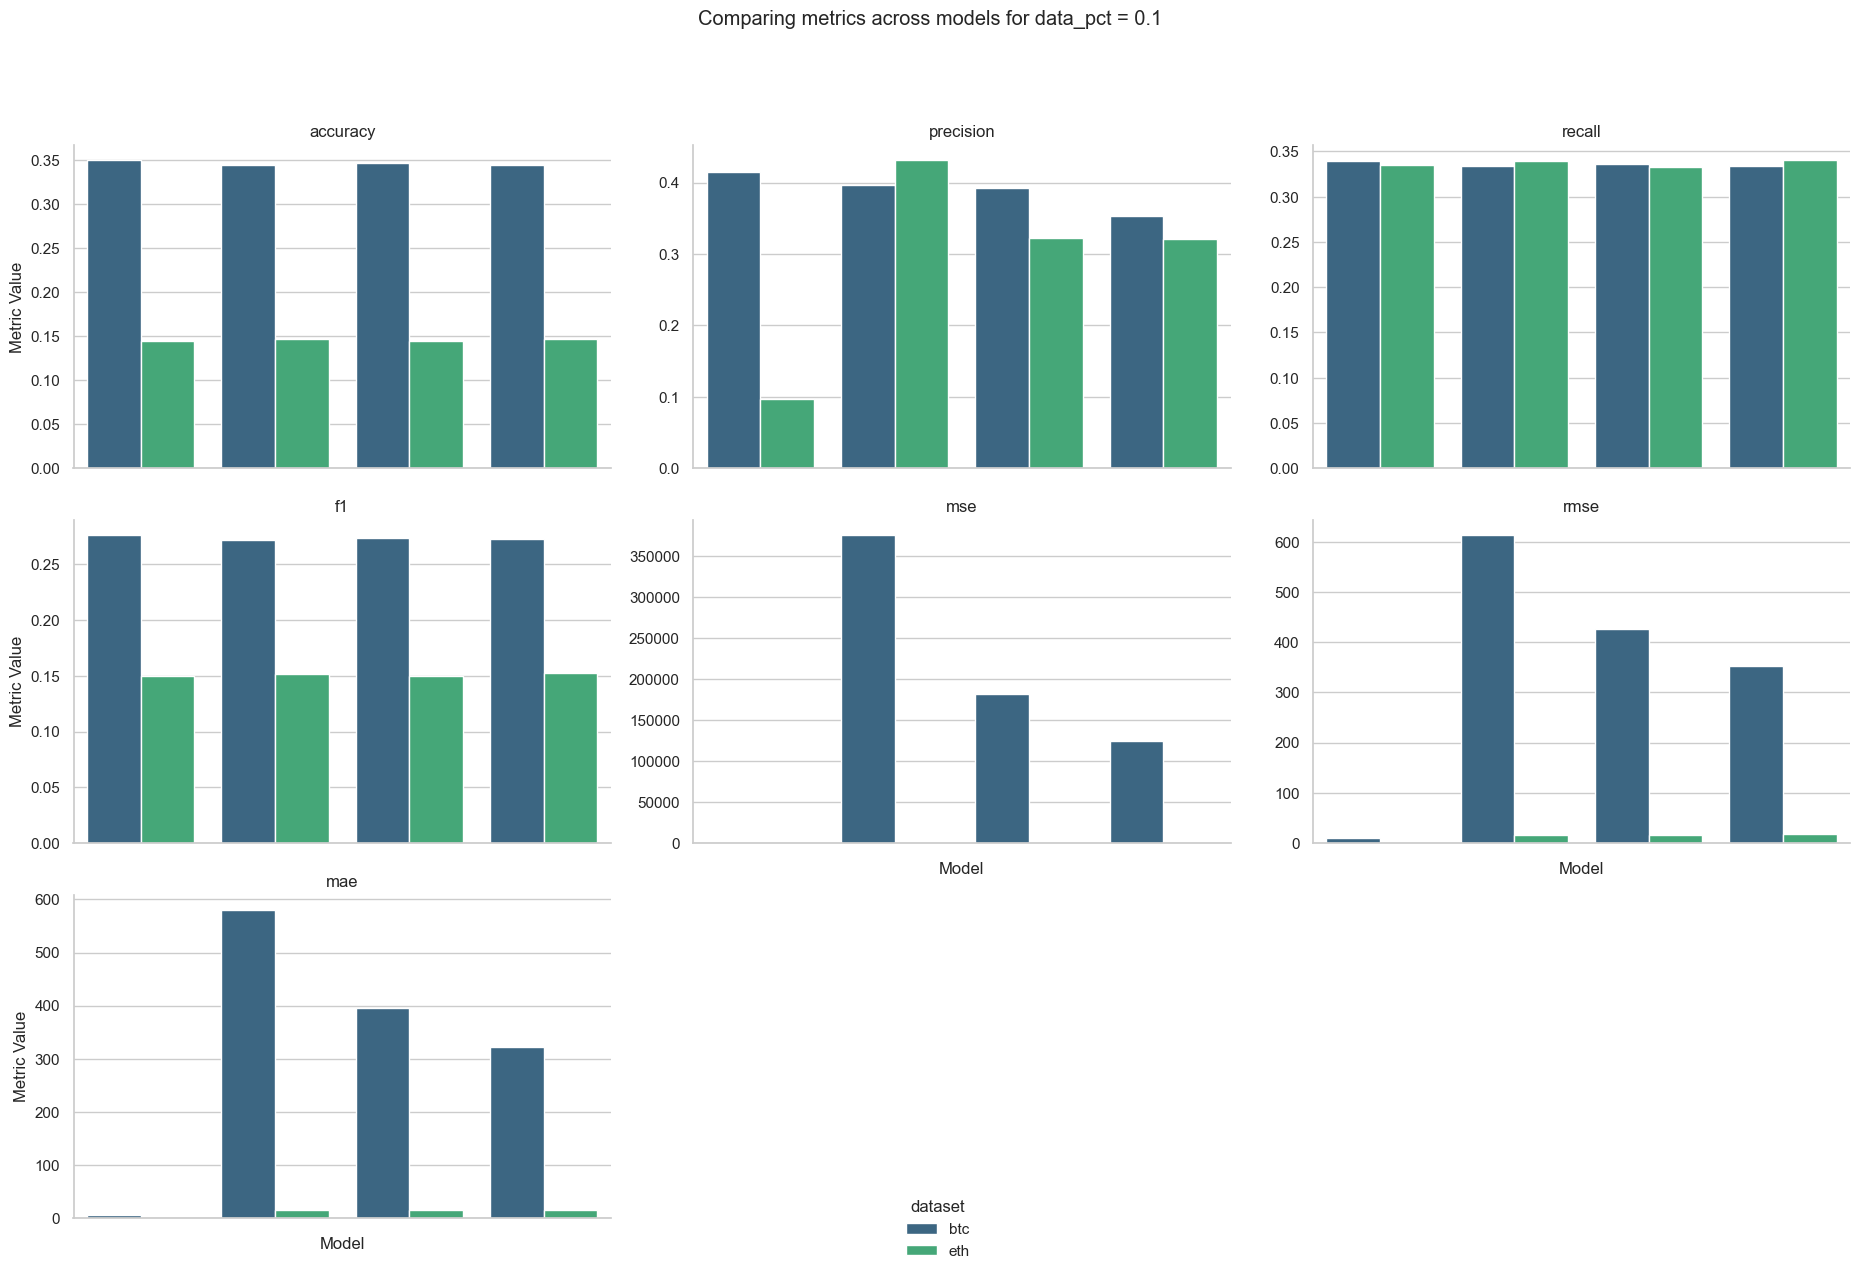

In [431]:
plot_metrics_by_pct(metrics_files_df)

In [465]:
import os
import re

def extract_run_metadata_from_path(path):
    path = path.replace("\\", "/").lower()
    model = None
    asset = None
    data_pct = None
    stop_loss = None

    known_models = ["gru", "cnn", "rnn", "transformer"]
    known_assets = ["btc", "eth", "etc", "ltc", "xrp"]

    for token in path.split("/"):
        for m in known_models:
            if m in token:
                model = m.upper()
        for a in known_assets:
            if a in token:
                asset = a.upper()

    pct_match = re.search(r"(\d+(?:\.\d+)?)pct", path)
    if pct_match:
        data_pct = float(pct_match.group(1)) / 100.0

    stop_match = re.search(r"sl[-_]?(\d+(?:\.\d+)?)", path)
    if stop_match:
        stop_loss = float(stop_match.group(1))

    return model, asset, data_pct, stop_loss


In [466]:
def parse_multi_line_dataframe(multiline_str):
    if not isinstance(multiline_str, str):
        return None
    excluded_keywords = ["dataset", "model", "data_pct", "pct", "loss"]
    lines = multiline_str.splitlines()
    clean_lines = []
    for line in lines:
        if not line.strip():
            continue
        if re.search(r"\[\d+\s+rows\s+x\s+\d+\s+columns\]", line):
            continue
        line_lower = line.lower()
        if any(kw in line_lower for kw in excluded_keywords):
            continue
        clean_lines.append(line.strip())
    if len(clean_lines) < 2:
        return None
    try:
        return pd.read_csv(io.StringIO("\n".join(clean_lines)), delim_whitespace=True)
    except:
        return None



In [476]:
def parse_from_filename(filepath):
    path = filepath.replace("\\", "/").lower()
    pattern = r"([a-z]+)_([a-z]+)_((?:\d+_)?\d+)pct_((?:\d+_)?\d+)stloss"
    match = re.search(pattern, path)
    if not match:
        return None, None, None, None
    model = match.group(1).upper()
    asset = match.group(2).upper()
    pct_str = match.group(3).replace("_", ".")
    sl_str = match.group(4).replace("_", ".")
    try:
        data_pct = float(pct_str)
        stop_loss = float(sl_str)
    except ValueError:
        data_pct = None
        stop_loss = None
    return model, asset, data_pct, stop_loss


In [468]:
def compile_backtest_stats(root_dir="results", pattern="**/backtest_stats.csv"):
    csv_files = sorted(glob.glob(os.path.join(root_dir, pattern), recursive=True))
    rows = []
    for path in csv_files:
        df_tmp = pd.read_csv(path, header=None, names=["Metric", "Value"])
        meta = df_tmp.set_index("Metric")["Value"].to_dict()
        strategy = meta.pop("_strategy", None)
        equity_str = meta.pop("_equity_curve", None)
        trades_str = meta.pop("_trades", None)
        equity_df = parse_multi_line_dataframe(equity_str)
        trades_df = parse_multi_line_dataframe(trades_str)
        model, asset, data_pct, stop_loss = parse_from_filename(path)
        meta["SourceCSV"] = path
        meta["Strategy"] = strategy
        meta["Model"] = model
        meta["Asset"] = asset
        meta["DataPct"] = data_pct
        meta["StopLoss"] = stop_loss
        meta["_equity_curve_df"] = equity_df
        meta["_trades_df"] = trades_df
        rows.append(meta)
    df_all = pd.DataFrame(rows)
    skip_cols = ["SourceCSV", "Strategy", "Model", "Asset", "_equity_curve_df", "_trades_df"]
    for col in df_all.columns:
        if col not in skip_cols:
            df_all[col] = pd.to_numeric(df_all[col], errors="coerce")
    return df_all

In [475]:
parse_from_filename("cnn_btc_1pct_0_3stloss")      
# → ('CNN', 'BTC', 1.0, 0.3)

parse_from_filename("gru_eth_0_1pct_0_3stloss")
# → ('GRU', 'ETH', 0.1, 0.3)


('GRU', 'ETH', 0.1, 0.3)

In [485]:
df_backtests = compile_backtest_stats("results")

print(f"Found {len(df_backtests)} backtest files.")

Found 24 backtest files.


In [487]:
# Remove columns where the name is NaN
df_backtests = df_backtests.loc[:, df_backtests.columns.notna()]

In [488]:
df_backtests.to_csv("results/compiled_backtest_stats.csv", index=False)

In [490]:
RESULT_DIR = "results"

In [493]:
top_by_return = df_backtests.sort_values("Return [%]", ascending=False).head(10)
display(top_by_return[["Model", "Asset", "DataPct", "StopLoss", "Return [%]", "Sharpe Ratio", "# Trades"]])


,Model,Asset,DataPct,StopLoss,Return [%],Sharpe Ratio,# Trades
4,CNN,ETH,10.0,0.3,9.482924e+06,NaN,3225.0
1,CNN,BTC,10.0,0.3,4.011455e+04,NaN,16195.0
14,RNN,BTC,1.0,0.3,6.751656e+02,NaN,1409.0
2,CNN,BTC,1.0,0.3,2.606527e+02,NaN,1235.0
16,RNN,ETH,10.0,0.3,1.320176e+02,NaN,203.0
22,TRANSFORMER,ETH,10.0,0.3,1.262043e+02,NaN,65.0
8,GRU,BTC,1.0,0.3,9.164694e+01,NaN,915.0
10,GRU,ETH,10.0,0.3,3.911368e+01,NaN,62.0
19,TRANSFORMER,BTC,10.0,0.3,3.318319e+01,NaN,284.0
23,TRANSFORMER,ETH,1.0,0.3,3.173180e+01,NaN,14.0


In [494]:
most_trades = df_backtests.sort_values("# Trades", ascending=False).head(10)
display(most_trades[["Model", "Asset", "DataPct", "# Trades", "Return [%]", "Profit Factor"]])

,Model,Asset,DataPct,# Trades,Return [%],Profit Factor
1,CNN,BTC,10.0,16195.0,4.011455e+04,1.238530
4,CNN,ETH,10.0,3225.0,9.482924e+06,3.942599
14,RNN,BTC,1.0,1409.0,6.751656e+02,1.660300
2,CNN,BTC,1.0,1235.0,2.606527e+02,1.420146
8,GRU,BTC,1.0,915.0,9.164694e+01,1.223945
19,TRANSFORMER,BTC,10.0,284.0,3.318319e+01,1.661135
16,RNN,ETH,10.0,203.0,1.320176e+02,4.419062
7,GRU,BTC,10.0,163.0,7.218013e-01,1.046029
12,RNN,BTC,0.1,145.0,3.277372e+00,1.072097
11,GRU,ETH,1.0,134.0,1.907863e+01,1.815234


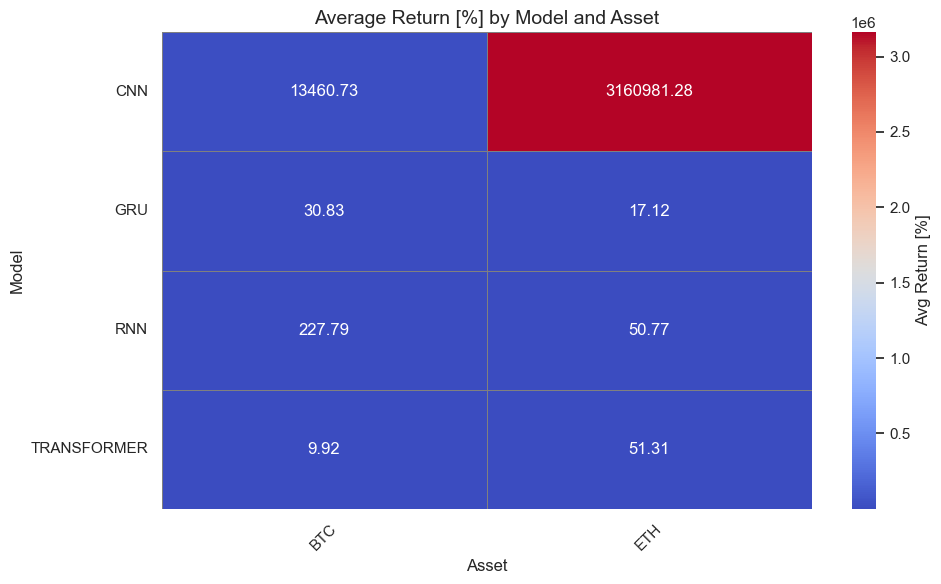

In [499]:
pivot_table = df_backtests.pivot_table(index="Model", columns="Asset", values="Return [%]", aggfunc="mean")

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Avg Return [%]"}
)
plt.title("Average Return [%] by Model and Asset", fontsize=14)
plt.xlabel("Asset", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "heatmap_return_by_model_asset.png"))
plt.show()


## Sentimental Analysis

In [193]:
realistic_parquet_path = os.path.join(PROCESSED_DATA, "aggregated_realistic_news_with_features_filtered.parquet")
agg_news_features_df = pd.read_parquet(realistic_parquet_path)


In [194]:
min_index = agg_news_features_df.index.min()
max_index = agg_news_features_df.index.max()
print("Min index:", min_index)
print("Max index:", max_index)

Min index: 2012-01-31 00:01:00
Max index: 2015-03-30 23:58:00


Note: We can only use the sentimental side using BTC, as the data we have for ETH does not overlap with ETH.


In [195]:
def get_boundary_for_percentage(features_df, targets_df, pct):
    common_index = features_df.index.intersection(targets_df.index).sort_values()
    total = len(common_index)
    subset_size = max(int(total * pct), 1)
    return common_index[0], common_index[subset_size - 1]

percentages = [0.01, 0.1]
for pct in percentages:
    start, end = get_boundary_for_percentage(btc_df_features, btc_targets, pct)
    print(f"{pct*100:.0f}% of data: Start = {start}, End = {end}")


1% of data: Start = 2012-01-31 10:45:00+00:00, End = 2012-09-23 12:39:00+00:00
10% of data: Start = 2012-01-31 10:45:00+00:00, End = 2014-02-06 14:02:00+00:00


This is one of the reasons why we utilized the 10% in the earlier 


In [196]:
def get_boundary_for_percentage(features_df, targets_df, pct):
    common_index = features_df.index.intersection(targets_df.index).sort_values()
    total = len(common_index)
    subset_size = max(int(total * pct), 1)
    start = common_index[0]
    end = common_index[subset_size - 1]
    print(f"{pct*100:.0f}% of data: Start = {start}, End = {end}")
    return start, end


In [197]:
start_1, end_1 = get_boundary_for_percentage(btc_df_features, btc_targets, 0.01)
start_10, end_10 = get_boundary_for_percentage(btc_df_features, btc_targets, 0.1)


1% of data: Start = 2012-01-31 10:45:00+00:00, End = 2012-09-23 12:39:00+00:00
10% of data: Start = 2012-01-31 10:45:00+00:00, End = 2014-02-06 14:02:00+00:00


In [198]:
def localize_to_utc(ts):
    return ts.tz_convert("UTC") if ts.tzinfo is not None else ts.tz_localize("UTC")

start_10 = localize_to_utc(start_10)
end_10 = localize_to_utc(end_10)


In [199]:
agg_news_features_df = agg_news_features_df.drop(columns=["id"])

In [200]:
agg_news_features_df.index = pd.to_datetime(agg_news_features_df.index).tz_localize("UTC")

news_data_df = agg_news_features_df.loc[
    (agg_news_features_df.index >= start_10) &
    (agg_news_features_df.index <= end_10)]

In [201]:
analysis_data = news_data_df.merge(
    btc_df_features[['Close']], left_index=True, right_index=True, how='inner'
)

analysis_data = analysis_data.rename(columns={'sentiment_score_mean': 'news_sentiment'})


In [202]:
analysis_data['btc_next_min_change'] = (
    analysis_data['Close'].shift(-1) / analysis_data['Close'] - 1
)


In [203]:
def classify_news(score, pos_threshold=0.55, neg_threshold=0.45):
    if score > pos_threshold:
        return 1
    elif score < neg_threshold:
        return -1
    return 0

def classify_btc(change):
    if change > 0:
        return 1
    elif change < 0:
        return -1
    return 0

analysis_data['predicted_sentiment'] = analysis_data['news_sentiment'].apply(classify_news)
analysis_data['actual_movement'] = analysis_data['btc_next_min_change'].apply(classify_btc)


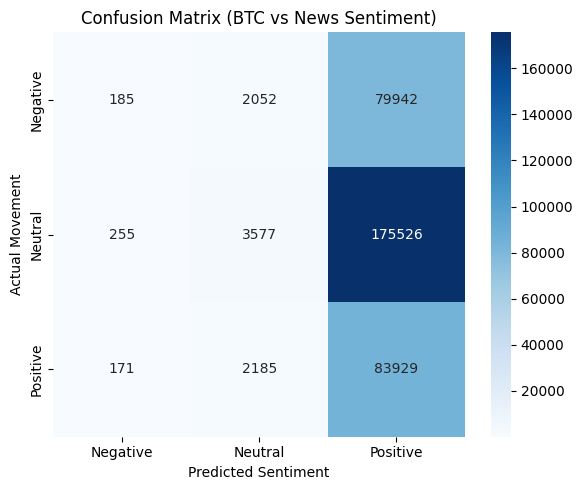

In [67]:

labels = [-1, 0, 1]
label_names = ['Negative', 'Neutral', 'Positive']


cm = confusion_matrix(
    analysis_data['actual_movement'],
    analysis_data['predicted_sentiment'],
    labels=labels
)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Movement')
plt.title('Confusion Matrix (BTC vs News Sentiment)')
plt.tight_layout()
plt.savefig("plots/confusion_matrix_finbert_btc_10pct.png", dpi=300)
plt.show()


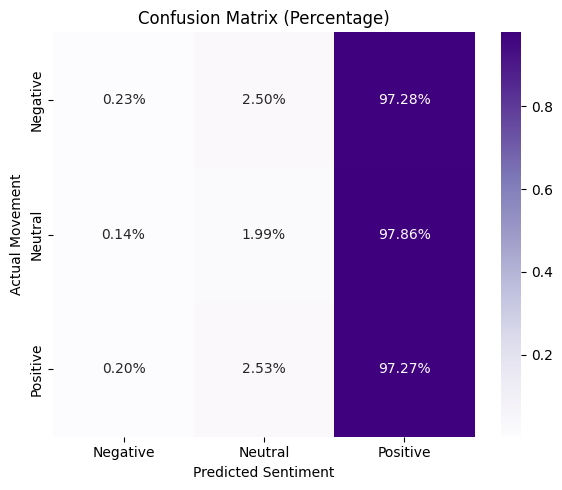

In [68]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Purples',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Movement')
plt.title('Confusion Matrix (Percentage)')
plt.tight_layout()
plt.savefig("plots/confusion_matrix_pct_finbert_btc_10pct.png", dpi=300)

plt.show()


In [69]:
print("\nClassification Report:")
print(classification_report(
    analysis_data['actual_movement'],
    analysis_data['predicted_sentiment'],
    labels=[-1, 0, 1]
))


Classification Report:
              precision    recall  f1-score   support

          -1       0.30      0.00      0.00     82179
           0       0.46      0.02      0.04    179358
           1       0.25      0.97      0.39     86285

    accuracy                           0.25    347822
   macro avg       0.34      0.33      0.15    347822
weighted avg       0.37      0.25      0.12    347822



## Combining Models and Senimental Analysis Results

### Getting data from all of the models

Since we are using 10% we can skip the analysis with anything else. 


We can just slice the data in the same way because the models use the first 10% of the time-sorted index during training. This ensures we're pulling the exact same chronological data used across all model comparisons.


In [117]:
DATA_PERCENT = .10

In [118]:
common_idx = btc_df_features.index.intersection(btc_targets.index).sort_values()
subset_dates = common_idx[:int(len(common_idx) * DATA_PERCENT)]

btc_data_10_df = btc_df_features.loc[subset_dates].copy()
btc_data_10_df["timestamp"] = pd.to_datetime(btc_data_10_df.index)

min_idx = btc_data_10_df.index.min()
max_idx = btc_data_10_df.index.max()

print("Min index:", min_idx)
print("Max index:", max_idx)

Min index: 2012-01-31 10:45:00+00:00
Max index: 2014-02-06 14:02:00+00:00


In [119]:
X_raw, y_raw, _, _ = get_data_subset(btc_df_features, btc_targets, "btc_Close_1m_later", data_percent=DATA_PERCENT)

Total data values in intersection: 6283462
Number of data points to use: 628346
Start of subset: 2012-01-31 10:45:00+00:00
End of subset: 2014-02-06 14:02:00+00:00


In [120]:
X_scaled, scaler = scale_features(X_raw)
y_raw_values = y_raw.values
X_seq, y_seq, all_indices = create_sequences(X_scaled, y_raw_values, time_steps=30)
X_train, y_train, X_test, y_test, idx_train, idx_test = train_test_split_sequences(
    X_seq, y_seq, all_indices, train_ratio=0.8
)


In [121]:
print("btc_df_features index type:", type(btc_df_features.index))
print("btc_df_features index dtype:", btc_df_features.index.dtype)
print("btc_df_features index sample:", btc_df_features.index[:5])

print("X_raw index type:", type(X_raw.index))
print("X_raw index dtype:", X_raw.index.dtype)
print("X_raw index sample:", X_raw.index[:5])


btc_df_features index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
btc_df_features index dtype: datetime64[ns, UTC]
btc_df_features index sample: DatetimeIndex(['2012-01-31 10:45:00+00:00', '2012-01-31 10:46:00+00:00',
               '2012-01-31 10:47:00+00:00', '2012-01-31 10:48:00+00:00',
               '2012-01-31 10:49:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', freq=None)
X_raw index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
X_raw index dtype: datetime64[ns, UTC]
X_raw index sample: DatetimeIndex(['2012-01-31 10:45:00+00:00', '2012-01-31 10:46:00+00:00',
               '2012-01-31 10:47:00+00:00', '2012-01-31 10:48:00+00:00',
               '2012-01-31 10:49:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', freq=None)


In [ ]:
btc_df_features.index = pd.to_datetime(btc_df_features.index.astype(str), format='%Y%m%d%H%M', utc=True)

In [123]:
all_test_index_in_btc_df = X_raw.index[idx_test]

In [132]:
df_test = btc_df_features.loc[all_test_index_in_btc_df].sort_index()
idx_to_target = {}
for seq_num, start_i in enumerate(idx_test):
    last_pos = start_i + 29
    if last_pos < len(X_raw):
        # Convert from position (last_pos) to the original dataframe index
        last_row_index = X_raw.index[last_pos]
        idx_to_target[last_row_index] = y_test[seq_num]

target_series = pd.Series(idx_to_target, name="btc_Close_1m_later")

btc_df_test_with_target = df_test.join(target_series, how="left")

In [151]:
pct_str = "_10pct" if DATA_PERCENT == 0.1 else "_1pct"


In [152]:
result_files = [
    f for f in os.listdir(RESULT_DATA_DIR)
    if f.endswith(f"{pct_str}_comparison.csv") and "_btc_" in f.lower()
]


print(f"Found {len(result_files)} BTC result file(s) for {pct_str}.")


Found 4 BTC result file(s) for _10pct.


In [153]:
import os
import re
import pandas as pd

df_list = []

for file in result_files:
    print(f"Loading: {file}")
    df = pd.read_csv(os.path.join(RESULT_DATA_DIR, file))
    df.columns = [col.strip().lower() for col in df.columns]
    match = re.match(r'(.*?)_', file)
    model_name = match.group(1).lower() if match else "unknown"
    if "actual" in df.columns and model_name not in ["x", "y"]:
        df.rename(columns={"actual": f"actual_{model_name}"}, inplace=True)
    pred_cols = [c for c in df.columns if "pred" in c or c == "predicted"]
    if len(pred_cols) == 1:
        df.rename(columns={pred_cols[0]: f"{model_name}_predicted"}, inplace=True)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    else:
        raise ValueError(f"'date' column not found in file: {file}")
    df.reset_index(drop=True, inplace=True)
    print(f"  Shape: {df.shape}")
    df_list.append(df)

merged_predictions_df = df_list[0]
for df in df_list[1:]:
    merged_predictions_df = pd.merge(merged_predictions_df, df, on='date', how='outer')

merged_predictions_df.insert(0, 'new_id', merged_predictions_df.index)
print("Final Merged DataFrame Shape:", merged_predictions_df.shape)
print("Final Merged DataFrame Columns:", list(merged_predictions_df.columns))


Loading: cnn_btc_10pct_comparison.csv
  Shape: (125664, 3)
Loading: gru_btc_10pct_comparison.csv
  Shape: (125664, 3)
Loading: rnn_btc_10pct_comparison.csv
  Shape: (125664, 3)
Loading: transformer_btc_10pct_comparison.csv
  Shape: (125664, 3)
Final Merged DataFrame Shape: (125664, 10)
Final Merged DataFrame Columns: ['new_id', 'date', 'actual_cnn', 'cnn_predicted', 'actual_gru', 'gru_predicted', 'actual_rnn', 'rnn_predicted', 'actual_transformer', 'transformer_predicted']


In [155]:
actual_cols = [col for col in merged_predictions_df.columns if "actual" in col]
if actual_cols:
    first_actual = actual_cols[0]
    merged_predictions_df.rename(columns={first_actual: "target"}, inplace=True)


In [156]:
cols_to_drop = [
    col for col in merged_predictions_df.columns
    if "actual_" in col or col.startswith("unnamed:")
]


In [157]:
merged_predictions_df.drop(columns=cols_to_drop, inplace=True)

print("Remaining columns:", merged_predictions_df.columns.tolist())


Remaining columns: ['new_id', 'date', 'target', 'cnn_predicted', 'target', 'gru_predicted', 'rnn_predicted', 'transformer_predicted']


In [158]:
merged_predictions_df.drop(columns=["new_id"], inplace=True)


In [159]:
# Print the shape of btc_df_test_with_target
print("Shape of btc_df_test_with_target:", btc_df_test_with_target.shape)

# Print the shape of merged_predictions_df
print("Shape of merged_predictions_df:", merged_predictions_df.shape)


Shape of btc_df_test_with_target: (125664, 46)
Shape of merged_predictions_df: (125664, 7)


In [160]:
merged_predictions_df["date"] = (
    pd.to_datetime(merged_predictions_df["date"], errors="coerce")
      .dt.strftime("%Y%m%d%H%M")
)

btc_df_test_with_target['date'] = btc_df_test_with_target.index.astype(str)


btc_df_test_with_target["date"] = (
    pd.to_datetime(btc_df_test_with_target["date"], errors="coerce")
      .dt.strftime("%Y%m%d%H%M")
)

In [161]:
merged_predictions_df["date"] = pd.to_datetime(merged_predictions_df["date"], errors="coerce", utc=True)
merged_predictions_df.set_index("date", inplace=True)


In [163]:
df_test_predictions_merged = pd.merge(
    btc_df_test_with_target,
    merged_predictions_df,
    left_index=True,
    right_index=True,
    how="inner"
)

In [171]:
df_test_predictions_merged.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Close_1m_ago',
       'PctChange_1m', 'Close_5m_ago', 'PctChange_5m', 'Close_1h_ago',
       'PctChange_1h', 'Close_1d_ago', 'PctChange_1d', 'Close_1w_ago',
       'PctChange_1w', 'Close_1mo_ago', 'PctChange_1mo', 'SMA_20', 'EMA_20',
       'SMA_50', 'EMA_50', 'SMA_200', 'EMA_200', 'RSI_14', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower',
       'VolMA_short', 'VolMA_long', 'VolumeOscillator', 'OBV', 'candle_range',
       'body_size', 'Doji', 'ATR', '+DI', '-DI', 'ADX', '%K', '%D',
       'Williams_%R', 'date', 'target', 'cnn_predicted', 'target',
       'gru_predicted', 'rnn_predicted', 'transformer_predicted'],
      dtype='object')

In [ ]:
df_test_predictions_merged.drop(columns=["btc_Close_1m_later", "date"], inplace=True)

In [177]:
duplicate_columns = df_test_predictions_merged.columns[df_test_predictions_merged.columns.duplicated()].unique()
print("Duplicate columns:", duplicate_columns)


Duplicate columns: Index(['target'], dtype='object')


In [178]:
def remove_identical_duplicates(df):
    new_df = df.copy()
    dup_names = [col for col in new_df.columns if list(new_df.columns).count(col) > 1]
    for col in set(dup_names):
        idx = [i for i, c in enumerate(new_df.columns) if c == col]
        if all(new_df.iloc[:, idx[i]].equals(new_df.iloc[:, idx[i + 1]]) for i in range(len(idx) - 1)):
            new_df = new_df.loc[:, ~new_df.columns.duplicated()]
    return new_df

df_test_predictions_merged = remove_identical_duplicates(df_test_predictions_merged)


In [168]:
output_file = os.path.join(PROCESSED_DATA, "btc_test_predictions_with_features.csv.gz")
df_test_predictions_merged.to_csv(output_file, compression="gzip")


In [206]:
btc_predictions_news_df = df_test_predictions_merged.merge(
    news_data_df, left_on="date", right_on="datetime", how="inner"
)


In [213]:
# Create an empty list to store pairs of duplicate columns based on content
duplicate_columns_content = []

# Get a list of columns
cols = btc_predictions_news_df.columns
n_cols = len(cols)

# Iterate over each pair of columns
for i in range(n_cols):
    for j in range(i + 1, n_cols):
        if btc_predictions_news_df[cols[i]].equals(btc_predictions_news_df[cols[j]]):
            duplicate_columns_content.append((cols[i], cols[j]))

# Print results
if duplicate_columns_content:
    print("Duplicate columns based on content found:", duplicate_columns_content)
else:
    print("No duplicate columns based on content were found.")


Duplicate columns based on content found: [('SMA_20', 'BB_Middle')]


In [217]:
column_comparison = []
cols = btc_predictions_news_df.columns
n_cols = len(cols)

for i in range(n_cols):
    for j in range(i + 1, n_cols):
        dp = (btc_predictions_news_df[cols[i]] == btc_predictions_news_df[cols[j]]).mean() * 100
        column_comparison.append((cols[i], cols[j], dp))

column_comparison_sorted = sorted(column_comparison, key=lambda x: x[2], reverse=True)
high_duplicates = [pair for pair in column_comparison_sorted if pair[2] >= 80]
top_pairs = high_duplicates[:5]

print("Top duplicate column pairs (above 80% similarity):")
for col1, col2, percentage in top_pairs:
    print(f"{col1} & {col2} -> {percentage:.2f}% identical")


Top duplicate column pairs (above 80% similarity):
SMA_20 & BB_Middle -> 100.00% identical


SMA_20 and BB_Middle are 100% identical because the Bollinger Bands middle line is simply the 20-period simple moving average computed on the same data.

In [ ]:
btc_predictions_news_df.drop(columns=["BB_Middle", "date"], inplace=True)

In [306]:
LAST_PLOT = "./plots/final_o-scope/"
os.makedirs(LAST_PLOT, exist_ok=True)

In [292]:
def identify_feature_groups(df):
    groups = {}
    groups['Price'] = [col for col in ['Open', 'High', 'Low', 'Close', 'Volume'] if col in df.columns]
    groups['Historical Changes'] = [col for col in df.columns if 'PctChange' in col]
    groups['Historical Prices'] = [col for col in df.columns if '_ago' in col and 'PctChange' not in col]
    groups['Moving Averages'] = [col for col in df.columns if 'SMA_' in col or 'EMA_' in col]
    groups['Oscillators'] = [col for col in ['RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist', 'VolumeOscillator', '%K', '%D', 'Williams_%R', 'OBV'] if col in df.columns]
    groups['Bollinger Bands'] = [col for col in ['BB_Middle', 'BB_Upper', 'BB_Lower'] if col in df.columns]
    groups['Candlestick'] = [col for col in ['candle_range', 'body_size', 'Doji'] if col in df.columns]
    groups['Trend'] = [col for col in ['ATR', '+DI', '-DI', 'ADX'] if col in df.columns]
    groups['Time'] = [col for col in ['hour', 'minute_of_hour', 'weekday'] if col in df.columns]
    groups['News Sentiment'] = [col for col in df.columns if any(x in col for x in ['sentiment', 'article', 'char_count', 'word_count'])]
    groups['Model Predictions'] = [col for col in df.columns if '_predicted' in col]
    return {k: v for k, v in groups.items() if v}


In [293]:
def evaluate_model_with_cv(model, X, y, cv=5):
    scores = cross_validate(model, X, y, 
                              scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                              cv=cv, return_train_score=True)
    return {
        'RMSE': np.sqrt(-scores['test_neg_mean_squared_error'].mean()),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'R²': scores['test_r2'].mean(),
        'Train RMSE': np.sqrt(-scores['train_neg_mean_squared_error'].mean()),
        'Train R²': scores['train_r2'].mean()
    }

def analyze_feature_importance(model, feature_names, top_n=20):
    if not hasattr(model, 'feature_importances_'):
        return None
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:top_n]
    top_features = [feature_names[i] for i in top_indices]
    top_importances = importances[top_indices]
    return pd.DataFrame({'Feature': top_features, 'Importance': top_importances})


In [320]:
def categorize_features(features, feature_groups):
    categories = {}
    for feature in features:
        for group_name, group_features in feature_groups.items():
            if feature in group_features:
                categories[feature] = group_name
                break
        if feature not in categories:
            categories[feature] = 'Other'
    return categories

def get_group_importance(fi_df, feature_groups):
    cats = categorize_features(fi_df['Feature'], feature_groups)
    fi_df['Category'] = fi_df['Feature'].map(cats)
    return fi_df.groupby('Category')['Importance'].sum().sort_values(ascending=False)

def plot_feature_importance(fi_df, title="Feature Importance"):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Importance', y='Feature', data=fi_df.head(15), palette="viridis")
    for p in ax.patches:
        ax.text(p.get_width(), p.get_y() + p.get_height()/2, f"{p.get_width():.3f}", 
                ha='left', va='center')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{LAST_PLOT+title.lower().replace(' ', '_')}.png")
    plt.show()
    plt.close()
    return fi_df.head(15)

def plot_group_importance(group_importance, title="Feature Group Importance"):
    plt.figure(figsize=(12, 6))
    ax = group_importance.plot(kind='bar', color=sns.color_palette("deep", len(group_importance)))
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, p.get_height(), f"{p.get_height():.3f}", 
                ha='center', va='bottom')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{LAST_PLOT+title.lower().replace(' ', '_')}.png")
    plt.show()
    plt.close()
    return group_importance



In [ ]:
target_col = 'target'
if target_col not in btc_predictions_news_df.columns:
    raise Exception("No 'target' column found.")


In [ ]:
def evaluate_models(btc_df_copy, target_col, models, test_size=0.2, random_state=42):
    X = btc_df_copy.drop(target_col, axis=1)
    y = btc_df_copy[target_col]
    X = X.select_dtypes(include=[np.number])
    feature_groups = identify_feature_groups(btc_df_copy)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    results = []
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        results.append({'Model': name, 'RMSE': rmse, 'R²': r2})
         
        cv_res = evaluate_model_with_cv(model, X_train_scaled, y_train)
        print(f"{name} - CV RMSE: {cv_res['RMSE']:.4f}, CV R²: {cv_res['R²']:.4f}")
    
    results_df = pd.DataFrame(results).sort_values('R²', ascending=False)
    print("Model Performance:")
    print(results_df)
    
    best_model_name = results_df.iloc[0]['Model']
    
    return results_df, best_model_name, X_train_scaled, X_test_scaled, y_train, y_test, feature_groups


In [296]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'Elastic Net': ElasticNet(random_state=42)
}



In [298]:
results_df, best_model_name, X_train_scaled, X_test_scaled, y_train, y_test, feature_groups = evaluate_models(btc_predictions_news_df, target_col, models)

Random Forest - CV RMSE: 3.0279, CV R²: 0.9997
Gradient Boosting - CV RMSE: 3.3952, CV R²: 0.9996
XGBoost - CV RMSE: 3.1751, CV R²: 0.9997
Ridge - CV RMSE: 2.8724, CV R²: 0.9997
Lasso - CV RMSE: 3.4782, CV R²: 0.9996
Elastic Net - CV RMSE: 7.3620, CV R²: 0.9982
Model Performance:
               Model      RMSE        R²
3              Ridge  2.825327  0.999731
0      Random Forest  2.930265  0.999710
2            XGBoost  3.117420  0.999672
1  Gradient Boosting  3.328118  0.999627
4              Lasso  3.383002  0.999614
5        Elastic Net  7.344205  0.998181


In [323]:
print(f"Best model: {best_model_name} with R² = {results_df.iloc[0]['R²']:.4f}")

Best model: Ridge with R² = 0.9997


In [350]:
def evaluate_feature_groups(feature_groups, X_train_scaled, X_test_scaled, y_train, y_test, models, best_model_name):
    group_results = []
    for group_name, group_features in feature_groups.items():
        if not group_features:
            continue
        X_group_train = X_train_scaled[group_features]
        X_group_test = X_test_scaled[group_features]
        model = models[best_model_name]
        model.fit(X_group_train, y_train)
        y_pred = model.predict(X_group_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        group_results.append({'Group': group_name, 'Feature Count': len(group_features), 'RMSE': rmse, 'R²': r2})
    
    results_df = pd.DataFrame(group_results).sort_values('R²', ascending=False)
    return results_df


In [309]:

group_results_df, group_results = evaluate_feature_groups(feature_groups, X_train_scaled, X_test_scaled, y_train, y_test, models, best_model_name)
print("Feature Group Performance:")
group_results_df

Feature Group Performance:


,Group,Feature Count,RMSE,R²
0,Price,5,2.815154,0.999733
2,Historical Prices,6,3.697926,0.999539
3,Moving Averages,6,4.195025,0.999407
5,Bollinger Bands,3,6.392457,0.998622
10,Model Predictions,4,9.865397,0.996718
1,Historical Changes,6,152.274529,0.218133
9,News Sentiment,10,169.615310,0.029918
7,Trend,4,170.988119,0.014151
4,Oscillators,9,171.206004,0.011637
6,Candlestick,3,171.858621,0.004088


In [352]:
def evaluate_top_group_combinations(group_results_df, feature_groups, X_train_scaled, X_test_scaled, y_train, y_test, models, best_model_name, top_n=3):
    top_groups = group_results_df.head(top_n)['Group'].tolist()
    combination_results = []

    # Pairwise combinations
    for i in range(len(top_groups)):
        for j in range(i + 1, len(top_groups)):
            combined = feature_groups[top_groups[i]] + feature_groups[top_groups[j]]
            X_comb_train = X_train_scaled[combined]
            X_comb_test = X_test_scaled[combined]
            model = models[best_model_name]
            model.fit(X_comb_train, y_train)
            y_pred = model.predict(X_comb_test)
            combination_results.append({
                'Group': f"{top_groups[i]} + {top_groups[j]}",
                'Feature Count': len(combined),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'R²': r2_score(y_test, y_pred)
            })

    # All top groups combined
    if len(top_groups) >= 3:
        combined_all = []
        for g in top_groups:
            combined_all.extend(feature_groups[g])
        X_comb_train = X_train_scaled[combined_all]
        X_comb_test = X_test_scaled[combined_all]
        model = models[best_model_name]
        model.fit(X_comb_train, y_train)
        y_pred = model.predict(X_comb_test)
        combination_results.append({
            'Group': ' + '.join(top_groups),
            'Feature Count': len(combined_all),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R²': r2_score(y_test, y_pred)
        })

    return pd.DataFrame(combination_results).sort_values('R²', ascending=False)


In [312]:
group_results_df = evaluate_top_group_combinations(group_results_df, feature_groups, X_train_scaled, X_test_scaled, y_train, y_test, models, best_model_name)

print("Updated Group Performance:")
group_results_df

Updated Group Performance:


,Group,Feature Count,RMSE,R²
0,Price,5,2.815154,0.999733
11,Price + Historical Prices,11,2.817022,0.999732
14,Price + Historical Prices + Moving Averages,17,2.819512,0.999732
12,Price + Moving Averages,11,2.819865,0.999732
13,Historical Prices + Moving Averages,12,3.603006,0.999562
2,Historical Prices,6,3.697926,0.999539
3,Moving Averages,6,4.195025,0.999407
5,Bollinger Bands,3,6.392457,0.998622
10,Model Predictions,4,9.865397,0.996718
1,Historical Changes,6,152.274529,0.218133


In [357]:
def plot_top_feature_group_combinations(group_results_df, top_n=10, save_path=None):
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Group', y='R²', data=group_results_df.head(top_n), palette="viridis")
    
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2, p.get_height(), f"{p.get_height():.3f}",
                ha='center', va='bottom', fontsize=10)
    
    plt.title('Top Feature Group Combinations (R²)', fontsize=16)
    plt.xlabel('Group', fontsize=14)
    plt.ylabel('R² Score', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    plt.close()


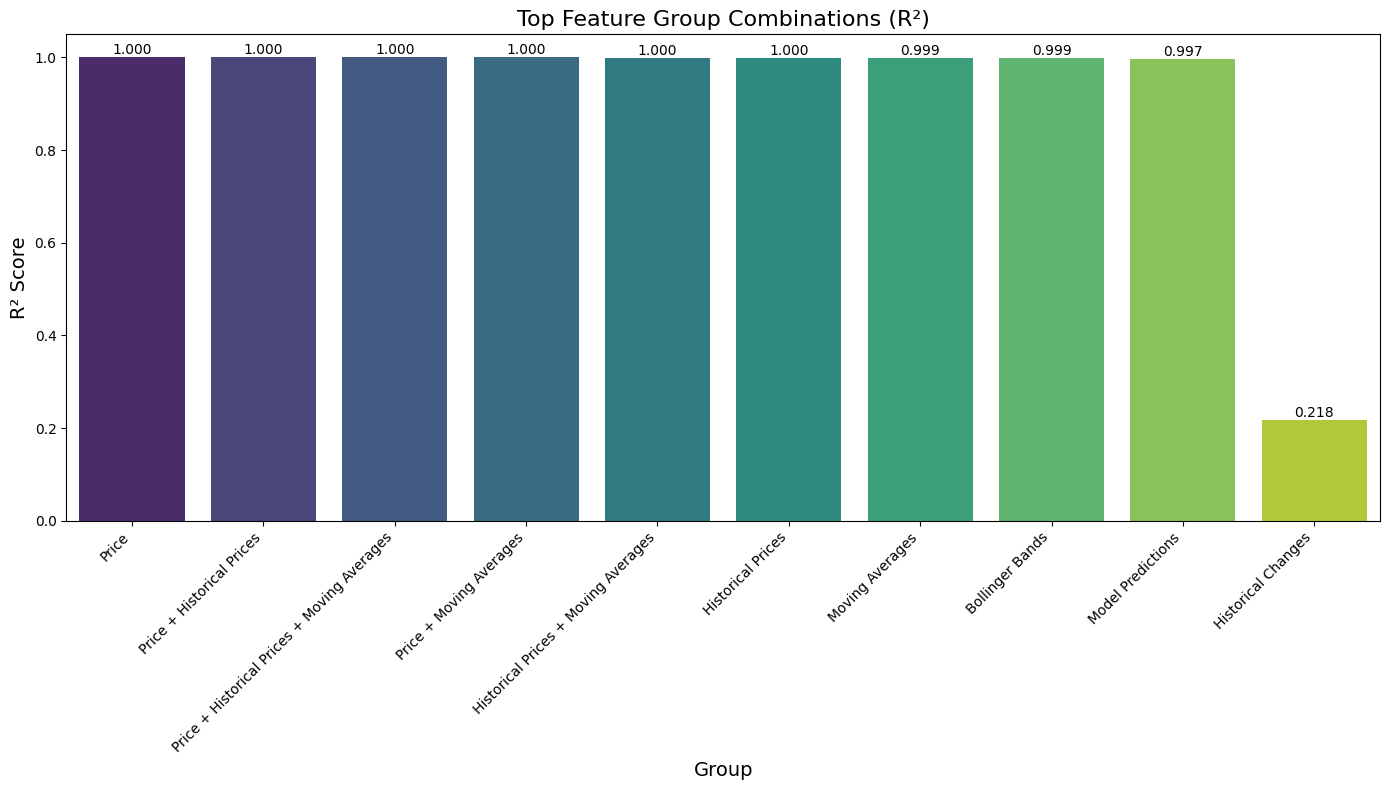

In [326]:
plot_top_feature_group_combinations(
    group_results_df=group_results_df,
    top_n=10,
    save_path=LAST_PLOT + 'feature_group_combinations.png'
)


This seems too high. The current day’s price might be adding too much bias. That could be fine when the market is normal, but when things get really volatile, it might not work well. We need a way to handle those situations better.

Just want to check if its the same for when we remove some of te highly corrolated rows:

In [333]:
btc_df_copy = btc_predictions_news_df.copy()

columns_to_remove = ['Open', 'High', 'Low', 'Volume']
btc_df_copy.drop(columns=columns_to_remove, inplace=True)

In [335]:
results_df, best_model_name, X_train_scaled, X_test_scaled, y_train, y_test, feature_groups = evaluate_models(btc_df_copy, target_col, models)

Random Forest - CV RMSE: 3.0910, CV R²: 0.9997
Gradient Boosting - CV RMSE: 3.3924, CV R²: 0.9996
XGBoost - CV RMSE: 3.2282, CV R²: 0.9996
Ridge - CV RMSE: 2.9388, CV R²: 0.9997
Lasso - CV RMSE: 3.1721, CV R²: 0.9997
Elastic Net - CV RMSE: 8.4526, CV R²: 0.9976
Model Performance:
               Model      RMSE        R²
3              Ridge  2.886442  0.999719
0      Random Forest  3.001694  0.999696
4              Lasso  3.109220  0.999674
2            XGBoost  3.146948  0.999666
1  Gradient Boosting  3.316232  0.999629
5        Elastic Net  8.435865  0.997600


In [360]:
print(f"Best model: {best_model_name} with R² = {results_df.iloc[0]['R²']:.4f}")

Best model: Ridge with R² = 0.9997


In [355]:
group_results_df = evaluate_feature_groups(
    feature_groups, X_train_scaled, X_test_scaled, y_train, y_test, models, best_model_name
)
print("Feature Group Performance:")
group_results_df


Feature Group Performance:


,Group,Feature Count,RMSE,R²
0,Price,1,2.939877,0.999709
2,Historical Prices,6,3.697926,0.999539
3,Moving Averages,6,4.195025,0.999407
5,Bollinger Bands,3,6.392457,0.998622
10,Model Predictions,4,9.865397,0.996718
1,Historical Changes,6,152.274529,0.218133
9,News Sentiment,10,169.615310,0.029918
7,Trend,4,170.988119,0.014151
4,Oscillators,9,171.206004,0.011637
6,Candlestick,3,171.858621,0.004088


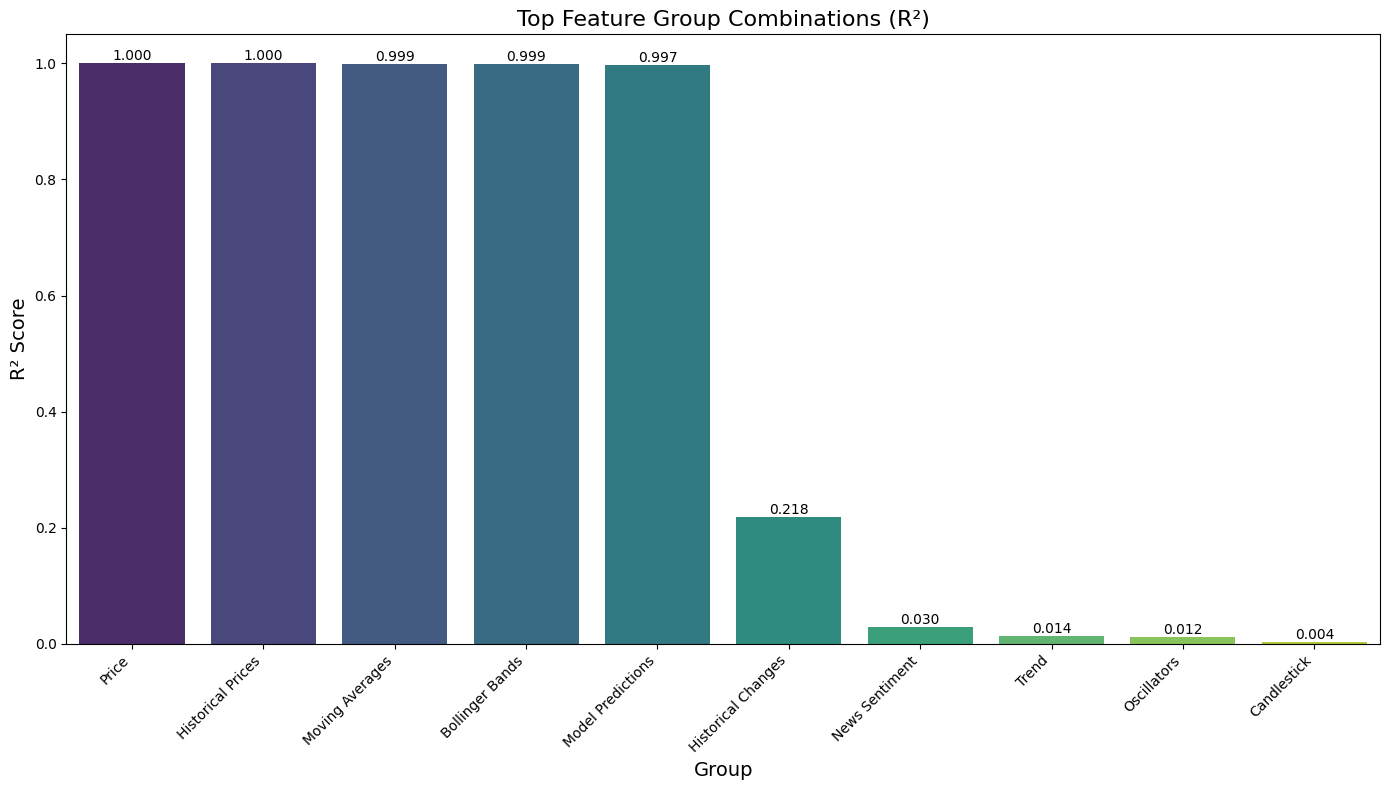

In [358]:
plot_top_feature_group_combinations(
    group_results_df=group_results_df,
    top_n=10,
    save_path=LAST_PLOT + 'feature_group_combinations_no_OHLV.png'
)


In [356]:
combo_results_df = evaluate_top_group_combinations(
    group_results_df,
    feature_groups,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    models,
    best_model_name,
    top_n=3
)

full_group_results_df = pd.concat([group_results_df, combo_results_df]).sort_values('R²', ascending=False)

print("Updated Group Performance:")
full_group_results_df

Updated Group Performance:


,Group,Feature Count,RMSE,R²
0,Price + Historical Prices,7,2.883165,0.999720
3,Price + Historical Prices + Moving Averages,13,2.886324,0.999719
1,Price + Moving Averages,7,2.919686,0.999713
0,Price,1,2.939877,0.999709
2,Historical Prices + Moving Averages,12,3.603006,0.999562
2,Historical Prices,6,3.697926,0.999539
3,Moving Averages,6,4.195025,0.999407
5,Bollinger Bands,3,6.392457,0.998622
10,Model Predictions,4,9.865397,0.996718
1,Historical Changes,6,152.274529,0.218133


Instead of forecasting the closing price directly, we propose analyzing the price change. Since the difference between the predicted and actual values is already minimal, focusing on this slight variation can lead to disproportionately high percentage errors. This alternative approach may provide clearer insights into model performance.

In [367]:
btc_for_pct_df = btc_df_copy.copy()

btc_for_pct_df['target'] = ((btc_for_pct_df['target'] - btc_for_pct_df['Close']) / btc_for_pct_df['Close']) * 100


In [369]:
btc_for_pct_df = btc_for_pct_df.iloc[1:].reset_index(drop=True)


In [ ]:
selected_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGB oost': XGBRegressor(n_estimators=100, random_state=42),
    'Ridge': Ridge(random_state=42),
}


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             accuracy_score, precision_score, recall_score, f1_score)
import numpy as np
import pandas as pd

def optimized_evaluate_models(btc_df_copy, target_col, models, problem_type='regression',
                              test_size=0.2, random_state=42, cv_folds=5):
    # Prepare features and target
    X = btc_df_copy.drop(target_col, axis=1).select_dtypes(include=[np.number])
    y = btc_df_copy[target_col]
    feature_groups = identify_feature_groups(btc_df_copy)
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state)
    results = []
    for name, model in models.items():
        # Build pipeline: scaling + model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('estimator', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Compute scores based on problem type
        if problem_type == 'regression':
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            metrics = {'RMSE': rmse, 'R²': r2, 'MAE': mae}
            
            # Cross-validation scores (using negatives for errors)
            cv_rmse = np.mean(np.sqrt(-cross_val_score(pipeline, X_train, y_train,
                                                        cv=cv_folds,
                                                        scoring='neg_mean_squared_error',
                                                        n_jobs=-1)))
            cv_r2 = np.mean(cross_val_score(pipeline, X_train, y_train,
                                            cv=cv_folds,
                                            scoring='r2',
                                            n_jobs=-1))
            cv_mae = np.mean(cross_val_score(pipeline, X_train, y_train,
                                             cv=cv_folds,
                                             scoring='neg_mean_absolute_error',
                                             n_jobs=-1))
            cv_mae = -cv_mae
            print(f"{name} - CV RMSE: {cv_rmse:.4f}, CV R²: {cv_r2:.4f}, CV MAE: {cv_mae:.4f}")
        
        elif problem_type == 'classification':
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}
            
            # Cross-validation scores for classification
            cv_accuracy = np.mean(cross_val_score(pipeline, X_train, y_train,
                                                  cv=cv_folds,
                                                  scoring='accuracy',
                                                  n_jobs=-1))
            cv_precision = np.mean(cross_val_score(pipeline, X_train, y_train,
                                                   cv=cv_folds,
                                                   scoring='precision_weighted',
                                                   n_jobs=-1))
            cv_recall = np.mean(cross_val_score(pipeline, X_train, y_train,
                                                cv=cv_folds,
                                                scoring='recall_weighted',
                                                n_jobs=-1))
            cv_f1 = np.mean(cross_val_score(pipeline, X_train, y_train,
                                            cv=cv_folds,
                                            scoring='f1_weighted',
                                            n_jobs=-1))
            print(f"{name} - CV Accuracy: {cv_accuracy:.4f}, CV Precision: {cv_precision:.4f}, "
                  f"CV Recall: {cv_recall:.4f}, CV F1: {cv_f1:.4f}")
        else:
            raise ValueError("problem_type must be either 'regression' or 'classification'")
        
        # Append the metrics to the results list (include model name)
        result = {'Model': name}
        result.update(metrics)
        results.append(result)
    
    results_df = pd.DataFrame(results).sort_values(by=list(metrics.keys())[-1], ascending=False)
    print("Model Performance:")
    print(results_df)
    
    best_model_name = results_df.iloc[0]['Model']
    return results_df, best_model_name, X_train, X_test, y_train, y_test, feature_groups


In [381]:
results_df, best_model_name, X_train, X_test, y_train, y_test, feature_groups = optimized_evaluate_models(btc_for_pct_df, target_col='target', models=selected_models)

Starting model evaluation for regression models...
Preparing features and target...
Splitting data into training and test sets...

Evaluating model: Random Forest
Fitting the model pipeline...
Random Forest metrics -> RMSE: 0.4261, R2: 0.0652, MAE: 0.2128
Random Forest CV scores  -> RMSE: 0.4052, R2: 0.0592, MAE: 0.2102

Final Model Performance:
           Model      RMSE        R2       MAE
0  Random Forest  0.426137  0.065163  0.212811

Best performing model: Random Forest


In [392]:
import pandas as pd

# Define the data to save
metrics_data = {
    "dataset": "btc",
    "model": "random-forest",
    "data_pct": 0.001,
    "r2": 0.065163,
    "rmse": 0.426137,
    "mae": 0.212811
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_data])

# Path to save the CSV
output_file = r".\model-result-data\random_forest_btc_0_1pct_metrics.csv"

# Save as a CSV
metrics_df.to_csv(output_file, index=False)

print(f"Metrics saved to: {output_file}")


Metrics saved to: .\model-result-data\random_forest_btc_0_1pct_metrics.csv


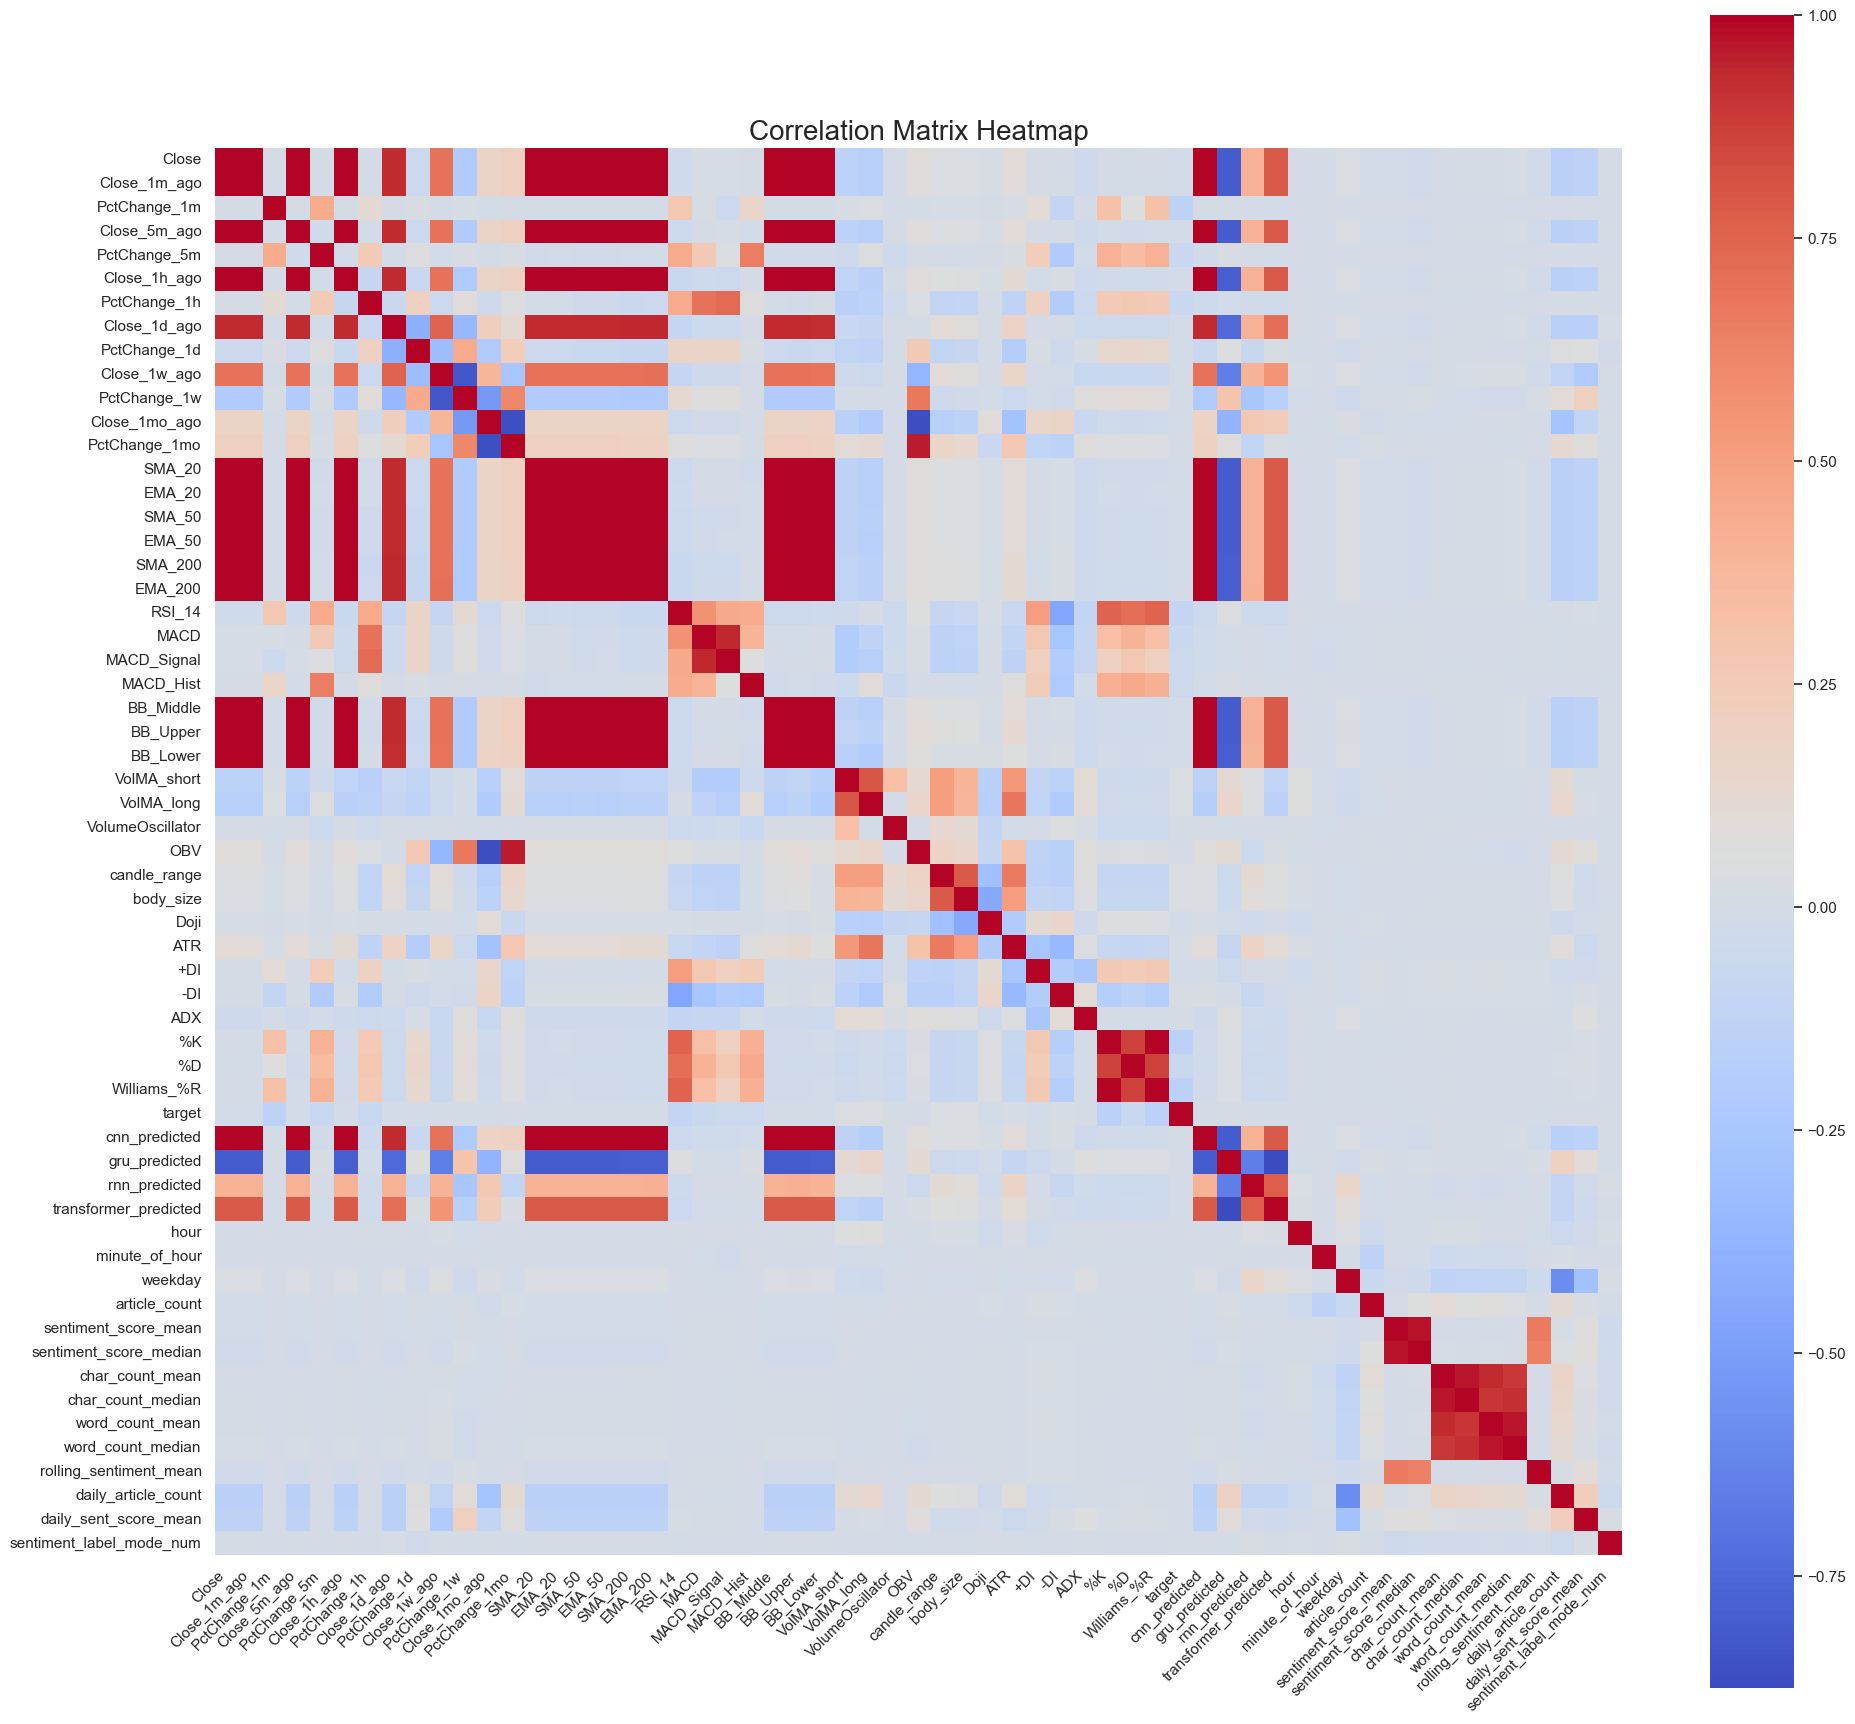

In [509]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = btc_for_pct_df.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", square=True, cbar=True,
            xticklabels=True, yticklabels=True)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Matrix Heatmap", fontsize=20)

plt.tight_layout()
plt.show()


In [506]:
n = 10
corr_matrix = btc_for_pct_df.corr()

corr_unstacked = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).unstack().dropna()

sorted_corr = corr_unstacked.sort_values()
least_corr = sorted_corr.head(n).reset_index()
least_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
least_corr

,Feature 1,Feature 2,Correlation
0,transformer_predicted,gru_predicted,-0.875309
1,OBV,Close_1mo_ago,-0.866295
2,PctChange_1mo,Close_1mo_ago,-0.859958
3,PctChange_1w,Close_1w_ago,-0.826379
4,gru_predicted,BB_Upper,-0.803155
5,gru_predicted,SMA_20,-0.803072
6,gru_predicted,BB_Middle,-0.803072
7,gru_predicted,EMA_20,-0.802943
8,gru_predicted,Close_5m_ago,-0.802821
9,gru_predicted,Close_1m_ago,-0.802558


In [508]:
# Most correlated pairs
most_corr = sorted_corr.tail(n).sort_values(ascending=False).reset_index()
most_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
most_corr


,Feature 1,Feature 2,Correlation
0,Williams_%R,%K,1.000000
1,BB_Middle,SMA_20,1.000000
2,EMA_20,SMA_20,0.999969
3,BB_Middle,EMA_20,0.999969
4,EMA_50,SMA_50,0.999942
5,Close_1m_ago,Close,0.999854
6,EMA_200,SMA_200,0.999830
7,cnn_predicted,SMA_50,0.999801
8,EMA_50,EMA_20,0.999800
9,EMA_20,Close_5m_ago,0.999796
